In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.metrics import r2_score

from dataset_paths import Paths


In [2]:
df = pd.read_csv(Paths.OHE / "combined-data.csv")

df.head()


Year  Temperature        Co2  Country_Albania  Country_Algeria  \
0  1970        0.248   8.952570                0                0   
1  1970        0.082   0.002168                0                0   
2  1970       -0.106   4.814516                1                0   
3  1970        0.422  19.437564                0                0   
4  1970        0.438  88.321009                0                0   

   Country_Angola  Country_Anguilla  Country_Antigua and Barbuda  \
0               1                 0                            0   
1               0                 1                            0   
2               0                 0                            0   
3               0                 0                            0   
4               0                 0                            0   

   Country_Argentina  Country_Australia  ...  Country_Uganda  \
0                  0                  0  ...               0   
1                  0                  0  ...               0   
2                  0                  0  ...               0   
3                  0                  0  ...               0   
4                  1                  0  ...               0   

   Country_United Arab Emirates  Country_United Kingdom  \
0                             0                       0   
1                             0                       0   
2                             0                       0   
3                             1                       0   
4                             0                       0   

   Country_United States  Country_Uruguay  Country_Vanuatu  Country_Vietnam  \
0                      0                0                0                0   
1                      0                0                0                0   
2                      0                0                0                0   
3                      0                0                0                0   
4                      0                0                0                0   

   Country_Western Sahara  Country_Zambia  Country_Zimbabwe  
0                       0               0                 0  
1                       0               0                 0  
2                       0               0                 0  
3                       0               0                 0  
4                       0               0                 0  

[5 rows x 135 columns]

In [3]:
avg_by_year = df.groupby('Year').mean()

X = avg_by_year[['Co2']].values
y = avg_by_year['Temperature'].values

split_index = int(len(X) * 0.8)

X_train, X_val_test = X[:split_index], X[split_index:]
y_train, y_val_test = y[:split_index], y[split_index:]


split_index_val = int(len(X_val_test) * 0.5)

X_val, X_test = X_val_test[:split_index_val], X_val_test[split_index_val:]
y_val, y_test = y_val_test[:split_index_val], y_val_test[split_index_val:]


seq_length = 3
tf.random.set_seed(42)

train_ds = keras.utils.timeseries_dataset_from_array(
    X_train,
    targets = y_train[seq_length:],
    sequence_length= seq_length,
    batch_size = 5,
    shuffle = True,
    seed = 42
)

valid_ds = keras.utils.timeseries_dataset_from_array(
    X_val,
    targets= y_val[seq_length:],
    sequence_length = seq_length,
    batch_size = 5
)
test_ds = keras.utils.timeseries_dataset_from_array(
    X_test,
    targets= y_test[seq_length:],
    sequence_length = seq_length,
    batch_size = 5
)


In [4]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=100):
  early_stopping_cb = keras.callbacks.EarlyStopping(
      monitor = "val_mae", patience = 50, restore_best_weights=True)

  opt = keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9)

  model.compile(loss = keras.losses.Huber(), optimizer=opt, metrics=["mae"])

  history = model.fit(train_set, validation_data = valid_set, epochs = epochs,
                                    callbacks=[early_stopping_cb])

  valid_loss, valid_mae = model.evaluate(valid_set)

  return valid_mae * 1e6


In [5]:
tf.random.set_seed(42)

deep_model = keras.Sequential([
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(32, return_sequences=True ),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1)
])

model = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)


C:\Users\darra\Projects\pycharm\e3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 0.1834 - mae: 0.5256 - val_loss: 0.0865 - val_mae: 0.4096
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0754 - mae: 0.3118 - val_loss: 0.5850 - val_mae: 1.0850
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1547 - mae: 0.4687 - val_loss: 0.0125 - val_mae: 0.1406
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2965 - mae: 0.6954 - val_loss: 0.1698 - val_mae: 0.5782
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0795 - mae: 0.3378 - val_loss: 0.4729 - val_mae: 0.9703
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1174 - mae: 0.4004 - val_loss: 0.4444 - val_mae: 0.9400
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0869 - mae: 0.3259 - val_loss: 0.3025 - val_mae: 0.7744
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0900 - mae: 0.3554 - val_loss: 0.5399 - val_mae: 1.0396
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1291 - mae:

In [6]:
test_predictions = deep_model.predict(test_ds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


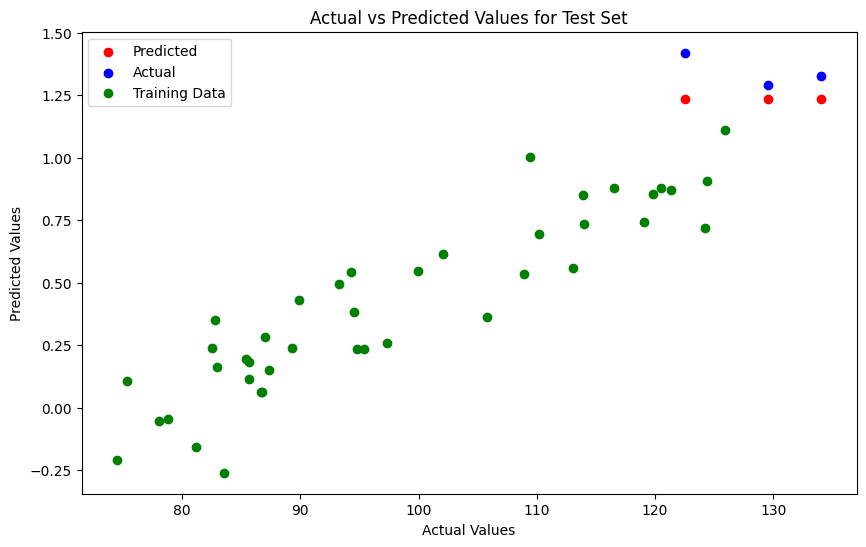

In [7]:

plt.figure(figsize=(10, 6))


plt.scatter(X_test[seq_length:], test_predictions, color='red', label='Predicted')


plt.scatter(X_test[seq_length:], y_test[seq_length:], color='blue', label='Actual')
plt.scatter(X_train, y_train, label='Training Data', color='green')

plt.title('Actual vs Predicted Values for Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


In [8]:

plt.figure(figsize=(10, 6))
plt.plot(y_test[seq_length:], label='Actual', color='blue')
plt.plot(test_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Values for Test Set')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


test_loss, test_mae = deep_model.evaluate(test_ds)
print("Test MAE:", test_mae)
print("Test loss:", test_loss)


model_results = {
    "Test Loss": test_loss,
    "Test MAE": test_mae,
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0076 - mae: 0.1107
Test MAE: 0.11068101972341537
Test loss: 0.0075699579901993275


In [9]:
test_r2 = r2_score(y_test[seq_length:], test_predictions)

print("Test R^2:", test_r2)

Test R^2: -4.239410278211142


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.2790 - mae: 0.6228 - val_loss: 0.1971 - val_mae: 0.5966
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3274 - mae: 0.6685 - val_loss: 1.5614 - val_mae: 2.0614
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4238 - mae: 0.8085 - val_loss: 1.0707 - val_mae: 1.5707
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2092 - mae: 0.5057 - val_loss: 0.3504 - val_mae: 0.8128
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2781 - mae: 0.5921 - val_loss: 0.7162 - val_mae: 1.2162
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2031 - mae: 0.5188 - val_loss: 0.1940 - val_mae: 0.5889
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3276 - mae: 0.6981 - val_loss: 0.3350 - val_mae: 0.7963
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1604 - mae: 0.4766 - val_loss: 0.8479 - val_mae: 1.3479
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1745 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.2234 - mae: 0.5683 - val_loss: 0.3335 - val_mae: 0.7664
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2229 - mae: 0.5526 - val_loss: 0.7308 - val_mae: 1.2300
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3414 - mae: 0.6962 - val_loss: 0.2578 - val_mae: 0.6593
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2182 - mae: 0.5436 - val_loss: 0.3560 - val_mae: 0.7964
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2370 - mae: 0.5585 - val_loss: 0.5471 - val_mae: 1.0310
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2510 - mae: 0.5857 - val_loss: 0.2375 - val_mae: 0.6278
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2857 - mae: 0.6374 - val_loss: 0.2193 - val_mae: 0.5980
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2566 - mae: 0.5834 - val_loss: 0.6154 - val_mae: 1.1076
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3294 - mae: 

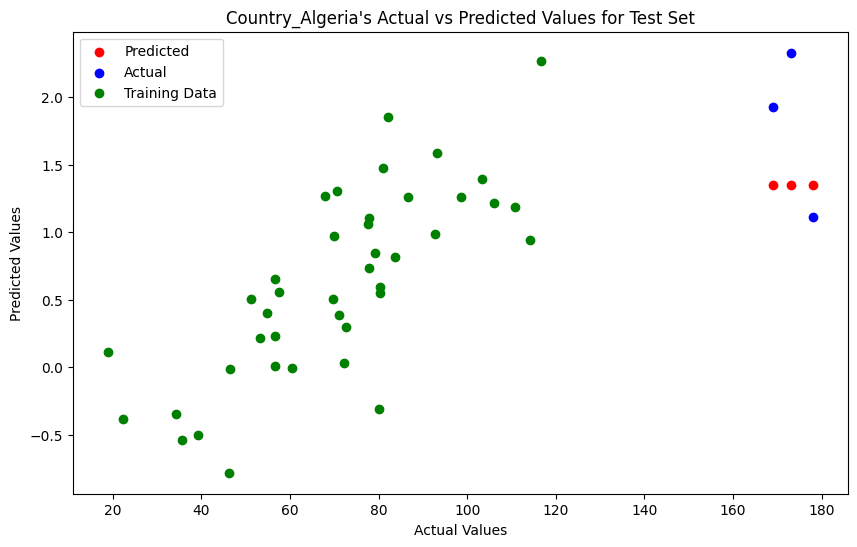

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.1625 - mae: 0.4854 - val_loss: 0.0326 - val_mae: 0.2515
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1728 - mae: 0.4960 - val_loss: 0.0622 - val_mae: 0.2515
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0849 - mae: 0.3405 - val_loss: 0.1786 - val_mae: 0.5422
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1049 - mae: 0.3654 - val_loss: 0.1099 - val_mae: 0.3956
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1007 - mae: 0.3692 - val_loss: 0.0901 - val_mae: 0.3420
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0869 - mae: 0.3441 - val_loss: 0.1731 - val_mae: 0.5320
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1038 - mae: 0.3788 - val_loss: 0.3611 - val_mae: 0.8130
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0803 - mae: 0.3231 - val_loss: 0.3430 - val_mae: 0.7897
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0757 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.1691 - mae: 0.4778 - val_loss: 0.0109 - val_mae: 0.1165
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1468 - mae: 0.4562 - val_loss: 0.1406 - val_mae: 0.5169
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0807 - mae: 0.3172 - val_loss: 0.2520 - val_mae: 0.6999
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0578 - mae: 0.2784 - val_loss: 0.0607 - val_mae: 0.3276
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0674 - mae: 0.2606 - val_loss: 0.2048 - val_mae: 0.6288
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0609 - mae: 0.2909 - val_loss: 0.1148 - val_mae: 0.4642
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0747 - mae: 0.3008 - val_loss: 0.1469 - val_mae: 0.5288
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0684 - mae: 0.2773 - val_loss: 0.1624 - val_mae: 0.5574
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0767 - mae: 

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.2371 - mae: 0.5664 - val_loss: 0.0101 - val_mae: 0.1423
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0976 - mae: 0.3784 - val_loss: 0.0853 - val_mae: 0.3855
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0725 - mae: 0.2960 - val_loss: 0.0404 - val_mae: 0.2420
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0733 - mae: 0.2936 - val_loss: 0.0134 - val_mae: 0.1450
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0518 - mae: 0.2281 - val_loss: 0.0152 - val_mae: 0.1395
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0459 - mae: 0.2453 - val_loss: 0.0466 - val_mae: 0.2729
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0626 - mae: 0.2656 - val_loss: 0.0259 - val_mae: 0.1840
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0474 - mae: 0.2336 - val_loss: 0.0103 - val_mae: 0.1308
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0393 - mae:

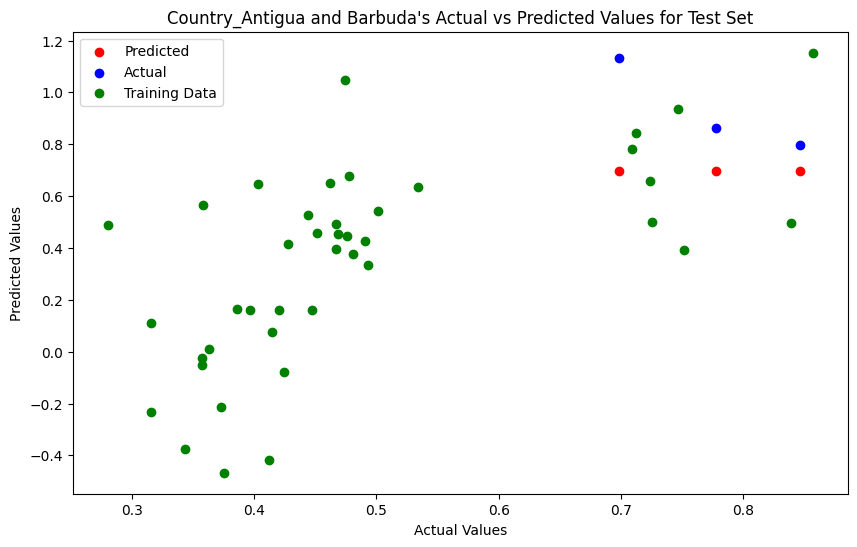

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 0.0772 - mae: 0.3278 - val_loss: 0.3017 - val_mae: 0.7768
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0519 - mae: 0.2860 - val_loss: 0.3134 - val_mae: 0.7917
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0556 - mae: 0.2981 - val_loss: 0.0708 - val_mae: 0.3764
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0920 - mae: 0.3607 - val_loss: 0.2020 - val_mae: 0.6357
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0483 - mae: 0.2647 - val_loss: 0.2394 - val_mae: 0.6919
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0504 - mae: 0.2308 - val_loss: 0.5521 - val_mae: 1.0521
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0687 - mae: 0.3112 - val_loss: 0.1052 - val_mae: 0.4586
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0767 - mae: 0.3194 - val_loss: 0.2159 - val_mae: 0.6571
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0479 - mae:

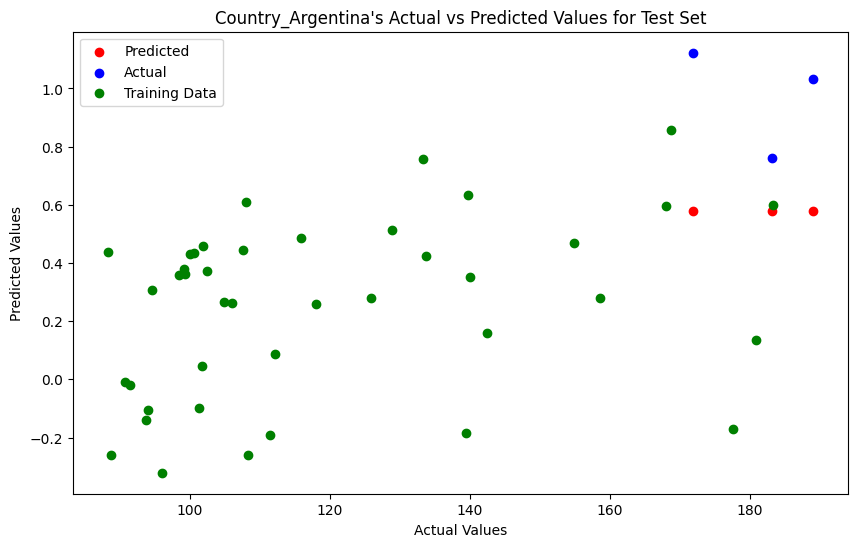

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0693 - mae: 0.2917 - val_loss: 0.2034 - val_mae: 0.6354
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0669 - mae: 0.3027 - val_loss: 0.2249 - val_mae: 0.6684
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0810 - mae: 0.3250 - val_loss: 0.1701 - val_mae: 0.5807
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1091 - mae: 0.3667 - val_loss: 0.1960 - val_mae: 0.6237
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0797 - mae: 0.3026 - val_loss: 0.2356 - val_mae: 0.6842
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0670 - mae: 0.2936 - val_loss: 0.2825 - val_mae: 0.7496
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0850 - mae: 0.3243 - val_loss: 0.1475 - val_mae: 0.5403
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0788 - mae: 0.2978 - val_loss: 0.3373 - val_mae: 0.8195
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0884 - mae:

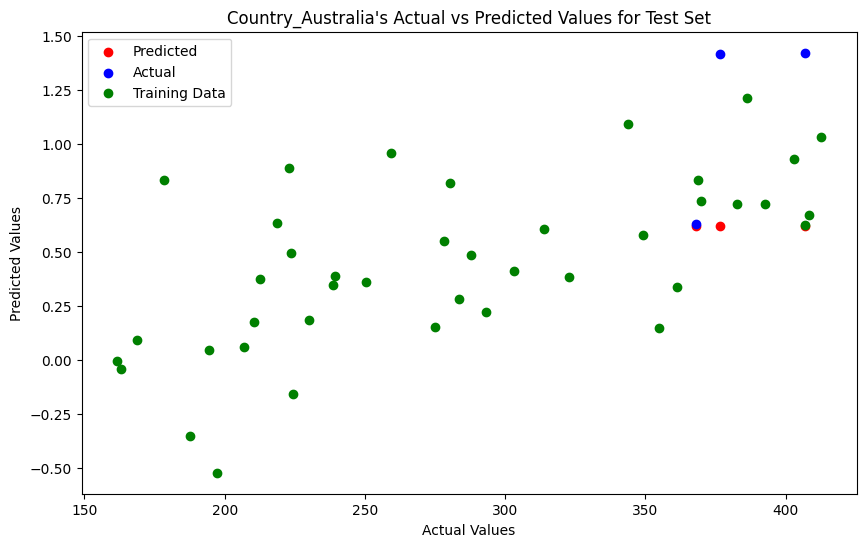

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.2315 - mae: 0.5834 - val_loss: 1.0354 - val_mae: 1.5354
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2680 - mae: 0.6264 - val_loss: 1.0651 - val_mae: 1.5651
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2388 - mae: 0.5640 - val_loss: 1.0379 - val_mae: 1.5379
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2550 - mae: 0.6002 - val_loss: 1.0347 - val_mae: 1.5347
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2417 - mae: 0.6034 - val_loss: 1.2394 - val_mae: 1.7394
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2754 - mae: 0.6361 - val_loss: 0.9808 - val_mae: 1.4808
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1968 - mae: 0.5304 - val_loss: 1.0226 - val_mae: 1.5226
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2325 - mae: 0.5487 - val_loss: 1.2022 - val_mae: 1.7022
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3080 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.1825 - mae: 0.5050 - val_loss: 0.0094 - val_mae: 0.1043
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1357 - mae: 0.4221 - val_loss: 0.0611 - val_mae: 0.3259
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0737 - mae: 0.3070 - val_loss: 0.1177 - val_mae: 0.4716
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0693 - mae: 0.3158 - val_loss: 0.3138 - val_mae: 0.7840
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0570 - mae: 0.2668 - val_loss: 0.1282 - val_mae: 0.4934
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0594 - mae: 0.2842 - val_loss: 0.4460 - val_mae: 0.9377
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0534 - mae: 0.2652 - val_loss: 0.1161 - val_mae: 0.4686
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0613 - mae: 0.3121 - val_loss: 0.2339 - val_mae: 0.6748
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0574 - mae:

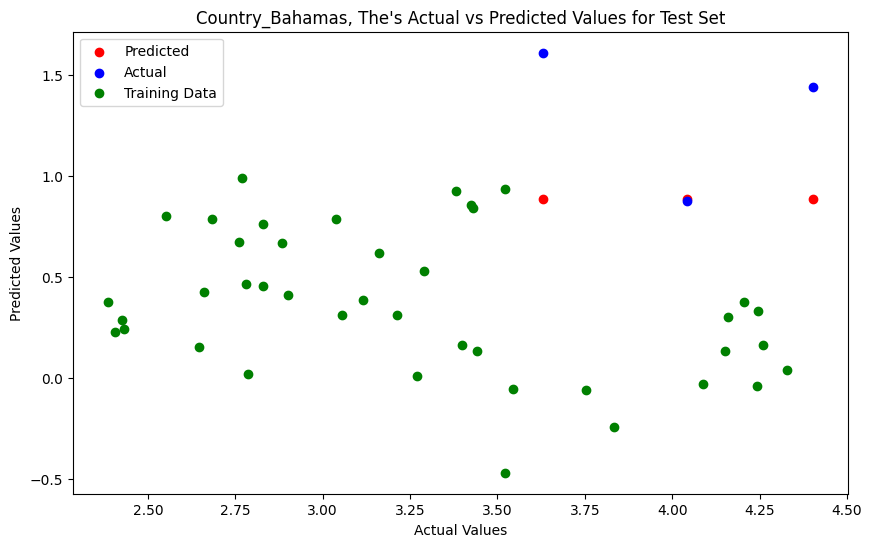

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 0.1845 - mae: 0.5043 - val_loss: 0.0081 - val_mae: 0.1200
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1095 - mae: 0.3752 - val_loss: 0.0074 - val_mae: 0.1200
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0999 - mae: 0.3738 - val_loss: 0.0884 - val_mae: 0.4029
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0560 - mae: 0.2758 - val_loss: 0.0703 - val_mae: 0.3553
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0639 - mae: 0.2951 - val_loss: 0.0757 - val_mae: 0.3702
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0301 - mae: 0.1716 - val_loss: 0.0269 - val_mae: 0.1987
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0565 - mae: 0.2757 - val_loss: 0.0507 - val_mae: 0.2950
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0420 - mae: 0.2397 - val_loss: 0.0431 - val_mae: 0.2682
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0359 - mae:

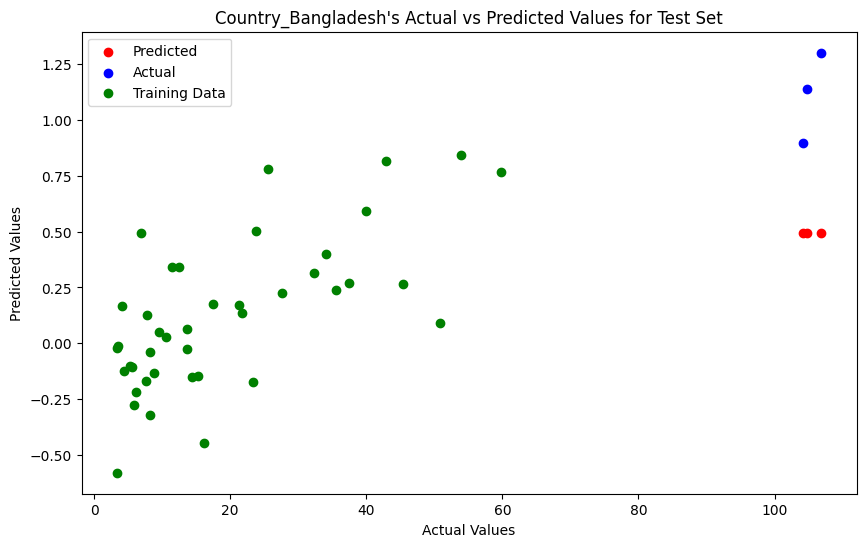

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0867 - mae: 0.3236 - val_loss: 0.0343 - val_mae: 0.2148
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0332 - mae: 0.1880 - val_loss: 0.0219 - val_mae: 0.2076
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0975 - mae: 0.3945 - val_loss: 0.0461 - val_mae: 0.2388
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0687 - mae: 0.2821 - val_loss: 0.0351 - val_mae: 0.2301
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0280 - mae: 0.1674 - val_loss: 0.0552 - val_mae: 0.2427
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0460 - mae: 0.2315 - val_loss: 0.0619 - val_mae: 0.2642
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1008 - mae: 0.3659 - val_loss: 0.0266 - val_mae: 0.2277
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0606 - mae: 0.2712 - val_loss: 0.0399 - val_mae: 0.2306
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0486 - mae:

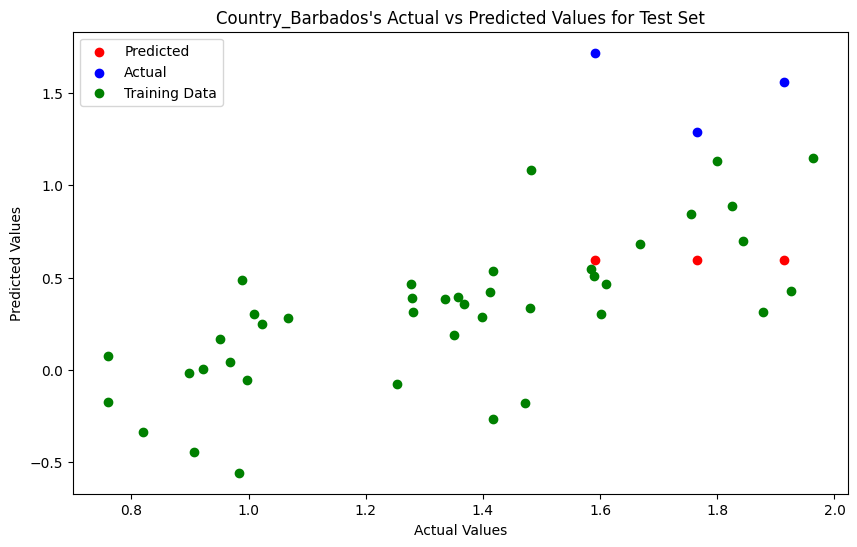

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.2977 - mae: 0.6954 - val_loss: 0.6550 - val_mae: 1.1366
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1055 - mae: 0.3798 - val_loss: 0.1444 - val_mae: 0.3999
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0410 - mae: 0.2476 - val_loss: 0.1712 - val_mae: 0.4318
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0371 - mae: 0.1996 - val_loss: 0.0883 - val_mae: 0.3916
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0308 - mae: 0.1939 - val_loss: 0.1277 - val_mae: 0.3944
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0479 - mae: 0.2468 - val_loss: 0.1310 - val_mae: 0.3960
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0354 - mae: 0.2160 - val_loss: 0.1022 - val_mae: 0.3950
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0394 - mae: 0.2204 - val_loss: 0.1342 - val_mae: 0.3989
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0291 - mae: 0.2

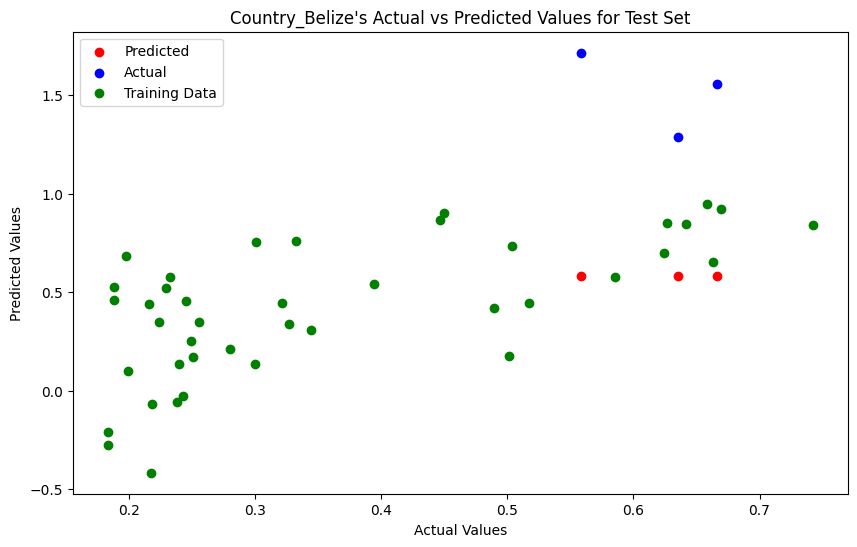

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - loss: 0.0549 - mae: 0.2794 - val_loss: 0.0653 - val_mae: 0.3499
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0492 - mae: 0.2729 - val_loss: 0.0043 - val_mae: 0.0928
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0332 - mae: 0.2181 - val_loss: 0.0105 - val_mae: 0.1115
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0319 - mae: 0.2047 - val_loss: 0.0053 - val_mae: 0.1014
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0317 - mae: 0.2029 - val_loss: 0.0121 - val_mae: 0.1207
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0291 - mae: 0.1883 - val_loss: 0.0078 - val_mae: 0.1006
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0422 - mae: 0.2294 - val_loss: 0.0199 - val_mae: 0.1734
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0368 - mae: 0.2155 - val_loss: 0.0125 - val_mae: 0.1227
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0344 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0570 - mae: 0.2820 - val_loss: 0.0249 - val_mae: 0.1956
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0455 - mae: 0.2490 - val_loss: 0.0538 - val_mae: 0.3093
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0356 - mae: 0.2131 - val_loss: 0.0122 - val_mae: 0.1134
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0403 - mae: 0.2247 - val_loss: 0.0094 - val_mae: 0.1069
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0584 - mae: 0.2840 - val_loss: 0.0705 - val_mae: 0.3584
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0402 - mae: 0.2240 - val_loss: 0.0157 - val_mae: 0.1391
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0449 - mae: 0.2447 - val_loss: 0.0441 - val_mae: 0.2759
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0566 - mae: 0.2955 - val_loss: 0.0221 - val_mae: 0.1787
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0302 - mae:

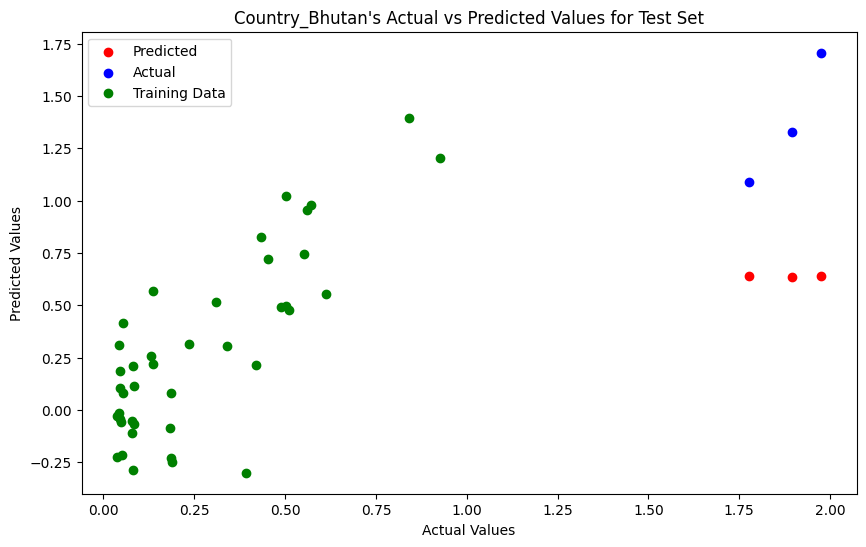

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0725 - mae: 0.3346 - val_loss: 0.4131 - val_mae: 0.8706
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0437 - mae: 0.2411 - val_loss: 0.3310 - val_mae: 0.7617
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0365 - mae: 0.2169 - val_loss: 0.1688 - val_mae: 0.5047
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0398 - mae: 0.2396 - val_loss: 0.2131 - val_mae: 0.5864
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0268 - mae: 0.1909 - val_loss: 0.1959 - val_mae: 0.5554
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0212 - mae: 0.1560 - val_loss: 0.1837 - val_mae: 0.5331
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0308 - mae: 0.2074 - val_loss: 0.2020 - val_mae: 0.5659
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0282 - mae: 0.1832 - val_loss: 0.1720 - val_mae: 0.5103
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0283 - mae:

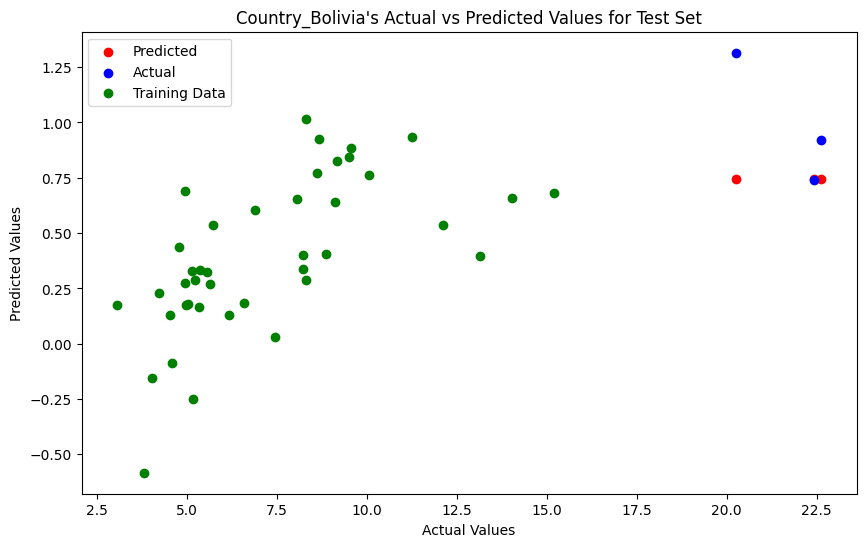

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.1733 - mae: 0.4890 - val_loss: 0.3721 - val_mae: 0.7592
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1460 - mae: 0.4596 - val_loss: 0.4409 - val_mae: 0.8170
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1237 - mae: 0.4116 - val_loss: 0.4818 - val_mae: 0.8294
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1043 - mae: 0.3551 - val_loss: 0.4470 - val_mae: 0.8669
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1311 - mae: 0.4129 - val_loss: 0.4981 - val_mae: 0.8358
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1288 - mae: 0.4274 - val_loss: 0.4239 - val_mae: 0.8358
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1428 - mae: 0.4619 - val_loss: 0.5304 - val_mae: 0.8094
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1843 - mae: 0.4927 - val_loss: 0.4198 - val_mae: 0.8446
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1328 - mae:

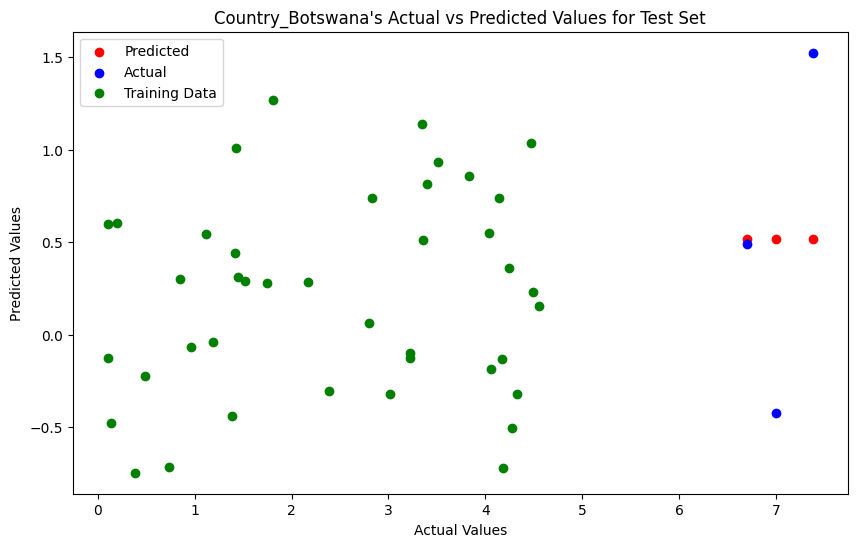

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0711 - mae: 0.3023 - val_loss: 0.4330 - val_mae: 0.9153
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0547 - mae: 0.2635 - val_loss: 0.3328 - val_mae: 0.7954
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0640 - mae: 0.2838 - val_loss: 0.4138 - val_mae: 0.8930
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0624 - mae: 0.2841 - val_loss: 0.2877 - val_mae: 0.7365
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0660 - mae: 0.2827 - val_loss: 0.4218 - val_mae: 0.9024
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0649 - mae: 0.2980 - val_loss: 0.3382 - val_mae: 0.8021
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0727 - mae: 0.3014 - val_loss: 0.3796 - val_mae: 0.8525
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0677 - mae: 0.2876 - val_loss: 0.3725 - val_mae: 0.8440
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0644 - mae:

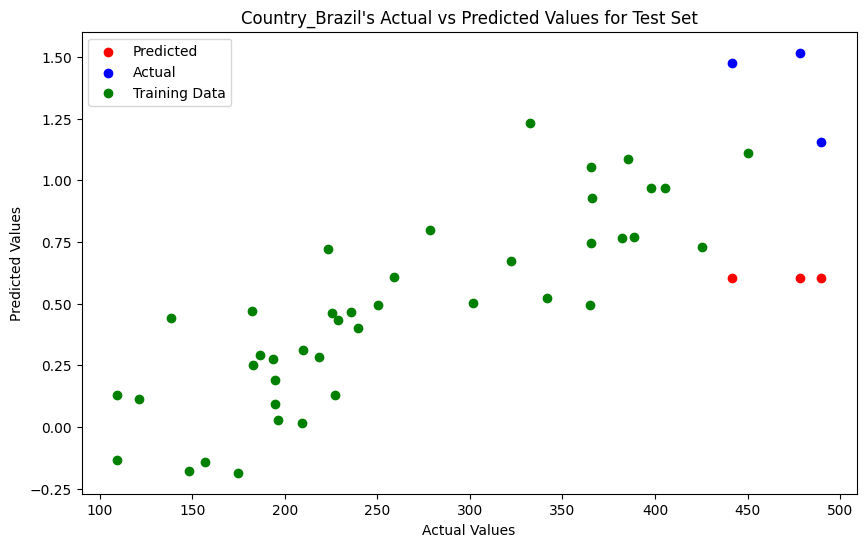

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0665 - mae: 0.2865 - val_loss: 0.1002 - val_mae: 0.4401
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0570 - mae: 0.2856 - val_loss: 0.0353 - val_mae: 0.2526
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0529 - mae: 0.2596 - val_loss: 0.0097 - val_mae: 0.1142
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0503 - mae: 0.2593 - val_loss: 0.0037 - val_mae: 0.0847
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0530 - mae: 0.2440 - val_loss: 0.0058 - val_mae: 0.0862
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0479 - mae: 0.2649 - val_loss: 0.0048 - val_mae: 0.0899
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0459 - mae: 0.2369 - val_loss: 0.0046 - val_mae: 0.0921
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0496 - mae: 0.2514 - val_loss: 0.0086 - val_mae: 0.0946
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0472 - mae:

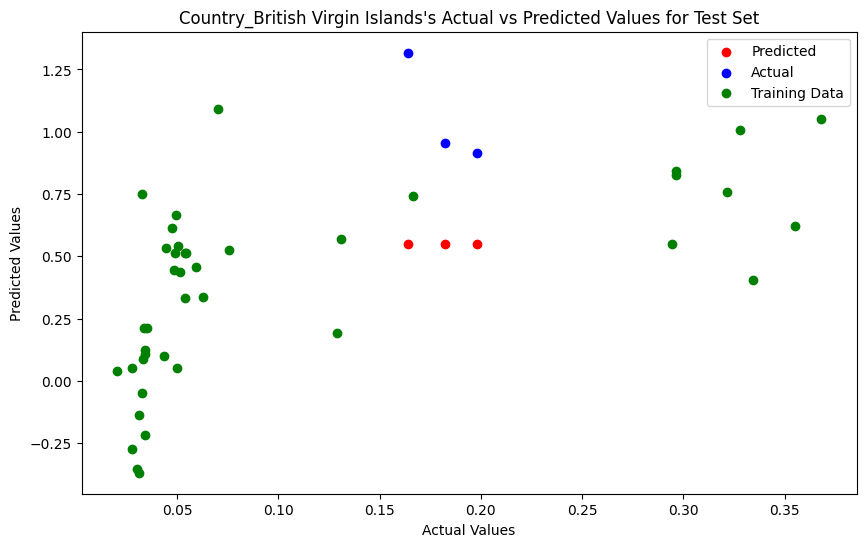

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.1787 - mae: 0.4730 - val_loss: 0.7064 - val_mae: 1.2064
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2192 - mae: 0.5076 - val_loss: 0.3327 - val_mae: 0.8067
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2062 - mae: 0.5164 - val_loss: 0.6386 - val_mae: 1.1386
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2093 - mae: 0.5424 - val_loss: 0.3684 - val_mae: 0.8498
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2646 - mae: 0.6113 - val_loss: 0.8201 - val_mae: 1.3201
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2767 - mae: 0.5959 - val_loss: 0.7589 - val_mae: 1.2589
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2331 - mae: 0.5427 - val_loss: 0.1553 - val_mae: 0.5441
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2387 - mae: 0.5861 - val_loss: 0.7921 - val_mae: 1.2921
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2305 - mae:

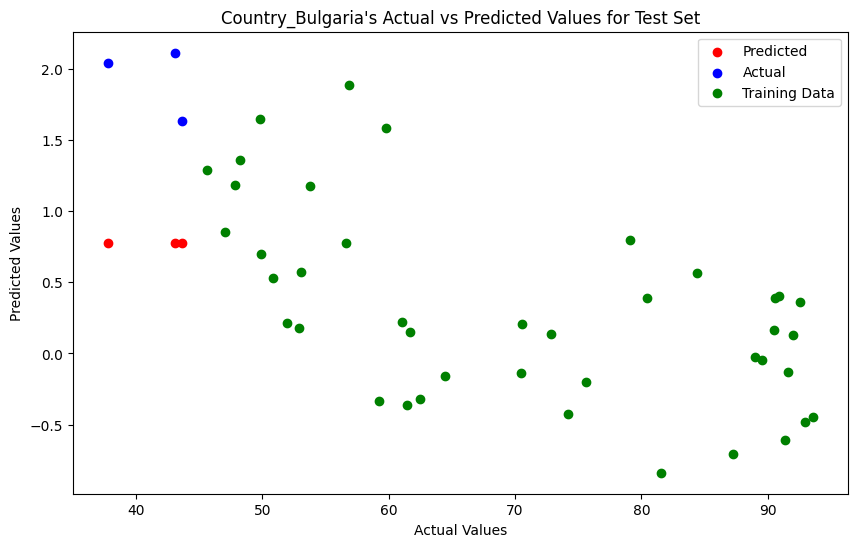

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 0.0638 - mae: 0.2883 - val_loss: 0.0189 - val_mae: 0.1460
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0469 - mae: 0.2515 - val_loss: 0.0065 - val_mae: 0.1085
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0667 - mae: 0.2989 - val_loss: 0.0136 - val_mae: 0.1382
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0620 - mae: 0.3015 - val_loss: 0.0144 - val_mae: 0.1305
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0598 - mae: 0.2731 - val_loss: 0.0489 - val_mae: 0.2905
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0464 - mae: 0.2482 - val_loss: 0.0109 - val_mae: 0.1080
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0648 - mae: 0.2930 - val_loss: 0.0533 - val_mae: 0.3117
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0700 - mae: 0.3202 - val_loss: 0.0163 - val_mae: 0.1509
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0601 - mae:

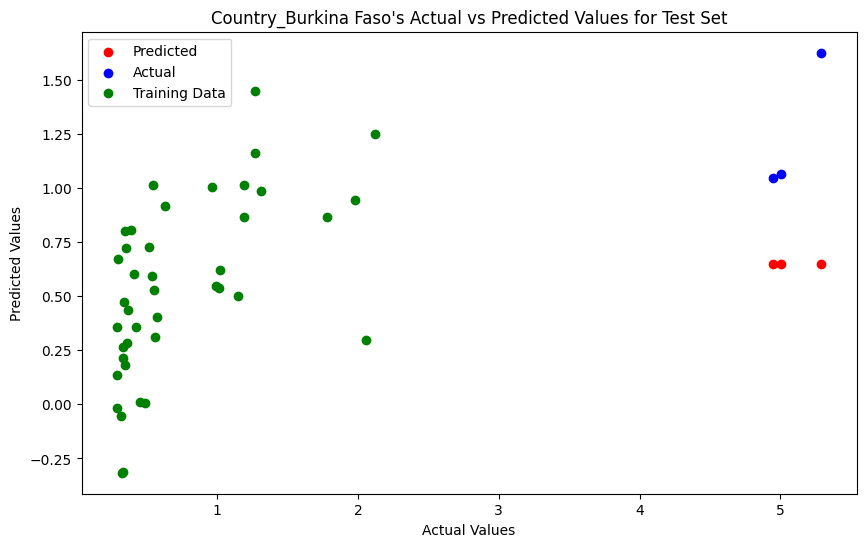

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.3102 - mae: 0.6223 - val_loss: 0.1320 - val_mae: 0.5122
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1314 - mae: 0.4207 - val_loss: 0.0516 - val_mae: 0.3209
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1847 - mae: 0.4723 - val_loss: 0.0083 - val_mae: 0.1249
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1893 - mae: 0.4986 - val_loss: 7.7021e-04 - val_mae: 0.0392
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1489 - mae: 0.4174 - val_loss: 0.0049 - val_mae: 0.0924
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1864 - mae: 0.5138 - val_loss: 0.0034 - val_mae: 0.0750
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1609 - mae: 0.4493 - val_loss: 0.0092 - val_mae: 0.1310
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1333 - mae: 0.4227 - val_loss: 7.0831e-04 - val_mae: 0.0340
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.178

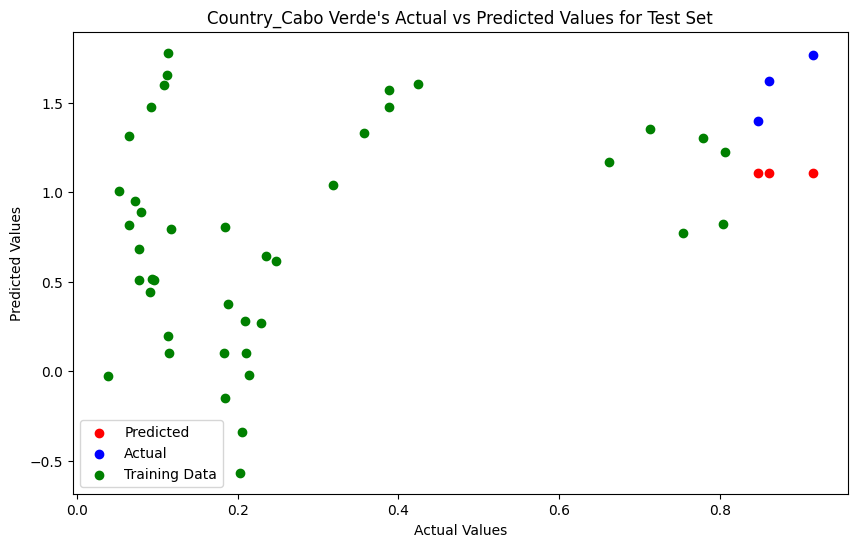

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 0.1435 - mae: 0.4248 - val_loss: 0.0644 - val_mae: 0.2701
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0649 - mae: 0.2909 - val_loss: 0.0692 - val_mae: 0.2775
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0557 - mae: 0.2613 - val_loss: 0.0263 - val_mae: 0.2293
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0358 - mae: 0.2105 - val_loss: 0.0273 - val_mae: 0.2319
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0559 - mae: 0.2788 - val_loss: 0.0362 - val_mae: 0.2274
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0260 - mae: 0.1703 - val_loss: 0.0270 - val_mae: 0.2294
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0354 - mae: 0.2012 - val_loss: 0.0302 - val_mae: 0.2247
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0465 - mae: 0.2308 - val_loss: 0.0270 - val_mae: 0.2258
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0308 - mae:

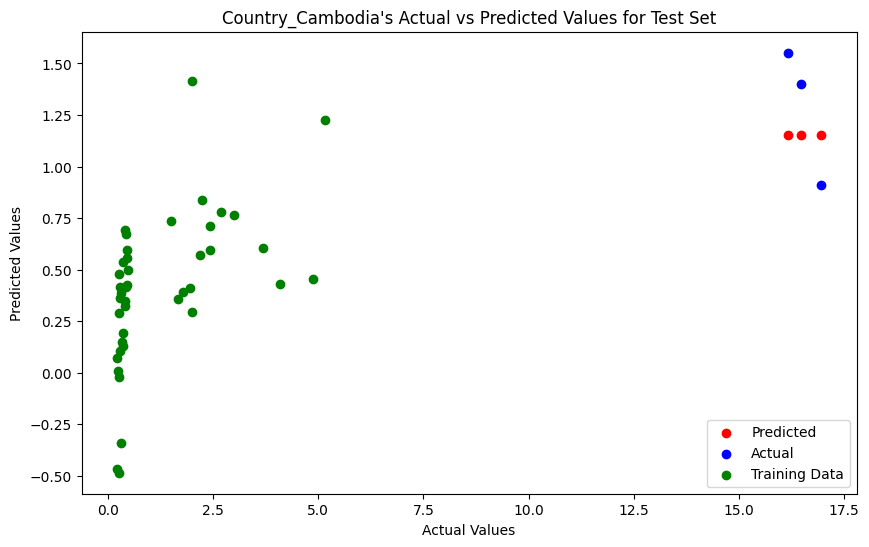

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0896 - mae: 0.3399 - val_loss: 0.0621 - val_mae: 0.3296
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0510 - mae: 0.2531 - val_loss: 0.0490 - val_mae: 0.2913
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0722 - mae: 0.3118 - val_loss: 0.0994 - val_mae: 0.4282
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0551 - mae: 0.2819 - val_loss: 0.1036 - val_mae: 0.4350
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0396 - mae: 0.2247 - val_loss: 0.0409 - val_mae: 0.2528
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0448 - mae: 0.2462 - val_loss: 0.0359 - val_mae: 0.2327
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0731 - mae: 0.3236 - val_loss: 0.0441 - val_mae: 0.2644
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0577 - mae: 0.2728 - val_loss: 0.0870 - val_mae: 0.3944
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0391 - mae: 0.

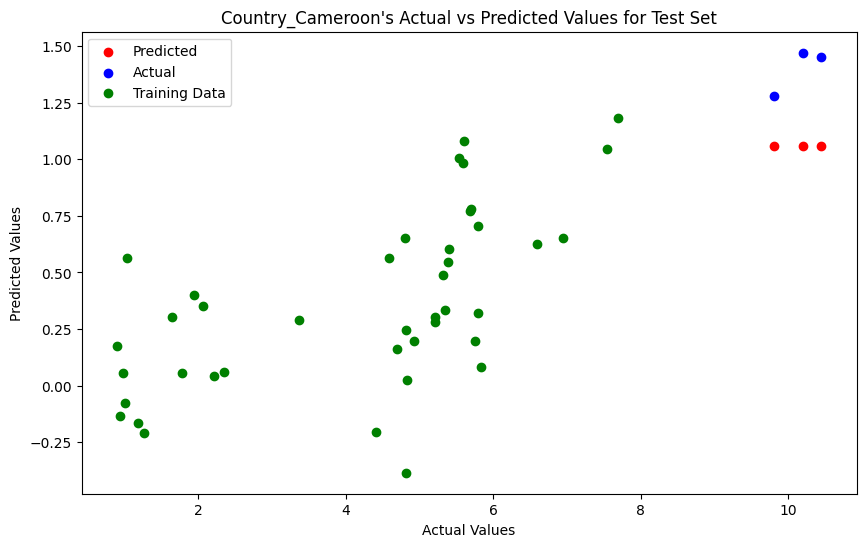

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - loss: 0.3911 - mae: 0.7794 - val_loss: 0.1138 - val_mae: 0.4715
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3010 - mae: 0.6707 - val_loss: 0.1384 - val_mae: 0.4715
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3917 - mae: 0.7622 - val_loss: 0.1113 - val_mae: 0.4715
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3363 - mae: 0.7017 - val_loss: 0.1116 - val_mae: 0.4715
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3153 - mae: 0.6940 - val_loss: 0.1259 - val_mae: 0.4715
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2751 - mae: 0.6023 - val_loss: 0.1116 - val_mae: 0.4715
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3553 - mae: 0.7406 - val_loss: 0.1301 - val_mae: 0.4715
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3616 - mae: 0.7149 - val_loss: 0.1397 - val_mae: 0.4715
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3369 - mae:

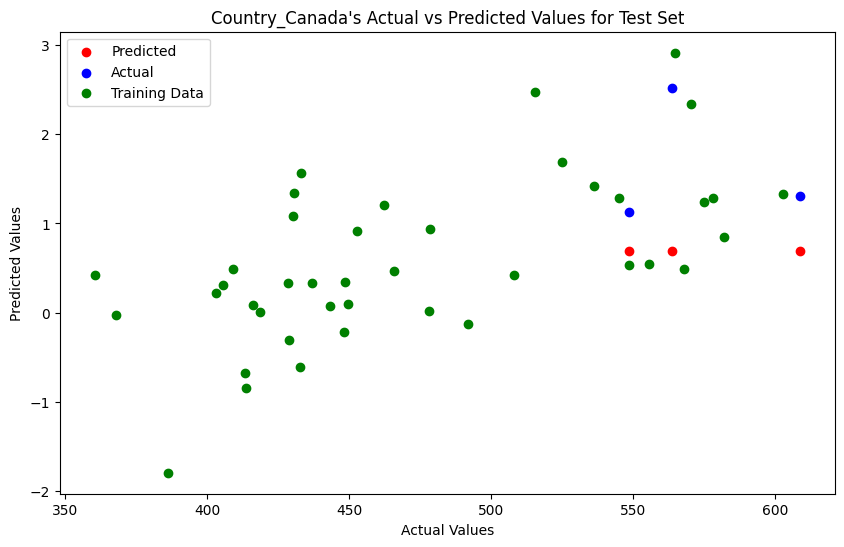

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.1280 - mae: 0.4346 - val_loss: 0.0192 - val_mae: 0.1535
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0603 - mae: 0.2737 - val_loss: 0.0526 - val_mae: 0.2995
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0515 - mae: 0.2517 - val_loss: 0.0117 - val_mae: 0.1243
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0279 - mae: 0.1939 - val_loss: 0.0413 - val_mae: 0.2589
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0335 - mae: 0.2034 - val_loss: 0.0113 - val_mae: 0.1235
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0425 - mae: 0.2349 - val_loss: 0.0102 - val_mae: 0.1230
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0426 - mae: 0.2327 - val_loss: 0.0361 - val_mae: 0.2389
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0360 - mae: 0.2111 - val_loss: 0.0237 - val_mae: 0.1803
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0440 - mae: 

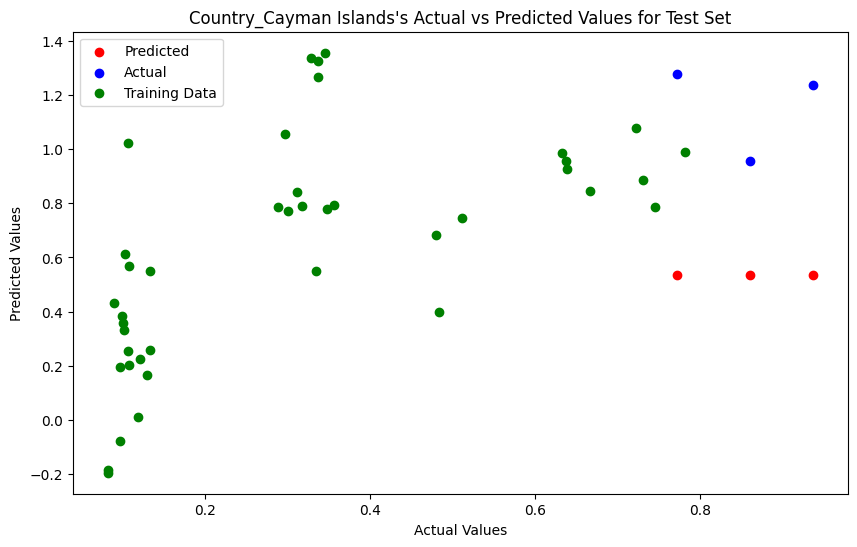

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0491 - mae: 0.2704 - val_loss: 0.1423 - val_mae: 0.5024
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0357 - mae: 0.2055 - val_loss: 0.1641 - val_mae: 0.5501
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0426 - mae: 0.2139 - val_loss: 0.1525 - val_mae: 0.5324
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0292 - mae: 0.1717 - val_loss: 0.0998 - val_mae: 0.4255
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0299 - mae: 0.1887 - val_loss: 0.1065 - val_mae: 0.4418
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0246 - mae: 0.1584 - val_loss: 0.1033 - val_mae: 0.4341
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0414 - mae: 0.2132 - val_loss: 0.0870 - val_mae: 0.3934
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0345 - mae: 0.1826 - val_loss: 0.1070 - val_mae: 0.4421
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0342 - mae:

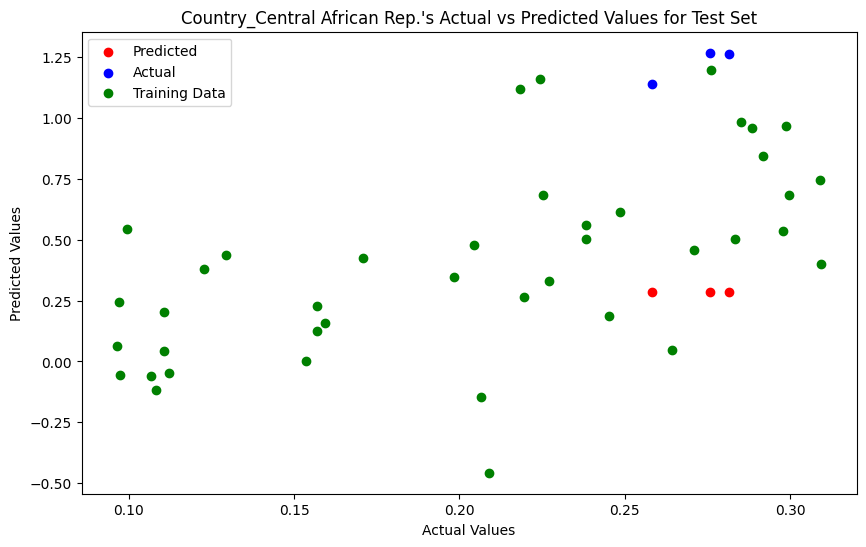

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 0.1142 - mae: 0.4062 - val_loss: 0.0236 - val_mae: 0.1638
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0657 - mae: 0.3102 - val_loss: 0.0154 - val_mae: 0.1631
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0766 - mae: 0.3314 - val_loss: 0.1042 - val_mae: 0.4325
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0475 - mae: 0.2476 - val_loss: 0.0122 - val_mae: 0.1534
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0512 - mae: 0.2705 - val_loss: 0.0125 - val_mae: 0.1583
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0458 - mae: 0.2543 - val_loss: 0.0168 - val_mae: 0.1753
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0583 - mae: 0.2859 - val_loss: 0.0327 - val_mae: 0.1930
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0504 - mae: 0.2691 - val_loss: 0.0133 - val_mae: 0.1625
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0516 - mae:

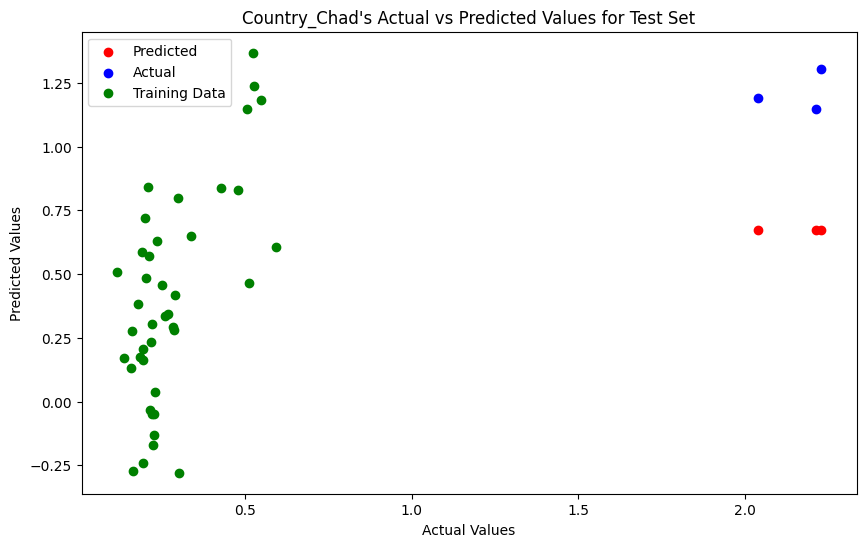

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0747 - mae: 0.3122 - val_loss: 0.0633 - val_mae: 0.3071
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0333 - mae: 0.2051 - val_loss: 0.1211 - val_mae: 0.4580
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0379 - mae: 0.2336 - val_loss: 0.0442 - val_mae: 0.2365
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0547 - mae: 0.2621 - val_loss: 0.1734 - val_mae: 0.5607
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0360 - mae: 0.2102 - val_loss: 0.1268 - val_mae: 0.4704
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0353 - mae: 0.2211 - val_loss: 0.1196 - val_mae: 0.4549
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0394 - mae: 0.2397 - val_loss: 0.1000 - val_mae: 0.4094
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0407 - mae: 0.2383 - val_loss: 0.1346 - val_mae: 0.4865
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0357 - mae:

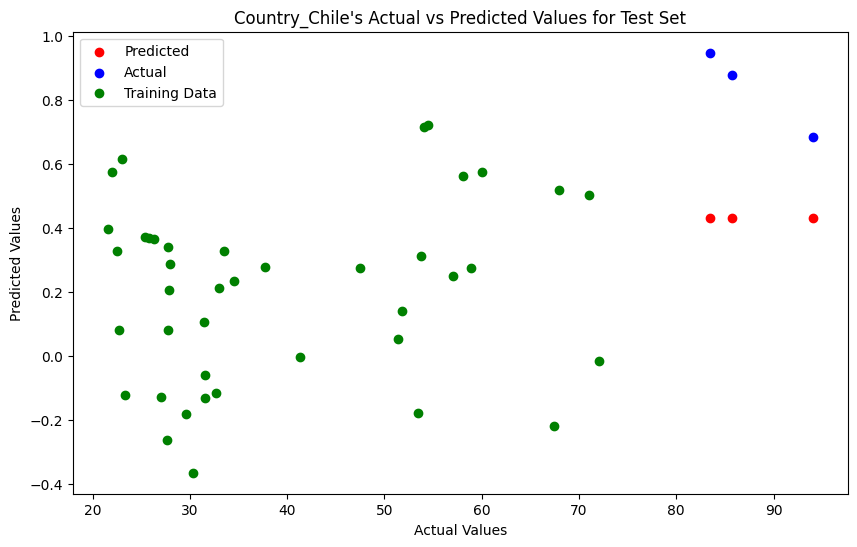

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0654 - mae: 0.3086 - val_loss: 0.1839 - val_mae: 0.5735
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0623 - mae: 0.2967 - val_loss: 0.4817 - val_mae: 0.9687
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0794 - mae: 0.3257 - val_loss: 0.2061 - val_mae: 0.6109
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0724 - mae: 0.3057 - val_loss: 0.2733 - val_mae: 0.7125
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0557 - mae: 0.2732 - val_loss: 0.2917 - val_mae: 0.7379
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0486 - mae: 0.2603 - val_loss: 0.3048 - val_mae: 0.7553
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0684 - mae: 0.3098 - val_loss: 0.2943 - val_mae: 0.7414
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0611 - mae: 0.2850 - val_loss: 0.3252 - val_mae: 0.7819
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0668 - mae:

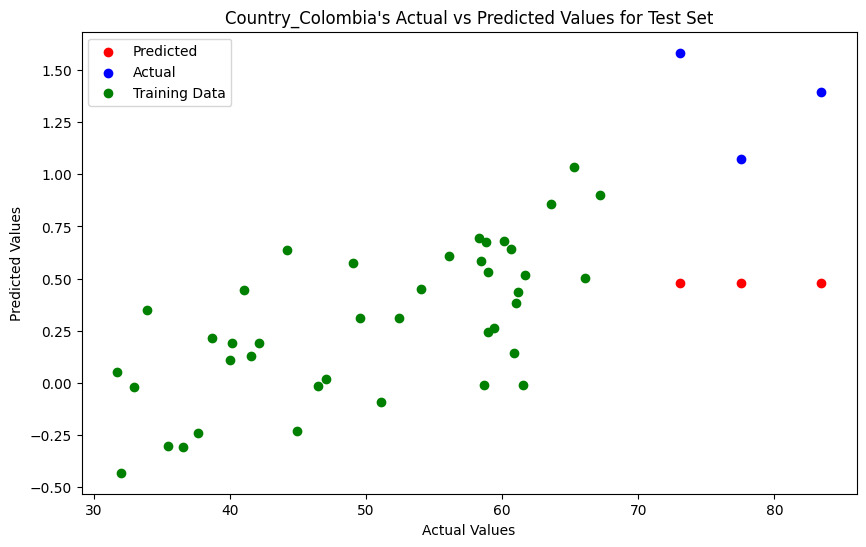

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.0308 - mae: 0.1994 - val_loss: 0.1276 - val_mae: 0.4022
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0226 - mae: 0.1669 - val_loss: 0.0784 - val_mae: 0.3042
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0351 - mae: 0.2248 - val_loss: 0.0724 - val_mae: 0.3023
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0213 - mae: 0.1772 - val_loss: 0.1894 - val_mae: 0.5382
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0376 - mae: 0.2235 - val_loss: 0.0683 - val_mae: 0.3006
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0260 - mae: 0.1882 - val_loss: 0.1119 - val_mae: 0.3661
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0304 - mae: 0.2003 - val_loss: 0.1080 - val_mae: 0.3554
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0235 - mae: 0.1662 - val_loss: 0.0850 - val_mae: 0.3001
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0242 - mae:

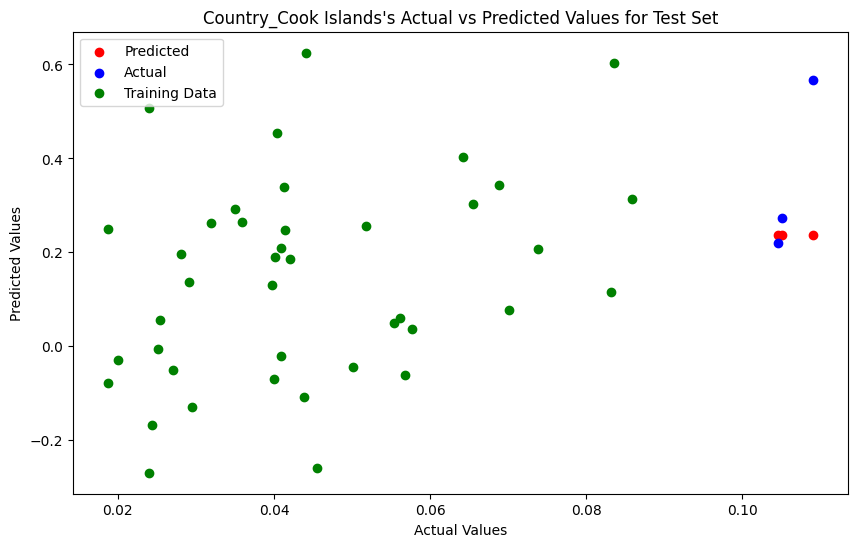

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.1248 - mae: 0.3938 - val_loss: 0.3988 - val_mae: 0.8810
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0844 - mae: 0.3425 - val_loss: 0.1218 - val_mae: 0.4709
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0637 - mae: 0.2931 - val_loss: 0.3863 - val_mae: 0.8666
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0611 - mae: 0.2916 - val_loss: 0.1310 - val_mae: 0.4902
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0659 - mae: 0.2951 - val_loss: 0.3365 - val_mae: 0.8070
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0866 - mae: 0.3491 - val_loss: 0.2231 - val_mae: 0.6515
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0565 - mae: 0.2664 - val_loss: 0.2624 - val_mae: 0.7093
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0606 - mae: 0.2751 - val_loss: 0.2052 - val_mae: 0.6235
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0626 - mae:

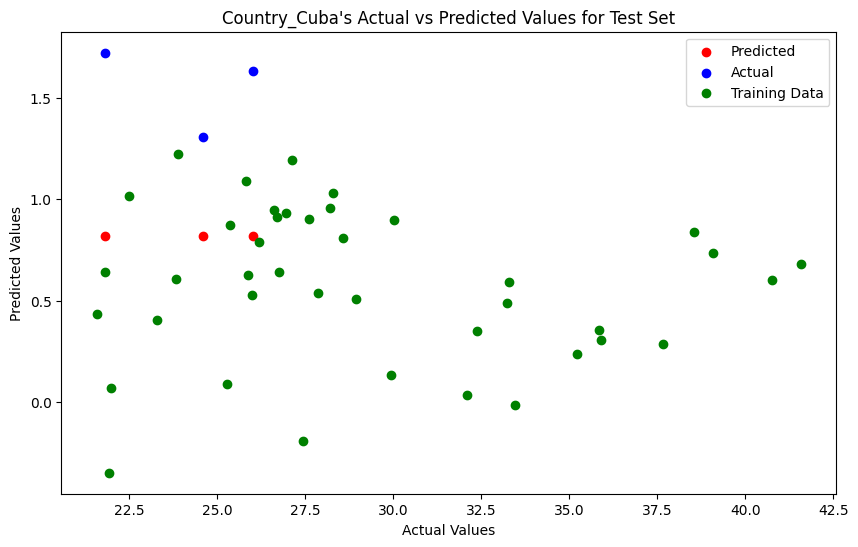

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - loss: 0.1332 - mae: 0.4251 - val_loss: 0.3013 - val_mae: 0.7760
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1266 - mae: 0.3717 - val_loss: 0.1772 - val_mae: 0.5953
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1129 - mae: 0.3392 - val_loss: 0.0027 - val_mae: 0.0621
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1060 - mae: 0.3381 - val_loss: 0.1692 - val_mae: 0.5799
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1142 - mae: 0.3942 - val_loss: 0.2191 - val_mae: 0.6614
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0961 - mae: 0.3147 - val_loss: 0.0015 - val_mae: 0.0496
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1573 - mae: 0.4673 - val_loss: 0.0234 - val_mae: 0.2162
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1409 - mae: 0.4172 - val_loss: 0.2178 - val_mae: 0.6599
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0801 - mae:

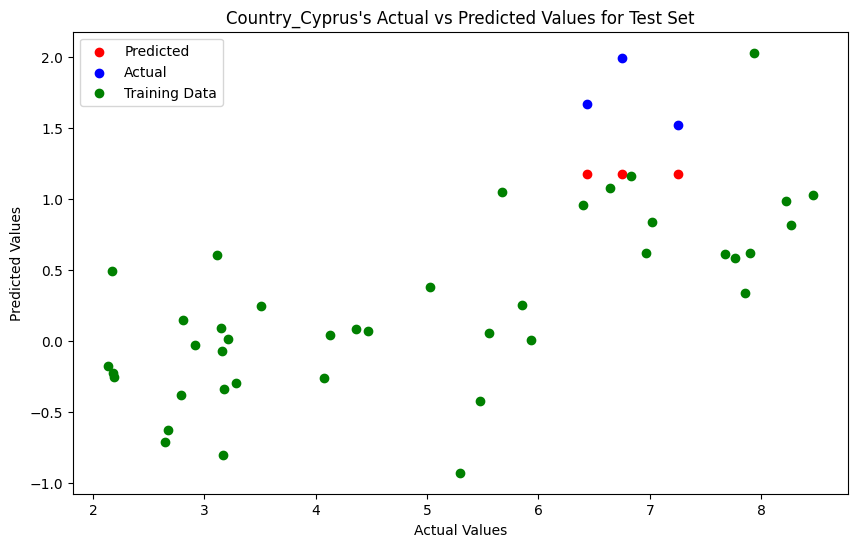

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - loss: 0.3730 - mae: 0.7178 - val_loss: 1.0562 - val_mae: 1.5560
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3471 - mae: 0.7323 - val_loss: 0.6954 - val_mae: 1.1488
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3747 - mae: 0.7325 - val_loss: 0.9243 - val_mae: 1.4177
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2935 - mae: 0.6247 - val_loss: 0.7624 - val_mae: 1.2320
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3104 - mae: 0.6462 - val_loss: 0.9413 - val_mae: 1.4361
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3191 - mae: 0.6676 - val_loss: 0.8202 - val_mae: 1.3006
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3097 - mae: 0.6692 - val_loss: 0.8101 - val_mae: 1.2888
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2990 - mae: 0.6517 - val_loss: 0.7975 - val_mae: 1.2740
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3853 - mae:

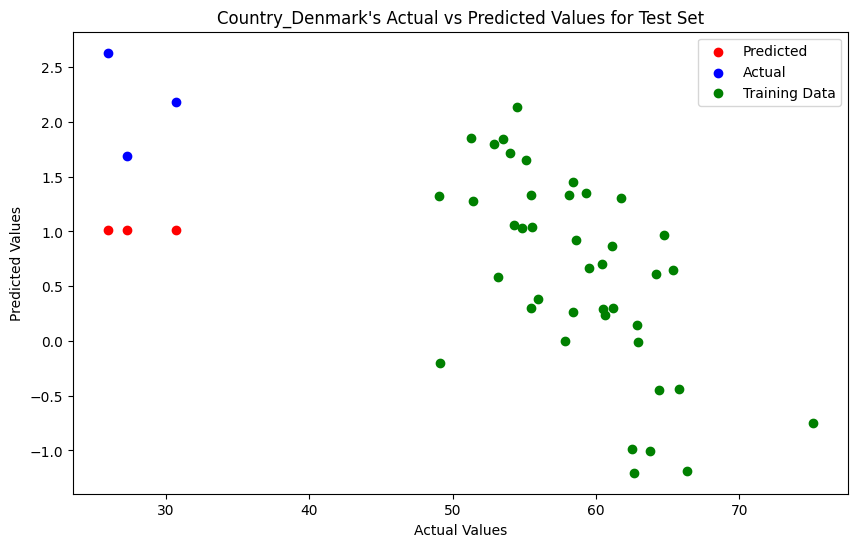

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 0.1362 - mae: 0.4426 - val_loss: 0.3038 - val_mae: 0.7382
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1072 - mae: 0.3723 - val_loss: 0.5272 - val_mae: 1.0141
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0909 - mae: 0.3601 - val_loss: 0.2576 - val_mae: 0.6752
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1185 - mae: 0.4199 - val_loss: 0.3892 - val_mae: 0.8497
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1016 - mae: 0.3679 - val_loss: 0.3589 - val_mae: 0.8116
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1033 - mae: 0.3737 - val_loss: 0.4571 - val_mae: 0.9323
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1026 - mae: 0.3437 - val_loss: 0.3084 - val_mae: 0.7460
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0870 - mae: 0.3548 - val_loss: 0.4511 - val_mae: 0.9258
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1432 - mae:

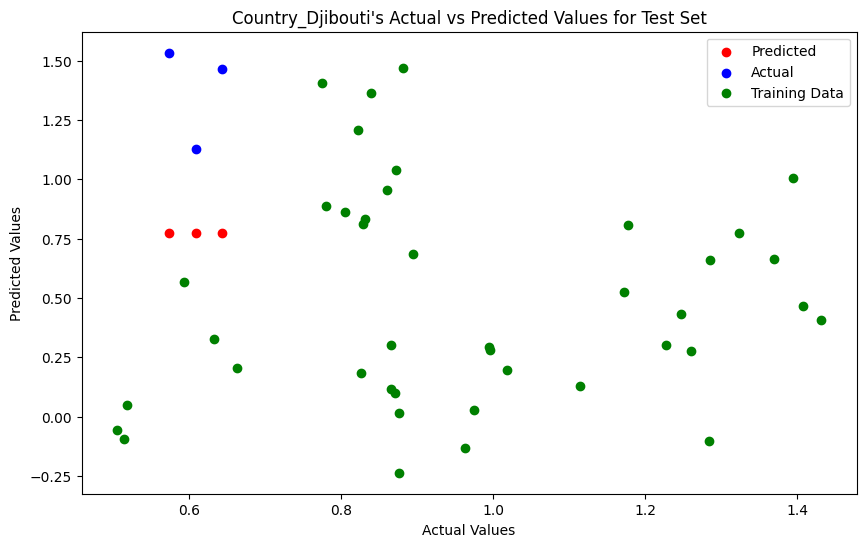

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.1008 - mae: 0.3450 - val_loss: 0.0057 - val_mae: 0.1066
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0779 - mae: 0.3336 - val_loss: 0.0108 - val_mae: 0.1085
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0452 - mae: 0.2370 - val_loss: 0.0070 - val_mae: 0.1027
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0519 - mae: 0.2663 - val_loss: 0.0142 - val_mae: 0.1326
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0496 - mae: 0.2471 - val_loss: 0.0156 - val_mae: 0.1429
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0385 - mae: 0.2221 - val_loss: 0.0057 - val_mae: 0.1047
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0413 - mae: 0.2381 - val_loss: 0.0092 - val_mae: 0.1068
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0387 - mae: 0.2382 - val_loss: 0.0099 - val_mae: 0.1082
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0301 - mae:

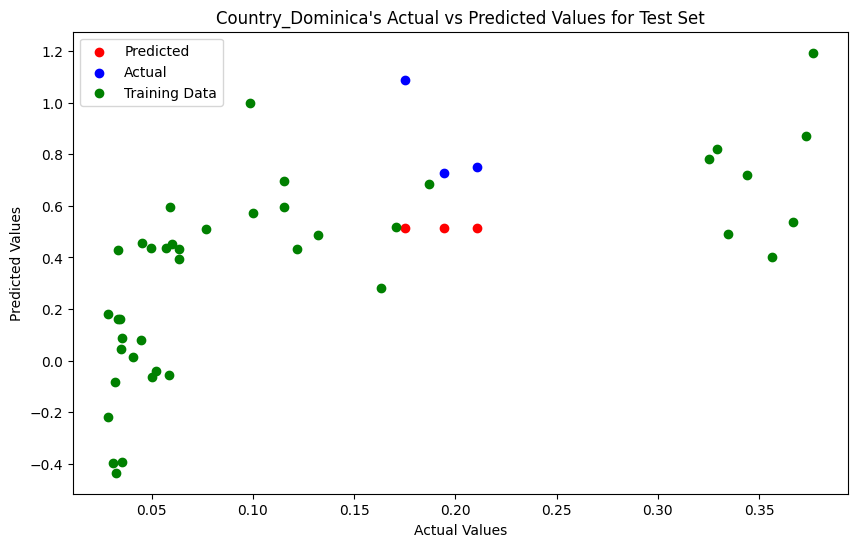

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.1018 - mae: 0.3681 - val_loss: 0.2119 - val_mae: 0.6405
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0559 - mae: 0.2522 - val_loss: 0.1988 - val_mae: 0.6197
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0624 - mae: 0.2881 - val_loss: 0.0492 - val_mae: 0.2912
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0674 - mae: 0.3255 - val_loss: 0.0080 - val_mae: 0.1164
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0939 - mae: 0.3883 - val_loss: 0.1910 - val_mae: 0.6070
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0510 - mae: 0.2419 - val_loss: 0.0761 - val_mae: 0.3724
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0447 - mae: 0.2511 - val_loss: 0.0276 - val_mae: 0.2042
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0348 - mae: 0.2282 - val_loss: 0.0932 - val_mae: 0.4158
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0351 - mae:

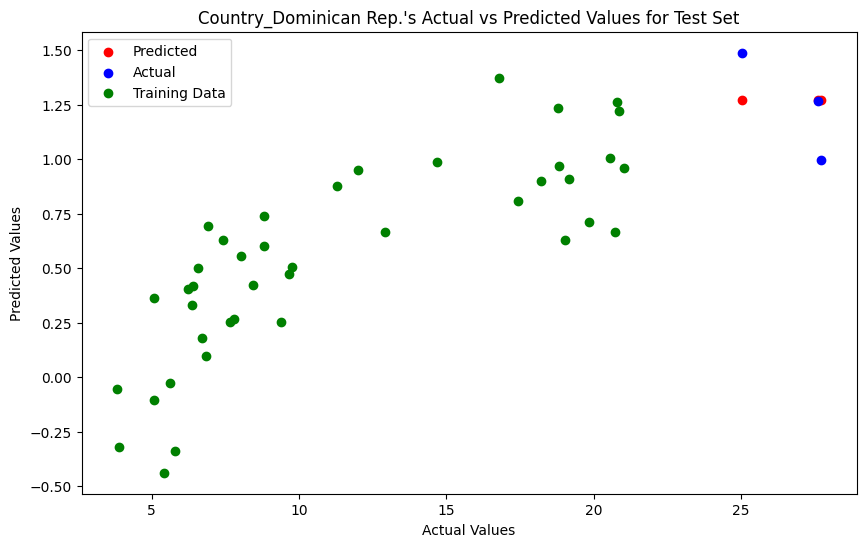

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 0.2101 - mae: 0.5335 - val_loss: 0.1391 - val_mae: 0.4917
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1235 - mae: 0.4327 - val_loss: 0.6173 - val_mae: 1.1159
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1333 - mae: 0.4239 - val_loss: 0.1507 - val_mae: 0.5147
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0902 - mae: 0.3414 - val_loss: 0.2614 - val_mae: 0.6974
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0584 - mae: 0.2694 - val_loss: 0.2121 - val_mae: 0.6227
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0597 - mae: 0.2687 - val_loss: 0.1965 - val_mae: 0.5972
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0631 - mae: 0.2784 - val_loss: 0.2874 - val_mae: 0.7337
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0809 - mae: 0.3328 - val_loss: 0.2118 - val_mae: 0.6222
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0689 - mae:

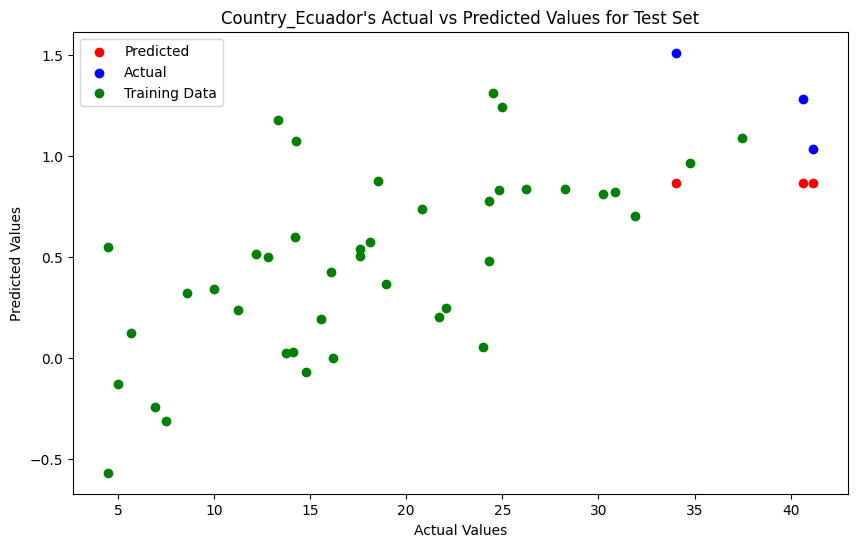

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0634 - mae: 0.2830 - val_loss: 0.1129 - val_mae: 0.3482
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0416 - mae: 0.2420 - val_loss: 0.1328 - val_mae: 0.4055
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0348 - mae: 0.2149 - val_loss: 0.1340 - val_mae: 0.4097
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0446 - mae: 0.2403 - val_loss: 0.1171 - val_mae: 0.3660
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0363 - mae: 0.2182 - val_loss: 0.1469 - val_mae: 0.4400
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0360 - mae: 0.2243 - val_loss: 0.1584 - val_mae: 0.4652
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0354 - mae: 0.2218 - val_loss: 0.1402 - val_mae: 0.4240
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0333 - mae: 0.2066 - val_loss: 0.1844 - val_mae: 0.5177
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0432 - mae:

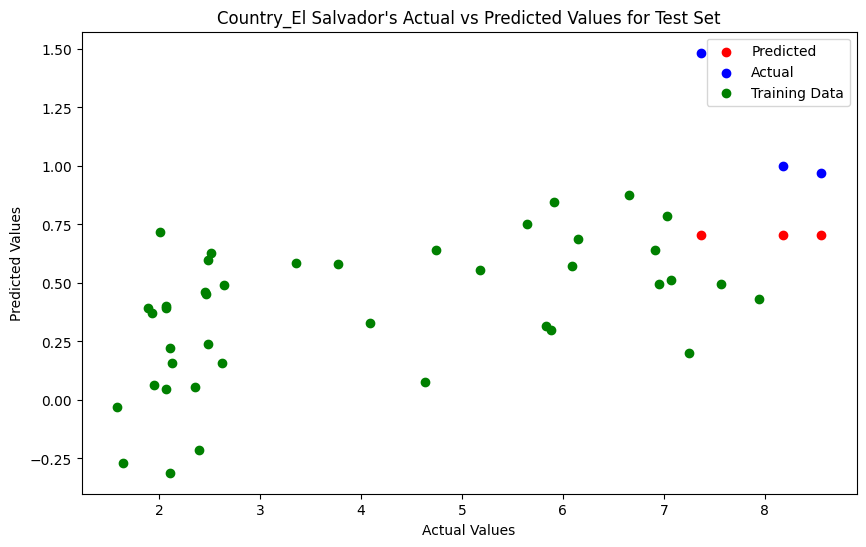

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0495 - mae: 0.2407 - val_loss: 0.0082 - val_mae: 0.1267
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0284 - mae: 0.1946 - val_loss: 1.1244e-04 - val_mae: 0.0147
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0248 - mae: 0.1799 - val_loss: 0.0028 - val_mae: 0.0742
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0242 - mae: 0.1839 - val_loss: 0.0097 - val_mae: 0.1392
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0193 - mae: 0.1635 - val_loss: 0.0036 - val_mae: 0.0841
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0228 - mae: 0.1739 - val_loss: 0.0050 - val_mae: 0.0994
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0256 - mae: 0.1883 - val_loss: 4.8493e-04 - val_mae: 0.0292
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0200 - mae: 0.1563 - val_loss: 9.0747e-04 - val_mae: 0.0412
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0

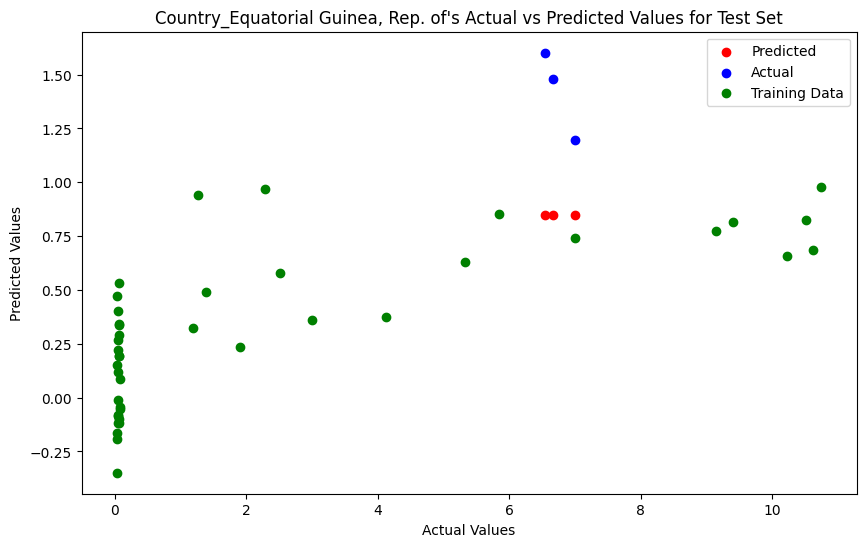

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 0.3737 - mae: 0.7498 - val_loss: 1.2157 - val_mae: 1.7157
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4533 - mae: 0.8550 - val_loss: 1.2572 - val_mae: 1.7572
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4027 - mae: 0.7953 - val_loss: 1.3423 - val_mae: 1.8423
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4169 - mae: 0.7696 - val_loss: 1.3426 - val_mae: 1.8426
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3533 - mae: 0.7379 - val_loss: 1.4443 - val_mae: 1.9443
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3825 - mae: 0.7683 - val_loss: 1.1814 - val_mae: 1.6814
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4154 - mae: 0.7798 - val_loss: 1.3846 - val_mae: 1.8846
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3984 - mae: 0.7732 - val_loss: 1.3531 - val_mae: 1.8531
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3813 - mae:

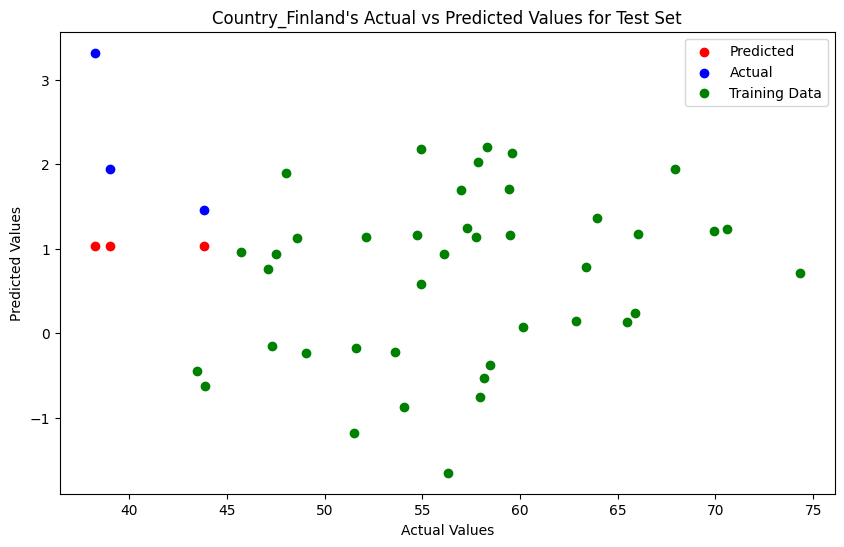

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.1551 - mae: 0.4903 - val_loss: 0.0087 - val_mae: 0.1248
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0515 - mae: 0.2769 - val_loss: 0.1175 - val_mae: 0.4835
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0669 - mae: 0.3183 - val_loss: 0.0427 - val_mae: 0.2900
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0197 - mae: 0.1594 - val_loss: 0.0062 - val_mae: 0.1055
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0412 - mae: 0.2383 - val_loss: 0.0448 - val_mae: 0.2972
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0308 - mae: 0.2081 - val_loss: 0.0017 - val_mae: 0.0458
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0285 - mae: 0.2050 - val_loss: 0.0110 - val_mae: 0.1436
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0200 - mae: 0.1713 - val_loss: 0.0097 - val_mae: 0.1339
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0258 - mae:

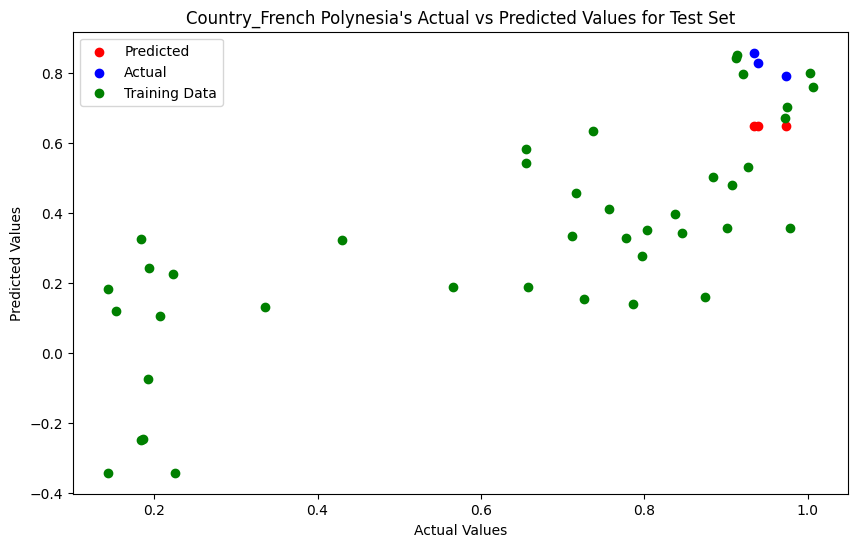

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.1127 - mae: 0.3801 - val_loss: 0.2939 - val_mae: 0.7587
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0694 - mae: 0.2769 - val_loss: 0.1258 - val_mae: 0.4895
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0808 - mae: 0.3347 - val_loss: 0.2456 - val_mae: 0.6925
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0809 - mae: 0.3245 - val_loss: 0.1224 - val_mae: 0.4827
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0560 - mae: 0.2854 - val_loss: 0.2270 - val_mae: 0.6651
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0849 - mae: 0.3263 - val_loss: 0.1311 - val_mae: 0.5007
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0851 - mae: 0.3613 - val_loss: 0.1753 - val_mae: 0.5825
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0815 - mae: 0.3302 - val_loss: 0.1965 - val_mae: 0.6182
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0876 - mae:

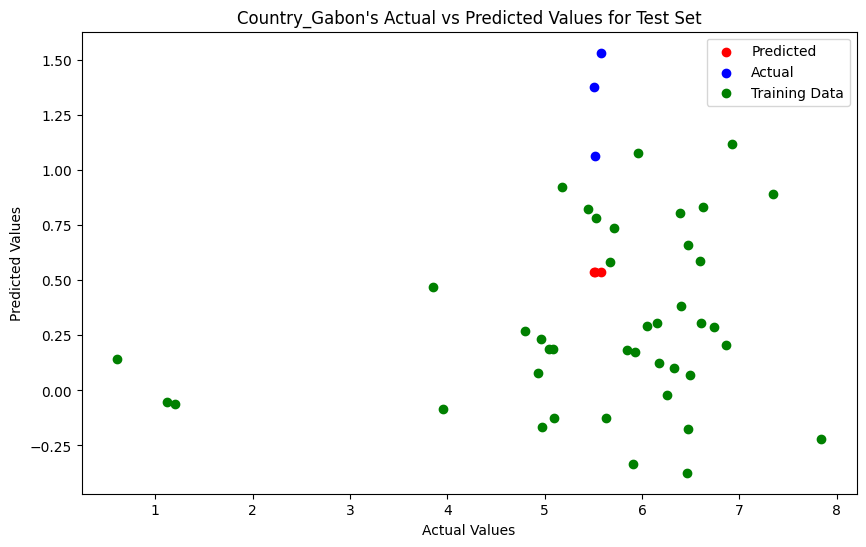

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - loss: 0.2909 - mae: 0.6910 - val_loss: 0.7486 - val_mae: 1.2403
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3091 - mae: 0.6834 - val_loss: 0.8941 - val_mae: 1.3939
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2883 - mae: 0.6858 - val_loss: 0.8404 - val_mae: 1.3386
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2562 - mae: 0.6307 - val_loss: 0.7598 - val_mae: 1.2526
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2611 - mae: 0.6378 - val_loss: 0.9344 - val_mae: 1.4344
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2792 - mae: 0.6606 - val_loss: 0.8439 - val_mae: 1.3423
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2276 - mae: 0.5947 - val_loss: 0.8137 - val_mae: 1.3106
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2346 - mae: 0.5898 - val_loss: 0.7430 - val_mae: 1.2341
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3050 - mae:

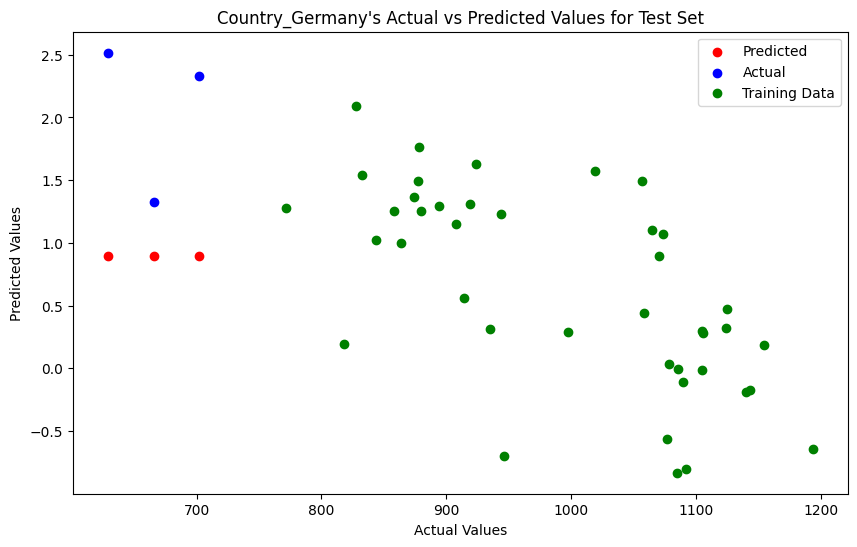

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0396 - mae: 0.2119 - val_loss: 0.0274 - val_mae: 0.1998
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0504 - mae: 0.2692 - val_loss: 0.0142 - val_mae: 0.1220
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0381 - mae: 0.2146 - val_loss: 0.0144 - val_mae: 0.1218
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0433 - mae: 0.2465 - val_loss: 0.0154 - val_mae: 0.1259
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0389 - mae: 0.2179 - val_loss: 0.0289 - val_mae: 0.2070
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0295 - mae: 0.1940 - val_loss: 0.0187 - val_mae: 0.1501
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0435 - mae: 0.2326 - val_loss: 0.0126 - val_mae: 0.1221
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0417 - mae: 0.2323 - val_loss: 0.0266 - val_mae: 0.1957
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0281 - mae:

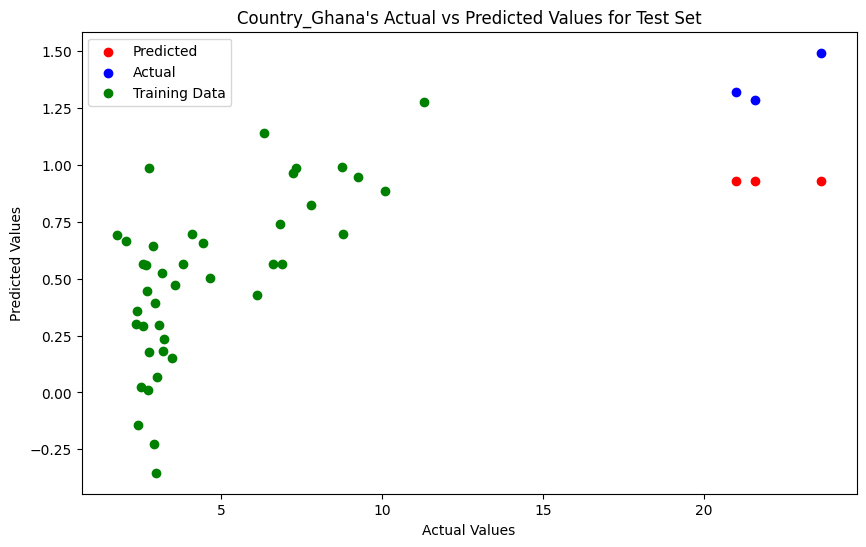

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - loss: 0.1156 - mae: 0.4045 - val_loss: 0.0145 - val_mae: 0.1693
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0737 - mae: 0.3091 - val_loss: 0.1002 - val_mae: 0.4473
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1252 - mae: 0.4236 - val_loss: 0.2577 - val_mae: 0.7176
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1084 - mae: 0.3732 - val_loss: 3.1884e-04 - val_mae: 0.0204
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0948 - mae: 0.3257 - val_loss: 0.0820 - val_mae: 0.4044
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0850 - mae: 0.3270 - val_loss: 0.0227 - val_mae: 0.2124
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0832 - mae: 0.3565 - val_loss: 0.4785 - val_mae: 0.9781
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1672 - mae: 0.5041 - val_loss: 0.0116 - val_mae: 0.1514
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0886 - 

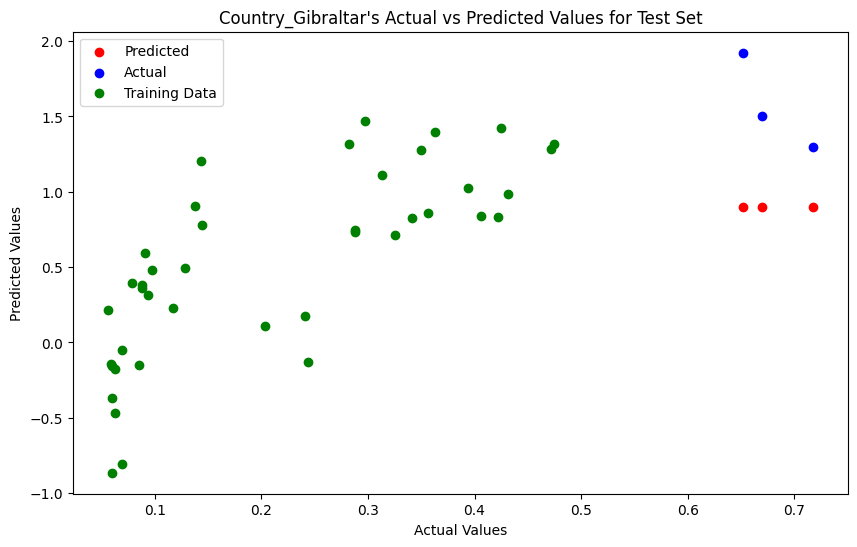

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - loss: 0.2173 - mae: 0.5778 - val_loss: 0.7031 - val_mae: 1.2031
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1576 - mae: 0.4529 - val_loss: 0.2889 - val_mae: 0.7561
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1592 - mae: 0.4185 - val_loss: 0.3211 - val_mae: 0.7975
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1439 - mae: 0.4517 - val_loss: 0.3487 - val_mae: 0.8314
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1720 - mae: 0.4818 - val_loss: 0.4074 - val_mae: 0.8992
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1465 - mae: 0.4358 - val_loss: 0.4024 - val_mae: 0.8937
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1767 - mae: 0.4957 - val_loss: 0.3032 - val_mae: 0.7748
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1970 - mae: 0.5085 - val_loss: 0.3210 - val_mae: 0.7975
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1255 - mae:

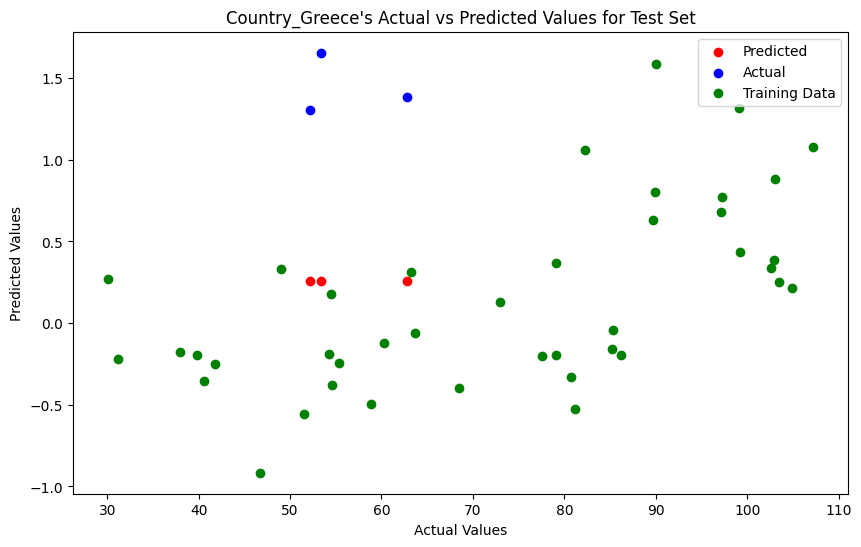

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.4580 - mae: 0.8614 - val_loss: 0.2752 - val_mae: 0.6337
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6170 - mae: 0.9887 - val_loss: 0.3130 - val_mae: 0.6418
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4564 - mae: 0.8435 - val_loss: 0.2123 - val_mae: 0.6157
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6055 - mae: 0.9813 - val_loss: 0.5108 - val_mae: 0.8681
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5612 - mae: 0.9836 - val_loss: 0.3666 - val_mae: 0.6305
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4600 - mae: 0.8818 - val_loss: 0.4453 - val_mae: 0.7528
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5066 - mae: 0.9150 - val_loss: 0.3406 - val_mae: 0.6224
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4894 - mae: 0.8756 - val_loss: 0.3176 - val_mae: 0.6178
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5099 - mae:

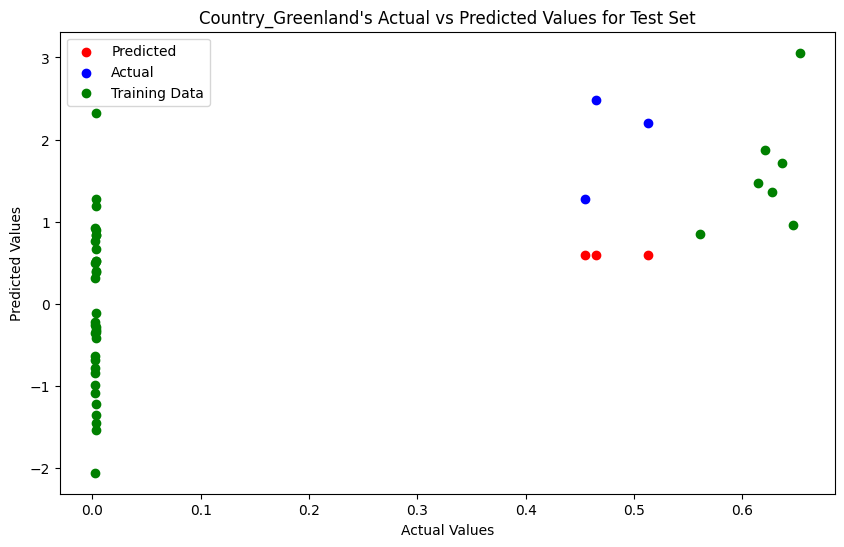

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0886 - mae: 0.3588 - val_loss: 0.0161 - val_mae: 0.1499
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0638 - mae: 0.2706 - val_loss: 0.0249 - val_mae: 0.2004
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0396 - mae: 0.2435 - val_loss: 0.0185 - val_mae: 0.1654
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0495 - mae: 0.2722 - val_loss: 0.0214 - val_mae: 0.1826
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0342 - mae: 0.2209 - val_loss: 0.0140 - val_mae: 0.1355
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0412 - mae: 0.2528 - val_loss: 0.0053 - val_mae: 0.0989
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0442 - mae: 0.2465 - val_loss: 0.0051 - val_mae: 0.0990
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0379 - mae: 0.2309 - val_loss: 0.0049 - val_mae: 0.0990
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0323 - mae:

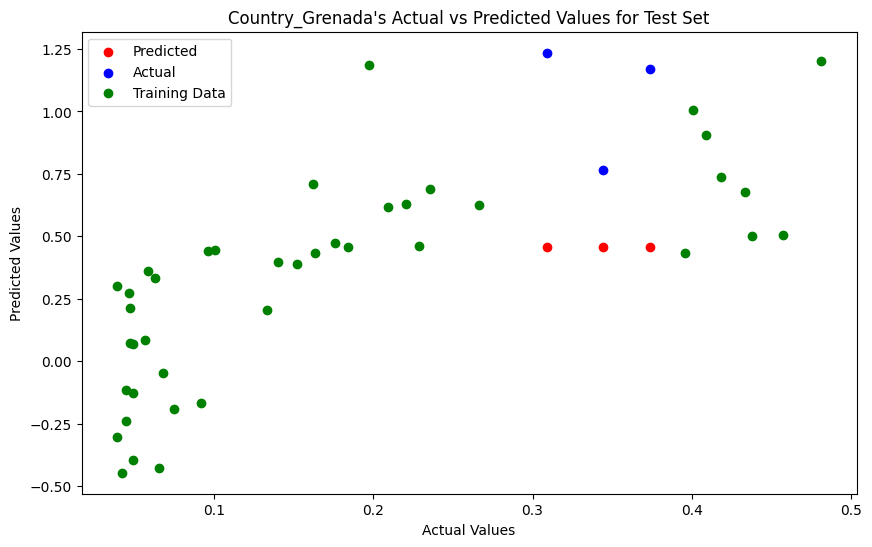

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 0.0956 - mae: 0.3398 - val_loss: 0.2336 - val_mae: 0.6725
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0563 - mae: 0.2560 - val_loss: 0.0747 - val_mae: 0.3651
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0512 - mae: 0.2507 - val_loss: 0.0587 - val_mae: 0.3138
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0373 - mae: 0.2134 - val_loss: 0.0192 - val_mae: 0.1421
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0394 - mae: 0.2335 - val_loss: 0.1118 - val_mae: 0.4531
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0344 - mae: 0.2060 - val_loss: 0.0283 - val_mae: 0.1933
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0361 - mae: 0.2142 - val_loss: 0.0370 - val_mae: 0.2282
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0405 - mae: 0.2322 - val_loss: 0.0921 - val_mae: 0.4041
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0377 - mae:

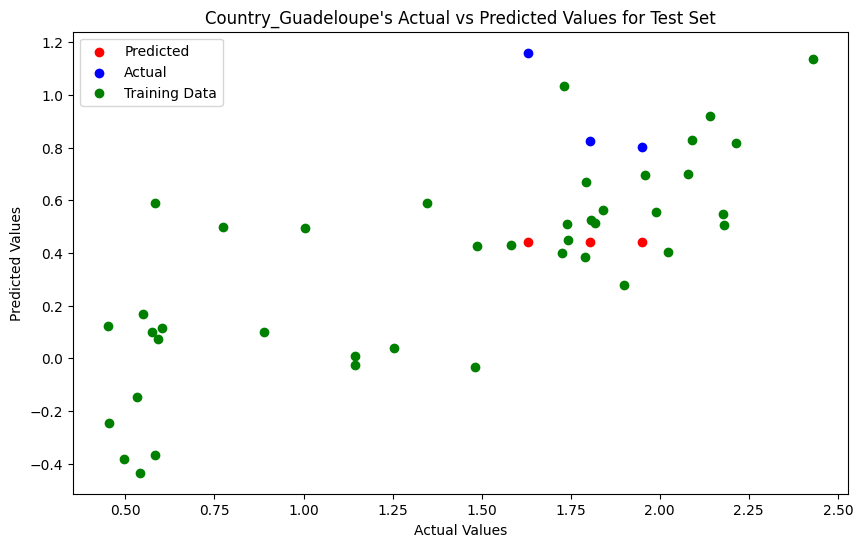

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - loss: 0.0467 - mae: 0.2592 - val_loss: 0.1695 - val_mae: 0.5247
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0394 - mae: 0.2171 - val_loss: 0.1335 - val_mae: 0.4509
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0316 - mae: 0.2103 - val_loss: 0.1037 - val_mae: 0.3791
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0364 - mae: 0.2192 - val_loss: 0.0557 - val_mae: 0.2521
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0302 - mae: 0.1871 - val_loss: 0.0350 - val_mae: 0.2521
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0482 - mae: 0.2478 - val_loss: 0.2014 - val_mae: 0.5823
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0568 - mae: 0.2960 - val_loss: 0.0782 - val_mae: 0.3045
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0363 - mae: 0.2019 - val_loss: 0.1249 - val_mae: 0.4314
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0369 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - loss: 0.2514 - mae: 0.5979 - val_loss: 0.0586 - val_mae: 0.3031
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0563 - mae: 0.2603 - val_loss: 0.0073 - val_mae: 0.1199
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0471 - mae: 0.2454 - val_loss: 0.1593 - val_mae: 0.5553
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0509 - mae: 0.2738 - val_loss: 0.0580 - val_mae: 0.3232
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0380 - mae: 0.2132 - val_loss: 0.0101 - val_mae: 0.1217
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0220 - mae: 0.1593 - val_loss: 0.0366 - val_mae: 0.2416
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0308 - mae: 0.1854 - val_loss: 0.0152 - val_mae: 0.1249
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0250 - mae: 0.1657 - val_loss: 0.0081 - val_mae: 0.1226
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0237 - mae:

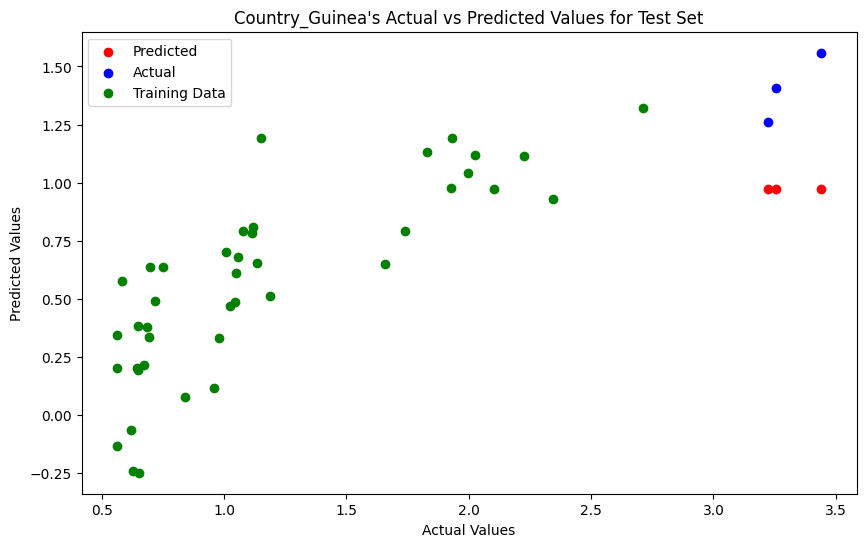

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 0.0541 - mae: 0.2505 - val_loss: 0.0036 - val_mae: 0.0836
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0408 - mae: 0.2261 - val_loss: 0.0242 - val_mae: 0.2198
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0345 - mae: 0.2070 - val_loss: 0.0011 - val_mae: 0.0445
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0253 - mae: 0.1836 - val_loss: 0.0058 - val_mae: 0.1067
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0365 - mae: 0.2138 - val_loss: 0.0018 - val_mae: 0.0582
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0373 - mae: 0.2157 - val_loss: 1.2135e-04 - val_mae: 0.0115
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0383 - mae: 0.2125 - val_loss: 5.1969e-04 - val_mae: 0.0301
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0287 - mae: 0.1928 - val_loss: 6.8574e-04 - val_mae: 0.0352
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.2203 - mae: 0.5092 - val_loss: 0.2440 - val_mae: 0.6834
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1134 - mae: 0.3784 - val_loss: 0.3697 - val_mae: 0.8490
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1400 - mae: 0.4368 - val_loss: 0.2357 - val_mae: 0.6720
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1466 - mae: 0.4405 - val_loss: 0.2640 - val_mae: 0.7123
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1029 - mae: 0.3619 - val_loss: 0.3258 - val_mae: 0.7943
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1214 - mae: 0.4050 - val_loss: 0.3118 - val_mae: 0.7765
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1383 - mae: 0.4478 - val_loss: 0.3224 - val_mae: 0.7903
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1162 - mae: 0.3977 - val_loss: 0.2672 - val_mae: 0.7166
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1458 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 0.0704 - mae: 0.3025 - val_loss: 0.1180 - val_mae: 0.4843
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0440 - mae: 0.2223 - val_loss: 0.0491 - val_mae: 0.3110
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0527 - mae: 0.2503 - val_loss: 0.0216 - val_mae: 0.2041
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0546 - mae: 0.2612 - val_loss: 0.0402 - val_mae: 0.2810
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0555 - mae: 0.2686 - val_loss: 0.1167 - val_mae: 0.4815
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0591 - mae: 0.2577 - val_loss: 0.0760 - val_mae: 0.3880
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0455 - mae: 0.2427 - val_loss: 0.0531 - val_mae: 0.3235
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0385 - mae: 0.2279 - val_loss: 0.0289 - val_mae: 0.2373
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0358 - mae:

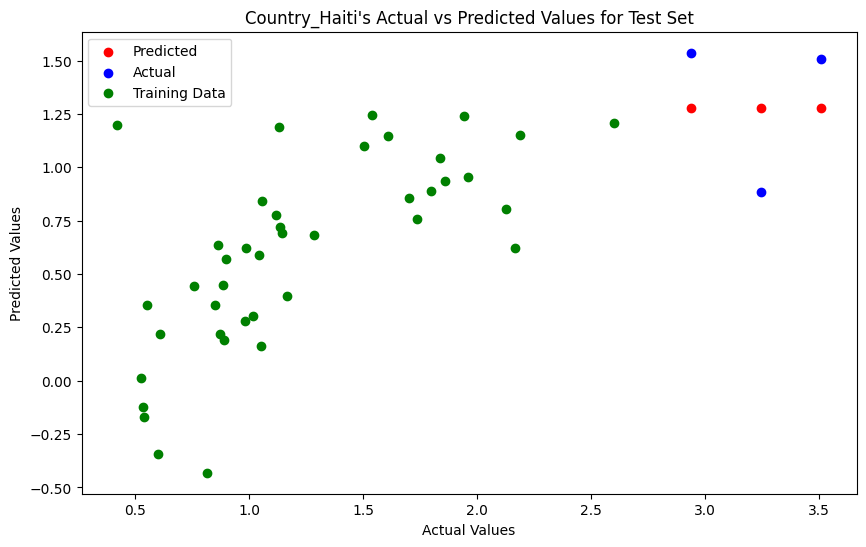

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.2115 - mae: 0.5480 - val_loss: 0.1826 - val_mae: 0.5587
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0584 - mae: 0.2811 - val_loss: 0.1605 - val_mae: 0.5174
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0556 - mae: 0.2818 - val_loss: 0.0478 - val_mae: 0.2309
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0506 - mae: 0.2725 - val_loss: 0.0663 - val_mae: 0.2817
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0362 - mae: 0.2299 - val_loss: 0.0744 - val_mae: 0.3089
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0314 - mae: 0.2157 - val_loss: 0.0477 - val_mae: 0.2308
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0307 - mae: 0.2019 - val_loss: 0.0663 - val_mae: 0.2816
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0322 - mae: 0.2121 - val_loss: 0.0663 - val_mae: 0.2816
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0375 - mae:

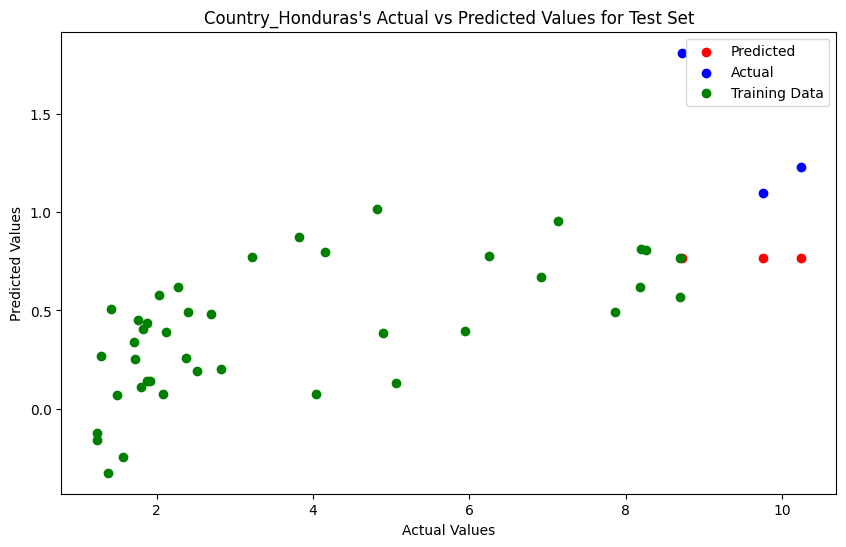

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.2436 - mae: 0.5875 - val_loss: 1.3249 - val_mae: 1.8249
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2895 - mae: 0.6340 - val_loss: 1.1492 - val_mae: 1.6492
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2373 - mae: 0.5701 - val_loss: 1.1012 - val_mae: 1.6012
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2703 - mae: 0.6252 - val_loss: 1.1418 - val_mae: 1.6418
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2708 - mae: 0.6143 - val_loss: 1.0135 - val_mae: 1.5135
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2898 - mae: 0.6358 - val_loss: 1.2407 - val_mae: 1.7407
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1988 - mae: 0.5347 - val_loss: 1.1114 - val_mae: 1.6114
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2679 - mae: 0.5847 - val_loss: 1.1325 - val_mae: 1.6325
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2279 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 0.2263 - mae: 0.5720 - val_loss: 0.5005 - val_mae: 0.8546
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2043 - mae: 0.4747 - val_loss: 0.2479 - val_mae: 0.6123
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1151 - mae: 0.3783 - val_loss: 0.2616 - val_mae: 0.6133
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1049 - mae: 0.3624 - val_loss: 0.1816 - val_mae: 0.5982
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1508 - mae: 0.4419 - val_loss: 0.5047 - val_mae: 0.8656
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2565 - mae: 0.5861 - val_loss: 0.3030 - val_mae: 0.6170
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1164 - mae: 0.3670 - val_loss: 0.3645 - val_mae: 0.6234
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1509 - mae: 0.4282 - val_loss: 0.1930 - val_mae: 0.5805
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1550 - mae:

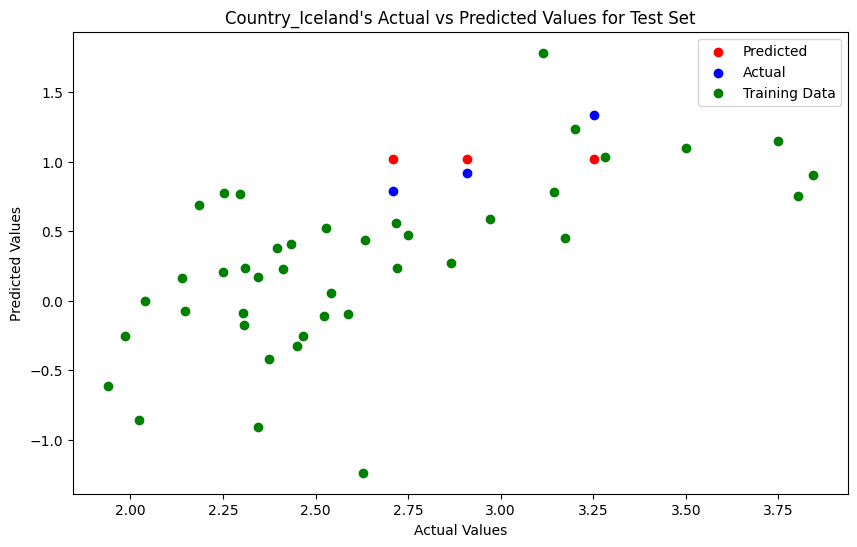

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.1730 - mae: 0.4732 - val_loss: 0.0345 - val_mae: 0.2467
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0582 - mae: 0.2732 - val_loss: 0.0788 - val_mae: 0.3864
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0726 - mae: 0.3024 - val_loss: 0.0498 - val_mae: 0.3024
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0614 - mae: 0.2780 - val_loss: 0.0683 - val_mae: 0.3585
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0676 - mae: 0.2984 - val_loss: 0.0862 - val_mae: 0.4052
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0611 - mae: 0.2643 - val_loss: 0.0352 - val_mae: 0.2494
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0659 - mae: 0.2974 - val_loss: 0.0668 - val_mae: 0.3540
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0634 - mae: 0.2879 - val_loss: 0.0763 - val_mae: 0.3799
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0519 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0456 - mae: 0.2436 - val_loss: 0.1556 - val_mae: 0.5576
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0272 - mae: 0.1913 - val_loss: 0.1294 - val_mae: 0.5085
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0381 - mae: 0.2057 - val_loss: 0.1218 - val_mae: 0.4934
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0355 - mae: 0.2138 - val_loss: 0.1012 - val_mae: 0.4497
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0264 - mae: 0.1772 - val_loss: 0.1480 - val_mae: 0.5439
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0286 - mae: 0.1973 - val_loss: 0.1211 - val_mae: 0.4919
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0371 - mae: 0.2145 - val_loss: 0.1406 - val_mae: 0.5301
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0340 - mae: 0.2016 - val_loss: 0.1378 - val_mae: 0.5248
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0363 - mae:

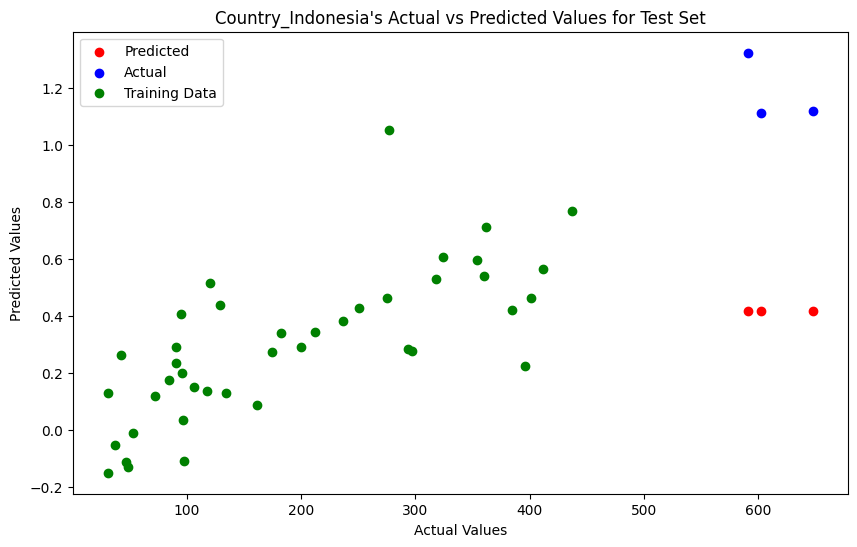

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 0.2373 - mae: 0.5638 - val_loss: 0.5990 - val_mae: 1.0755
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2431 - mae: 0.5764 - val_loss: 0.6121 - val_mae: 1.0909
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2931 - mae: 0.6294 - val_loss: 0.6375 - val_mae: 1.1203
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2411 - mae: 0.5942 - val_loss: 0.5258 - val_mae: 0.9866
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3038 - mae: 0.6847 - val_loss: 0.6011 - val_mae: 1.0778
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2150 - mae: 0.5193 - val_loss: 0.8009 - val_mae: 1.2991
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3628 - mae: 0.7082 - val_loss: 0.5039 - val_mae: 0.9591
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3760 - mae: 0.7599 - val_loss: 0.5501 - val_mae: 1.0166
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2786 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.1760 - mae: 0.4728 - val_loss: 0.2726 - val_mae: 0.5829
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1387 - mae: 0.4221 - val_loss: 0.2005 - val_mae: 0.4540
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1646 - mae: 0.4823 - val_loss: 0.1795 - val_mae: 0.4540
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1253 - mae: 0.4287 - val_loss: 0.1964 - val_mae: 0.4540
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1411 - mae: 0.4336 - val_loss: 0.2119 - val_mae: 0.4665
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1293 - mae: 0.4367 - val_loss: 0.1753 - val_mae: 0.4540
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1418 - mae: 0.4616 - val_loss: 0.2266 - val_mae: 0.4971
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1179 - mae: 0.4105 - val_loss: 0.1657 - val_mae: 0.4540
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1852 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0824 - mae: 0.3344 - val_loss: 0.1838 - val_mae: 0.5989
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0641 - mae: 0.3009 - val_loss: 0.2188 - val_mae: 0.6549
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0758 - mae: 0.3235 - val_loss: 0.2921 - val_mae: 0.7585
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0691 - mae: 0.2978 - val_loss: 0.1398 - val_mae: 0.5204
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0710 - mae: 0.2976 - val_loss: 0.2910 - val_mae: 0.7572
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0748 - mae: 0.3166 - val_loss: 0.2116 - val_mae: 0.6438
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0901 - mae: 0.3521 - val_loss: 0.2447 - val_mae: 0.6933
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0856 - mae: 0.3379 - val_loss: 0.2336 - val_mae: 0.6772
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0732 - mae:

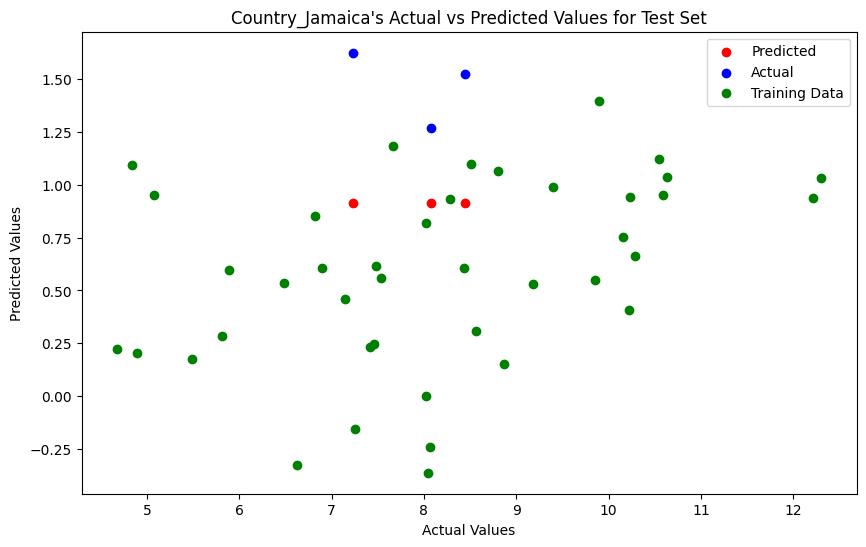

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - loss: 0.2423 - mae: 0.5505 - val_loss: 0.2473 - val_mae: 0.6899
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1254 - mae: 0.3950 - val_loss: 0.0161 - val_mae: 0.1365
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1843 - mae: 0.5217 - val_loss: 0.1312 - val_mae: 0.4937
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1489 - mae: 0.4536 - val_loss: 0.0318 - val_mae: 0.2121
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1263 - mae: 0.4125 - val_loss: 0.1333 - val_mae: 0.4981
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1230 - mae: 0.4068 - val_loss: 0.0601 - val_mae: 0.3188
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1175 - mae: 0.4026 - val_loss: 0.0977 - val_mae: 0.4205
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1395 - mae: 0.4415 - val_loss: 0.0681 - val_mae: 0.3428
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2027 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.1871 - mae: 0.5196 - val_loss: 0.7166 - val_mae: 1.2138
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1928 - mae: 0.4973 - val_loss: 0.2315 - val_mae: 0.6000
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2395 - mae: 0.5714 - val_loss: 0.4892 - val_mae: 0.9559
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1400 - mae: 0.4324 - val_loss: 0.2613 - val_mae: 0.6478
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1671 - mae: 0.4471 - val_loss: 0.7674 - val_mae: 1.2667
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2186 - mae: 0.5488 - val_loss: 0.2973 - val_mae: 0.7013
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2945 - mae: 0.6221 - val_loss: 0.4306 - val_mae: 0.8825
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2744 - mae: 0.5847 - val_loss: 0.5320 - val_mae: 1.0074
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1612 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0514 - mae: 0.2564 - val_loss: 0.0169 - val_mae: 0.1837
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0632 - mae: 0.2815 - val_loss: 0.1176 - val_mae: 0.4845
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0495 - mae: 0.2520 - val_loss: 0.0204 - val_mae: 0.1908
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0446 - mae: 0.2543 - val_loss: 0.0036 - val_mae: 0.0703
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0309 - mae: 0.2176 - val_loss: 0.0026 - val_mae: 0.0705
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0255 - mae: 0.1845 - val_loss: 0.0126 - val_mae: 0.1420
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0281 - mae: 0.1856 - val_loss: 0.0107 - val_mae: 0.1284
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0245 - mae: 0.1737 - val_loss: 0.0291 - val_mae: 0.2304
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0313 - mae: 

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - loss: 0.0708 - mae: 0.2684 - val_loss: 0.1106 - val_mae: 0.4650
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0506 - mae: 0.2362 - val_loss: 0.2425 - val_mae: 0.6928
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0516 - mae: 0.2471 - val_loss: 0.0236 - val_mae: 0.2055
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1608 - mae: 0.5104 - val_loss: 0.0894 - val_mae: 0.4172
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0592 - mae: 0.2640 - val_loss: 0.1487 - val_mae: 0.5409
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0635 - mae: 0.2515 - val_loss: 0.3557 - val_mae: 0.8406
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0780 - mae: 0.3002 - val_loss: 0.0626 - val_mae: 0.3471
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0777 - mae: 0.3052 - val_loss: 0.2458 - val_mae: 0.6978
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0543 - mae:

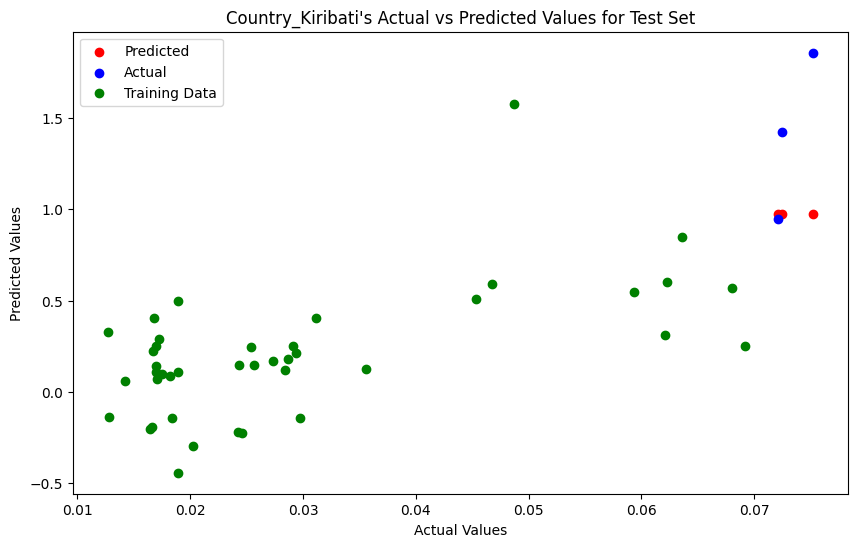

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.2669 - mae: 0.6453 - val_loss: 0.9494 - val_mae: 1.4494
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2819 - mae: 0.6257 - val_loss: 0.5282 - val_mae: 1.0018
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3002 - mae: 0.6657 - val_loss: 0.7504 - val_mae: 1.2489
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2590 - mae: 0.6149 - val_loss: 0.5397 - val_mae: 1.0155
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3103 - mae: 0.6997 - val_loss: 0.6395 - val_mae: 1.1298
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2500 - mae: 0.5875 - val_loss: 0.8980 - val_mae: 1.3980
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3366 - mae: 0.6870 - val_loss: 0.6481 - val_mae: 1.1393
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3829 - mae: 0.7835 - val_loss: 0.5042 - val_mae: 0.9729
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2836 - mae:

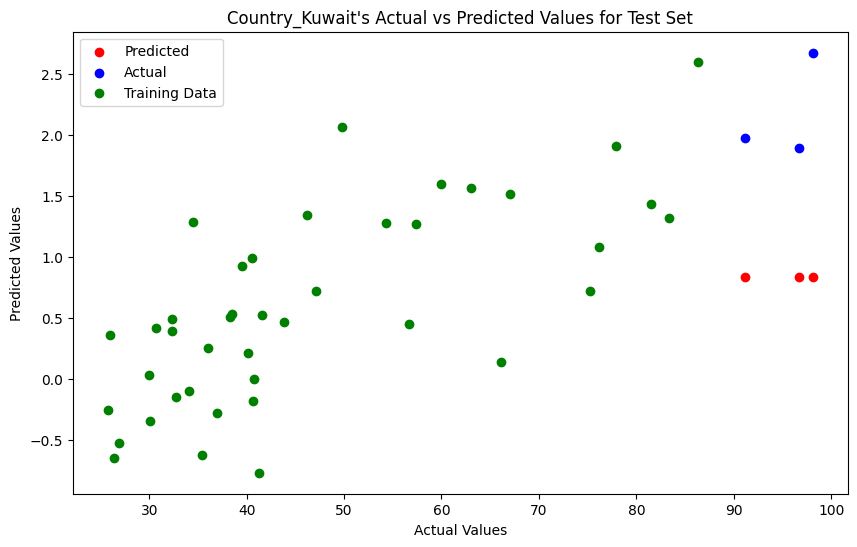

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.2454 - mae: 0.5798 - val_loss: 0.5054 - val_mae: 0.9984
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1808 - mae: 0.4742 - val_loss: 0.3661 - val_mae: 0.8394
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1487 - mae: 0.3974 - val_loss: 0.1692 - val_mae: 0.5576
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0830 - mae: 0.3042 - val_loss: 0.0784 - val_mae: 0.3594
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1058 - mae: 0.3468 - val_loss: 0.2408 - val_mae: 0.6739
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1159 - mae: 0.3759 - val_loss: 0.0604 - val_mae: 0.3053
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2074 - mae: 0.5287 - val_loss: 0.1523 - val_mae: 0.5264
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1790 - mae: 0.4382 - val_loss: 0.4179 - val_mae: 0.9003
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1256 - mae:

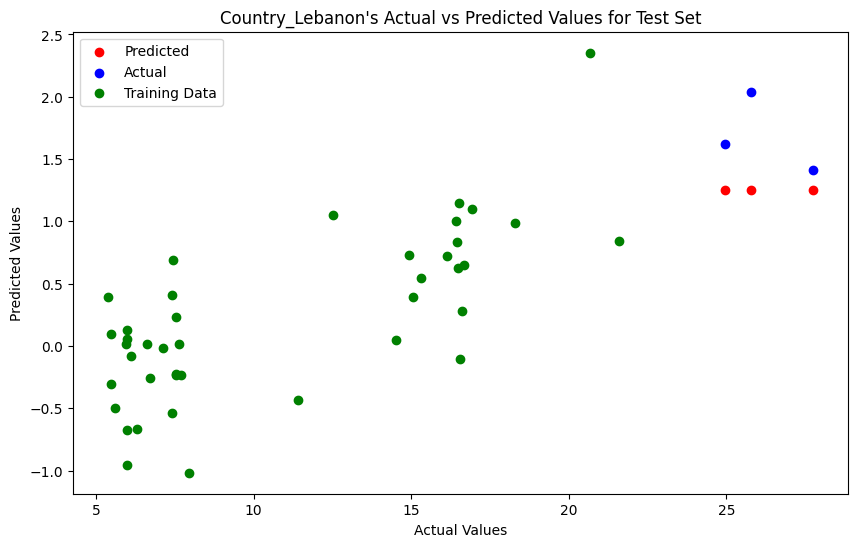

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 0.3738 - mae: 0.7576 - val_loss: 0.3635 - val_mae: 0.8232
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0764 - mae: 0.3001 - val_loss: 0.3338 - val_mae: 0.7778
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0792 - mae: 0.3048 - val_loss: 0.2197 - val_mae: 0.5918
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0426 - mae: 0.2479 - val_loss: 0.1105 - val_mae: 0.3479
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0597 - mae: 0.2630 - val_loss: 0.2917 - val_mae: 0.6703
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0277 - mae: 0.1826 - val_loss: 0.1795 - val_mae: 0.4712
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0454 - mae: 0.2469 - val_loss: 0.1038 - val_mae: 0.3252
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0498 - mae: 0.2413 - val_loss: 0.2997 - val_mae: 0.6969
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0249 - mae:

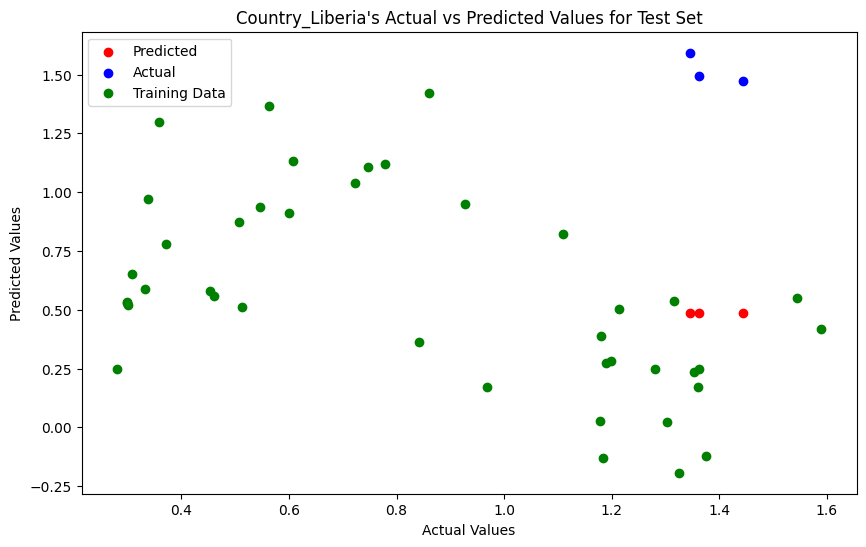

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 646ms/step - loss: 0.1065 - mae: 0.3731 - val_loss: 0.3498 - val_mae: 0.7950
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1399 - mae: 0.4308 - val_loss: 0.1373 - val_mae: 0.4533
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.1338 - mae: 0.4043 - val_loss: 0.1364 - val_mae: 0.4512
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.1108 - mae: 0.4005 - val_loss: 0.2262 - val_mae: 0.6191
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.1759 - mae: 0.4924 - val_loss: 0.1719 - val_mae: 0.5242
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0865 - mae: 0.3025 - val_loss: 0.1776 - val_mae: 0.5398
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.1252 - mae: 0.3546 - val_loss: 0.0445 - val_mae: 0.2630
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1866 - mae: 0.4497 - val_loss: 0.4320 - val_mae: 0.8989
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1695 - ma

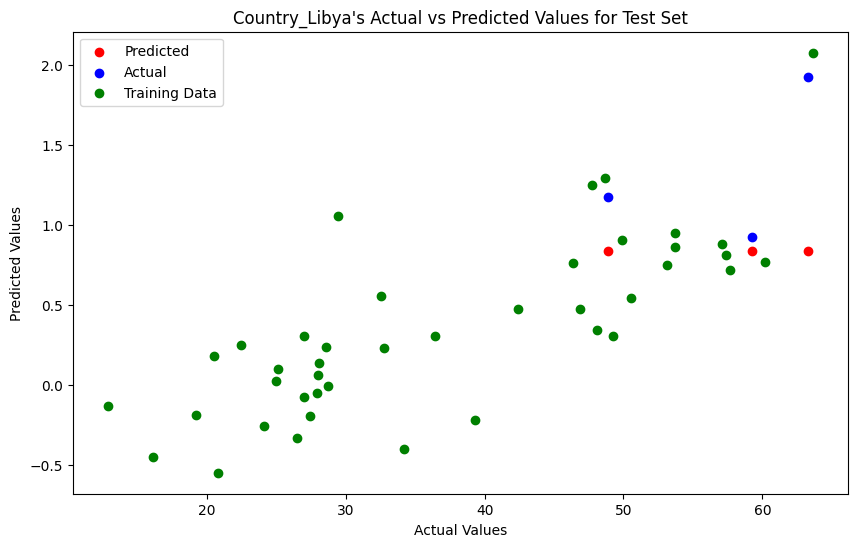

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.1576 - mae: 0.4695 - val_loss: 0.0037 - val_mae: 0.0845
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1026 - mae: 0.3658 - val_loss: 0.3163 - val_mae: 0.7937
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1218 - mae: 0.4469 - val_loss: 0.1521 - val_mae: 0.5501
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0634 - mae: 0.2949 - val_loss: 0.0218 - val_mae: 0.2084
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0739 - mae: 0.3342 - val_loss: 0.0363 - val_mae: 0.2685
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0502 - mae: 0.2503 - val_loss: 0.0600 - val_mae: 0.3451
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0584 - mae: 0.3020 - val_loss: 0.0364 - val_mae: 0.2669
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0622 - mae: 0.2854 - val_loss: 0.4195 - val_mae: 0.9148
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1357 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - loss: 0.0630 - mae: 0.2930 - val_loss: 0.3416 - val_mae: 0.8221
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0356 - mae: 0.2125 - val_loss: 0.3410 - val_mae: 0.8213
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0417 - mae: 0.2024 - val_loss: 0.1678 - val_mae: 0.5728
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0358 - mae: 0.2125 - val_loss: 0.1934 - val_mae: 0.6159
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0284 - mae: 0.1873 - val_loss: 0.3266 - val_mae: 0.8036
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0307 - mae: 0.1940 - val_loss: 0.1837 - val_mae: 0.6000
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0354 - mae: 0.2194 - val_loss: 0.3039 - val_mae: 0.7748
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0410 - mae: 0.2172 - val_loss: 0.2896 - val_mae: 0.7561
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0412 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - loss: 0.0437 - mae: 0.2322 - val_loss: 0.0927 - val_mae: 0.4185
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0482 - mae: 0.2588 - val_loss: 0.0357 - val_mae: 0.2432
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0840 - mae: 0.3324 - val_loss: 0.0340 - val_mae: 0.2373
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0406 - mae: 0.2338 - val_loss: 0.1142 - val_mae: 0.4667
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0296 - mae: 0.1955 - val_loss: 0.0466 - val_mae: 0.2834
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0275 - mae: 0.1883 - val_loss: 0.0730 - val_mae: 0.3653
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0285 - mae: 0.1968 - val_loss: 0.1078 - val_mae: 0.4528
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0326 - mae: 0.2156 - val_loss: 0.0526 - val_mae: 0.3068
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0273 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - loss: 0.1014 - mae: 0.3831 - val_loss: 0.0132 - val_mae: 0.1624
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0837 - mae: 0.3569 - val_loss: 0.0159 - val_mae: 0.1611
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1066 - mae: 0.3932 - val_loss: 0.0417 - val_mae: 0.2449
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0630 - mae: 0.2990 - val_loss: 0.0441 - val_mae: 0.2630
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0626 - mae: 0.2931 - val_loss: 0.0642 - val_mae: 0.3320
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0475 - mae: 0.2413 - val_loss: 0.0249 - val_mae: 0.1801
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0713 - mae: 0.3222 - val_loss: 0.0270 - val_mae: 0.1907
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0583 - mae: 0.2975 - val_loss: 0.0743 - val_mae: 0.3603
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0659 - mae:

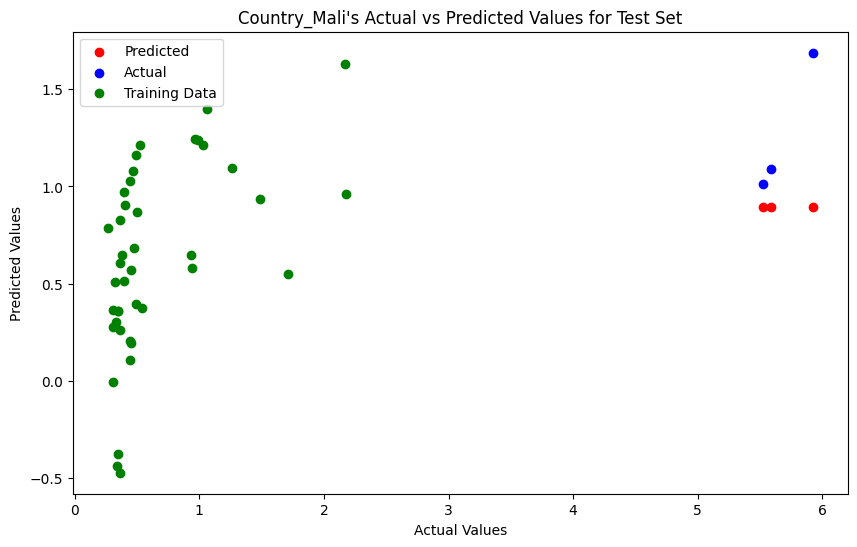

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.1755 - mae: 0.4689 - val_loss: 0.1787 - val_mae: 0.5852
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1218 - mae: 0.4280 - val_loss: 0.2554 - val_mae: 0.7094
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1163 - mae: 0.4166 - val_loss: 0.1037 - val_mae: 0.4527
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0900 - mae: 0.3398 - val_loss: 0.3426 - val_mae: 0.8277
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1377 - mae: 0.4205 - val_loss: 0.2386 - val_mae: 0.6891
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1401 - mae: 0.4620 - val_loss: 0.0582 - val_mae: 0.3355
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1391 - mae: 0.4240 - val_loss: 0.0994 - val_mae: 0.4415
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0760 - mae: 0.3348 - val_loss: 0.2432 - val_mae: 0.6972
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1025 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0554 - mae: 0.2709 - val_loss: 0.0456 - val_mae: 0.2824
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0517 - mae: 0.2342 - val_loss: 0.0585 - val_mae: 0.3254
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0526 - mae: 0.2646 - val_loss: 0.0084 - val_mae: 0.1055
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0329 - mae: 0.2053 - val_loss: 0.0058 - val_mae: 0.1059
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0497 - mae: 0.2601 - val_loss: 0.0269 - val_mae: 0.2070
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0221 - mae: 0.1580 - val_loss: 0.0098 - val_mae: 0.1065
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0327 - mae: 0.2151 - val_loss: 0.0104 - val_mae: 0.1046
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0388 - mae: 0.2231 - val_loss: 0.0217 - val_mae: 0.1804
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0348 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0575 - mae: 0.2947 - val_loss: 0.2053 - val_mae: 0.6283
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0304 - mae: 0.2108 - val_loss: 0.1093 - val_mae: 0.4507
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0464 - mae: 0.2573 - val_loss: 0.0691 - val_mae: 0.3502
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0660 - mae: 0.2783 - val_loss: 0.0944 - val_mae: 0.4161
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0273 - mae: 0.1860 - val_loss: 0.0623 - val_mae: 0.3299
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0228 - mae: 0.1811 - val_loss: 0.0801 - val_mae: 0.3800
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0300 - mae: 0.2004 - val_loss: 0.0670 - val_mae: 0.3440
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0272 - mae: 0.1915 - val_loss: 0.0444 - val_mae: 0.2707
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0292 - mae:

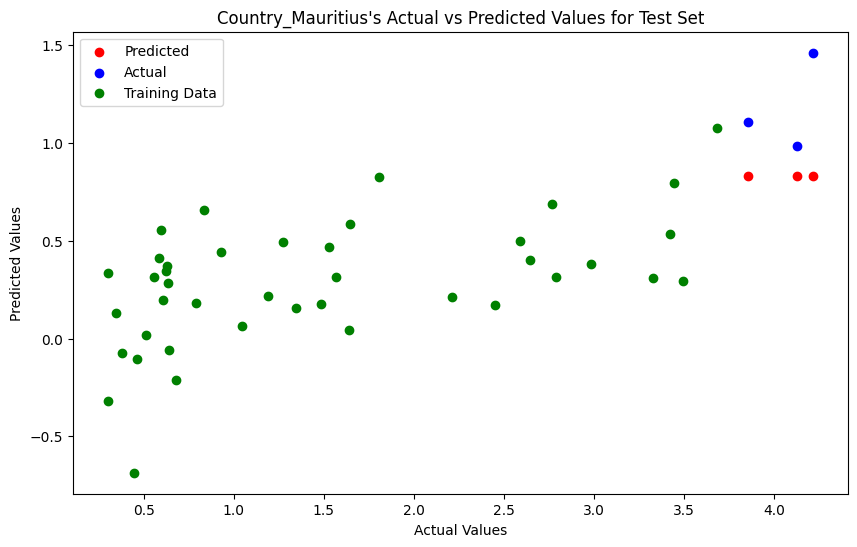

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0973 - mae: 0.3488 - val_loss: 0.3949 - val_mae: 0.8813
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0744 - mae: 0.3027 - val_loss: 0.1661 - val_mae: 0.5647
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0683 - mae: 0.3081 - val_loss: 0.3388 - val_mae: 0.8151
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0572 - mae: 0.2810 - val_loss: 0.1426 - val_mae: 0.5215
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0721 - mae: 0.3167 - val_loss: 0.2891 - val_mae: 0.7517
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0775 - mae: 0.3295 - val_loss: 0.2586 - val_mae: 0.7099
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0672 - mae: 0.3055 - val_loss: 0.2428 - val_mae: 0.6873
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0607 - mae: 0.2810 - val_loss: 0.1945 - val_mae: 0.6130
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0650 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.3552 - mae: 0.7381 - val_loss: 0.4592 - val_mae: 0.9515
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1860 - mae: 0.5120 - val_loss: 0.6722 - val_mae: 1.1722
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2441 - mae: 0.5880 - val_loss: 0.6103 - val_mae: 1.1102
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2707 - mae: 0.6312 - val_loss: 0.4850 - val_mae: 0.9797
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2026 - mae: 0.5523 - val_loss: 0.7078 - val_mae: 1.2078
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2340 - mae: 0.5914 - val_loss: 0.5867 - val_mae: 1.0863
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2204 - mae: 0.5576 - val_loss: 0.5354 - val_mae: 1.0333
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2329 - mae: 0.5796 - val_loss: 0.4783 - val_mae: 0.9725
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2902 - mae:

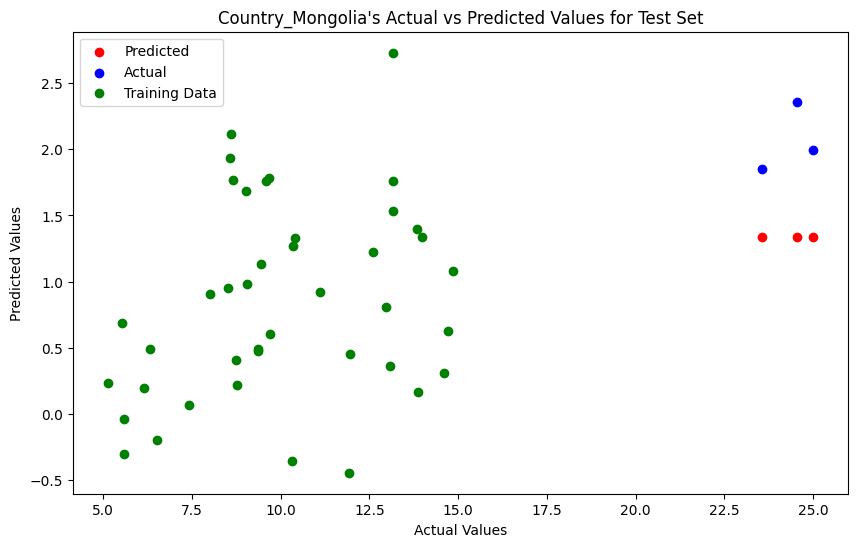

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - loss: 0.2302 - mae: 0.5347 - val_loss: 0.5471 - val_mae: 1.0362
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2169 - mae: 0.5301 - val_loss: 0.1384 - val_mae: 0.4661
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1722 - mae: 0.4867 - val_loss: 0.2909 - val_mae: 0.7227
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1378 - mae: 0.4362 - val_loss: 0.0808 - val_mae: 0.3193
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0934 - mae: 0.3160 - val_loss: 0.0300 - val_mae: 0.2440
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0764 - mae: 0.3092 - val_loss: 0.1398 - val_mae: 0.4689
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1161 - mae: 0.3816 - val_loss: 0.1128 - val_mae: 0.4076
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1284 - mae: 0.3809 - val_loss: 0.2667 - val_mae: 0.6884
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1456 - mae:

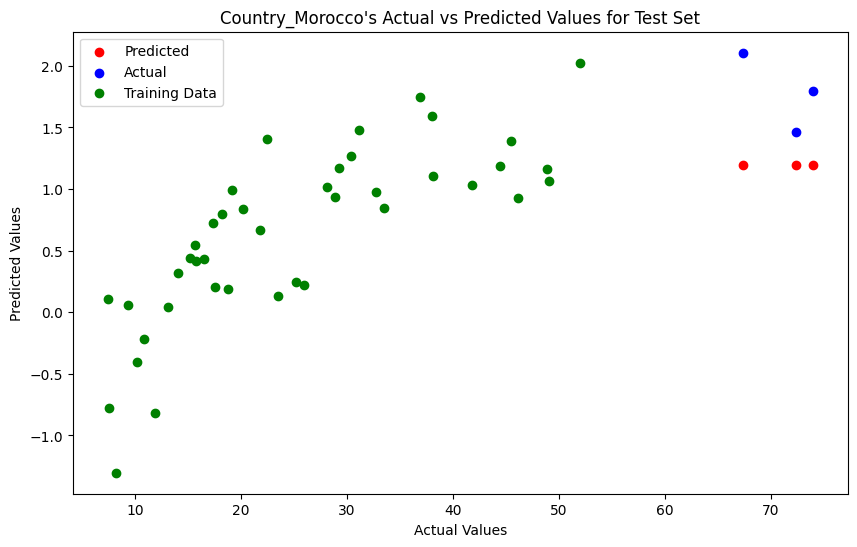

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.1638 - mae: 0.4872 - val_loss: 0.2407 - val_mae: 0.5720
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1346 - mae: 0.4197 - val_loss: 0.0888 - val_mae: 0.3834
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2171 - mae: 0.5567 - val_loss: 0.0931 - val_mae: 0.3866
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1247 - mae: 0.4301 - val_loss: 0.0779 - val_mae: 0.3874
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1209 - mae: 0.3869 - val_loss: 0.0975 - val_mae: 0.3870
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0940 - mae: 0.3602 - val_loss: 0.0814 - val_mae: 0.3873
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0878 - mae: 0.3448 - val_loss: 0.0786 - val_mae: 0.3870
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0886 - mae: 0.3436 - val_loss: 0.0750 - val_mae: 0.3871
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1108 - mae:

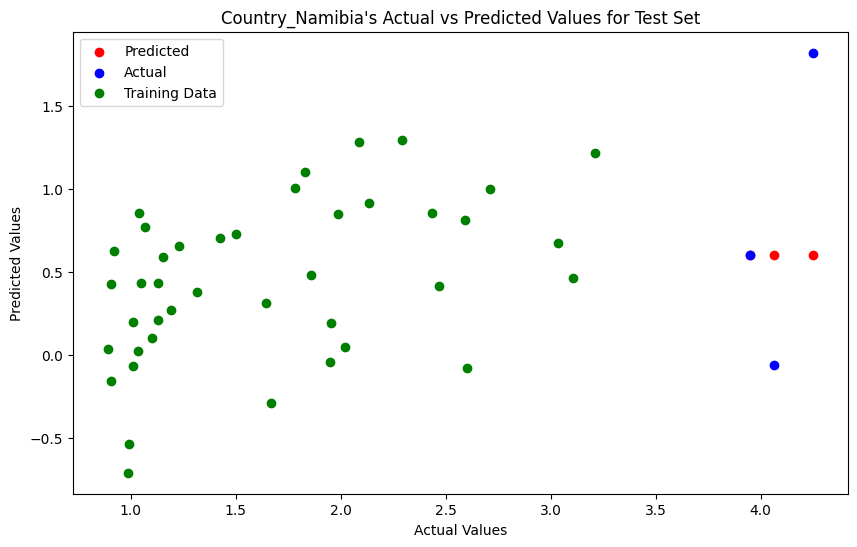

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0661 - mae: 0.2715 - val_loss: 0.0650 - val_mae: 0.3308
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0714 - mae: 0.3047 - val_loss: 0.0166 - val_mae: 0.1683
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0563 - mae: 0.2674 - val_loss: 0.0412 - val_mae: 0.2264
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0465 - mae: 0.2483 - val_loss: 0.0186 - val_mae: 0.1625
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0510 - mae: 0.2718 - val_loss: 0.0259 - val_mae: 0.1704
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0415 - mae: 0.2188 - val_loss: 0.0265 - val_mae: 0.1777
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0361 - mae: 0.1921 - val_loss: 0.0359 - val_mae: 0.2009
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0317 - mae: 0.2184 - val_loss: 0.0272 - val_mae: 0.1785
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0212 - mae:

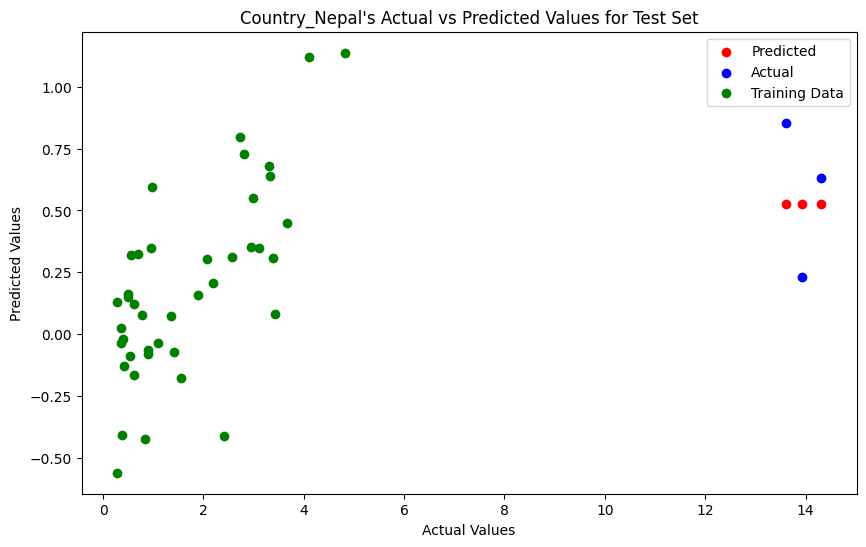

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.3166 - mae: 0.7168 - val_loss: 0.6557 - val_mae: 1.0774
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3157 - mae: 0.6824 - val_loss: 0.7513 - val_mae: 1.2045
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3036 - mae: 0.6910 - val_loss: 0.6999 - val_mae: 1.1376
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2518 - mae: 0.6268 - val_loss: 0.6701 - val_mae: 1.0973
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2777 - mae: 0.6474 - val_loss: 0.7838 - val_mae: 1.2454
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2814 - mae: 0.6600 - val_loss: 0.6874 - val_mae: 1.1208
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2509 - mae: 0.6212 - val_loss: 0.7059 - val_mae: 1.1455
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2274 - mae: 0.5731 - val_loss: 0.6519 - val_mae: 1.0722
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3500 - mae:

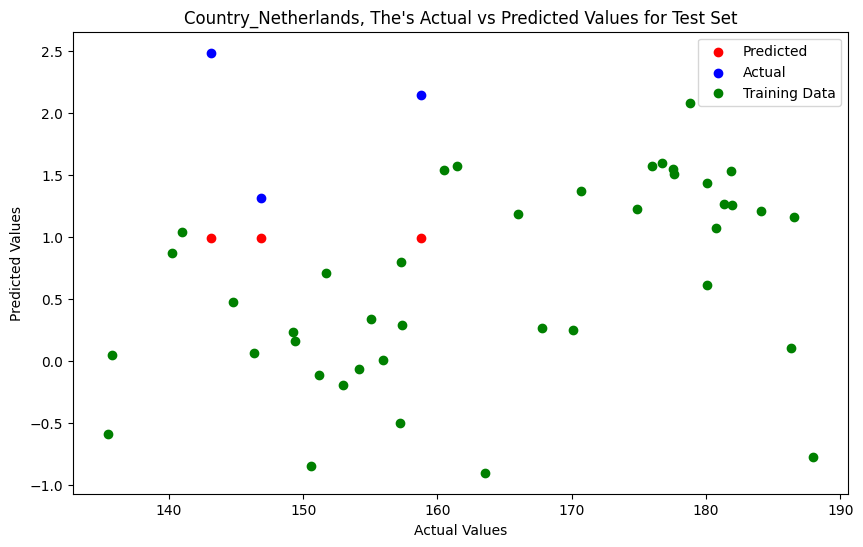

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 0.1179 - mae: 0.3963 - val_loss: 0.0535 - val_mae: 0.3108
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1049 - mae: 0.3811 - val_loss: 0.0069 - val_mae: 0.1032
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0713 - mae: 0.2865 - val_loss: 0.0100 - val_mae: 0.1028
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0753 - mae: 0.2607 - val_loss: 0.0060 - val_mae: 0.1039
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0612 - mae: 0.2714 - val_loss: 0.0195 - val_mae: 0.1683
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0558 - mae: 0.2588 - val_loss: 0.0070 - val_mae: 0.1033
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0644 - mae: 0.2947 - val_loss: 0.0056 - val_mae: 0.1034
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0616 - mae: 0.2732 - val_loss: 0.0288 - val_mae: 0.2167
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0625 - mae:

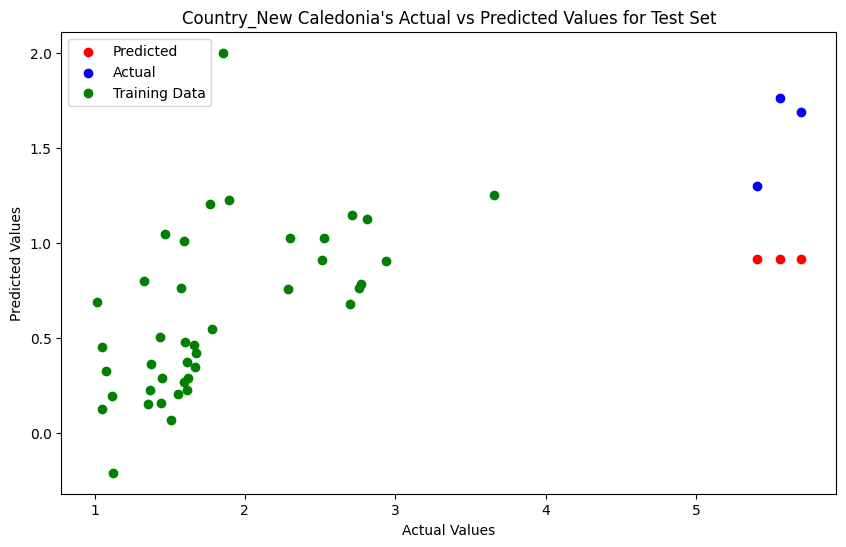

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.1533 - mae: 0.4603 - val_loss: 0.3002 - val_mae: 0.7748
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1068 - mae: 0.3825 - val_loss: 4.0965e-04 - val_mae: 0.0260
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0707 - mae: 0.2998 - val_loss: 0.1118 - val_mae: 0.4727
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0666 - mae: 0.2915 - val_loss: 0.0049 - val_mae: 0.0978
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0683 - mae: 0.2913 - val_loss: 0.0524 - val_mae: 0.3236
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0451 - mae: 0.2239 - val_loss: 1.0377e-04 - val_mae: 0.0144
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1109 - mae: 0.3701 - val_loss: 0.0333 - val_mae: 0.2577
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0932 - mae: 0.3317 - val_loss: 0.0521 - val_mae: 0.3226
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.066

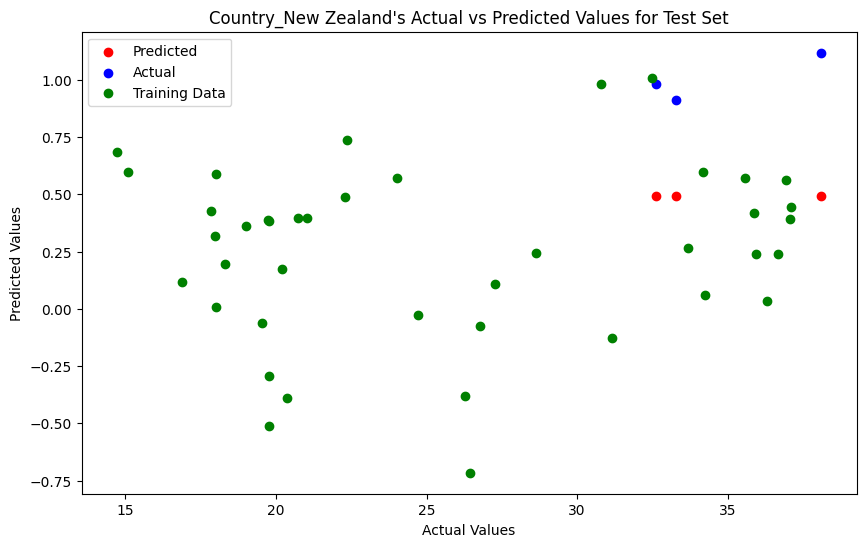

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - loss: 0.0827 - mae: 0.3620 - val_loss: 0.1382 - val_mae: 0.5145
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0434 - mae: 0.2531 - val_loss: 0.0776 - val_mae: 0.3788
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0465 - mae: 0.2669 - val_loss: 0.0574 - val_mae: 0.3213
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0396 - mae: 0.2271 - val_loss: 0.0247 - val_mae: 0.1941
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0492 - mae: 0.2549 - val_loss: 0.0418 - val_mae: 0.2680
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0519 - mae: 0.2661 - val_loss: 0.0937 - val_mae: 0.4193
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0547 - mae: 0.2841 - val_loss: 0.0444 - val_mae: 0.2779
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0383 - mae: 0.2212 - val_loss: 0.0654 - val_mae: 0.3453
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0455 - mae:

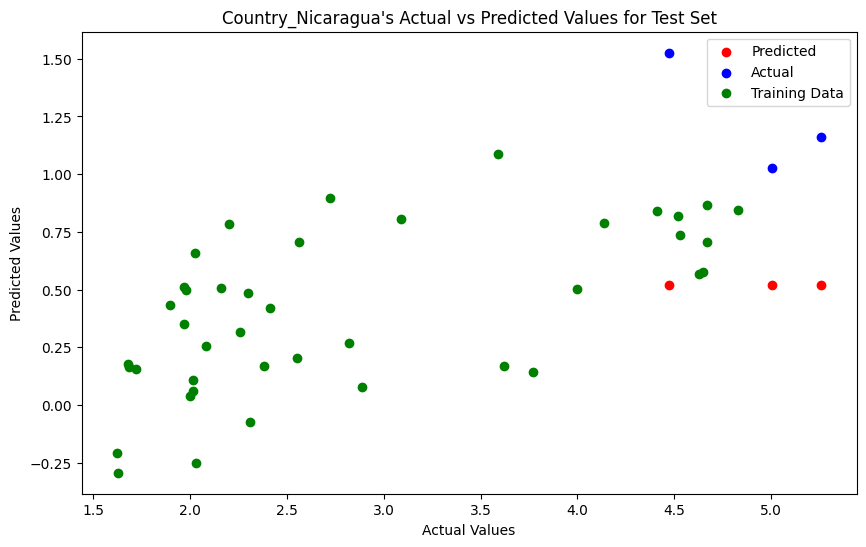

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - loss: 0.0816 - mae: 0.3136 - val_loss: 0.1188 - val_mae: 0.4823
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0704 - mae: 0.3018 - val_loss: 0.0333 - val_mae: 0.2515
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0992 - mae: 0.3274 - val_loss: 0.0123 - val_mae: 0.1440
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0689 - mae: 0.2569 - val_loss: 0.0083 - val_mae: 0.1078
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0924 - mae: 0.3419 - val_loss: 0.0073 - val_mae: 0.0952
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0584 - mae: 0.2750 - val_loss: 0.0036 - val_mae: 0.0674
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0916 - mae: 0.3548 - val_loss: 0.0022 - val_mae: 0.0647
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0864 - mae: 0.3420 - val_loss: 0.0028 - val_mae: 0.0609
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1253 - mae:

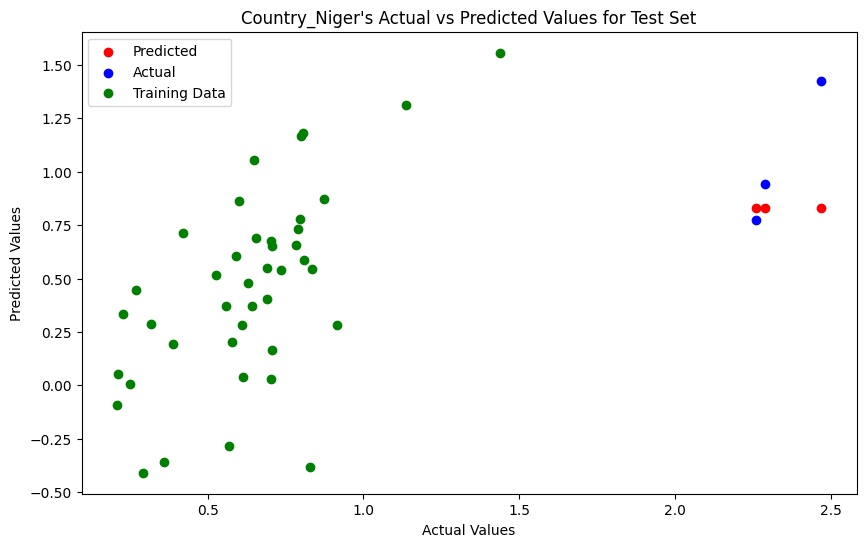

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - loss: 0.0734 - mae: 0.2892 - val_loss: 0.3377 - val_mae: 0.8171
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0621 - mae: 0.2668 - val_loss: 0.0783 - val_mae: 0.3859
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0963 - mae: 0.3494 - val_loss: 0.2196 - val_mae: 0.6569
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0619 - mae: 0.2733 - val_loss: 0.1645 - val_mae: 0.5669
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0730 - mae: 0.2850 - val_loss: 0.1293 - val_mae: 0.5010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0615 - mae: 0.2693 - val_loss: 0.2004 - val_mae: 0.6271
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1028 - mae: 0.3644 - val_loss: 0.1645 - val_mae: 0.5669
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0868 - mae: 0.3136 - val_loss: 0.1687 - val_mae: 0.5743
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0781 - mae:

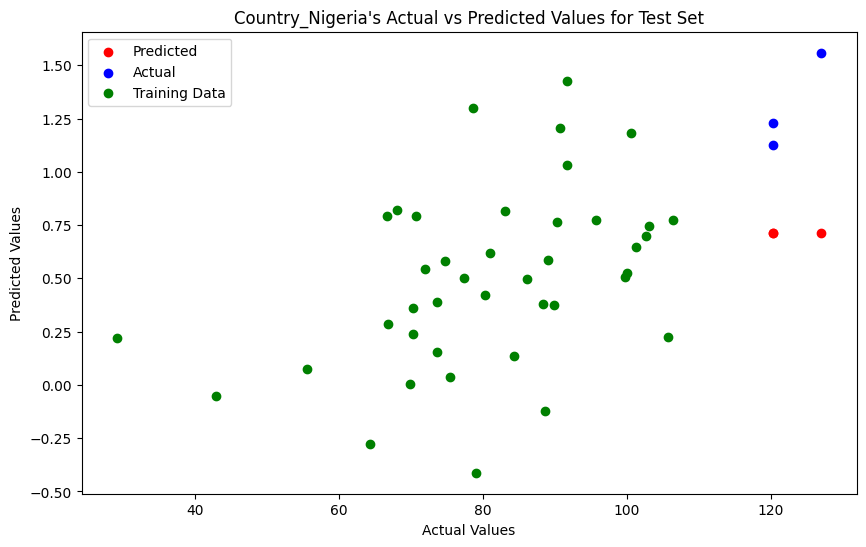

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - loss: 0.2912 - mae: 0.6567 - val_loss: 0.9758 - val_mae: 1.4758
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2974 - mae: 0.6701 - val_loss: 0.9700 - val_mae: 1.4700
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2928 - mae: 0.6585 - val_loss: 0.9163 - val_mae: 1.4163
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2540 - mae: 0.5912 - val_loss: 0.8299 - val_mae: 1.3299
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2885 - mae: 0.6503 - val_loss: 1.0525 - val_mae: 1.5525
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2626 - mae: 0.6490 - val_loss: 0.9933 - val_mae: 1.4933
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2929 - mae: 0.6607 - val_loss: 0.8899 - val_mae: 1.3899
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2883 - mae: 0.6655 - val_loss: 0.8805 - val_mae: 1.3805
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3212 - mae:

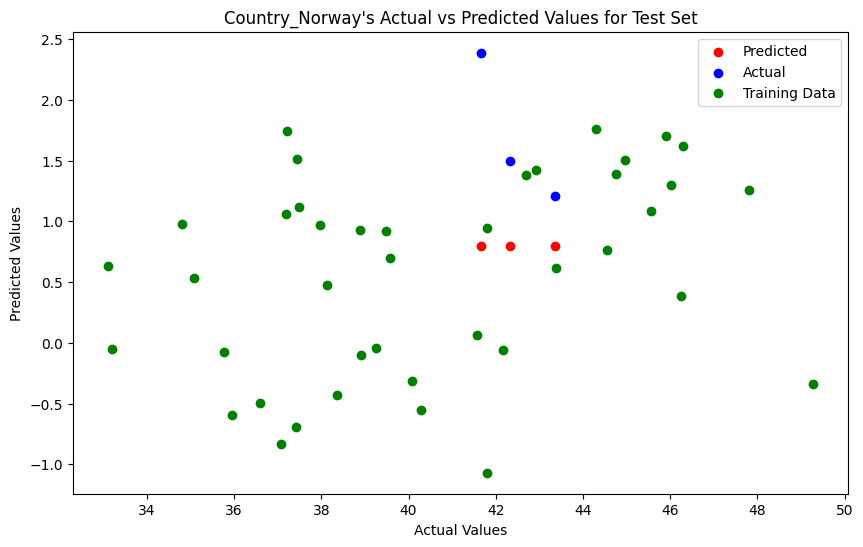

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.2406 - mae: 0.5622 - val_loss: 0.3025 - val_mae: 0.6884
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0931 - mae: 0.3559 - val_loss: 0.1613 - val_mae: 0.4360
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0915 - mae: 0.3514 - val_loss: 0.1471 - val_mae: 0.4020
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0504 - mae: 0.2605 - val_loss: 0.1137 - val_mae: 0.3640
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0758 - mae: 0.3215 - val_loss: 0.1597 - val_mae: 0.4323
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1013 - mae: 0.4040 - val_loss: 0.1839 - val_mae: 0.4850
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0637 - mae: 0.2886 - val_loss: 0.1180 - val_mae: 0.3640
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1040 - mae: 0.3550 - val_loss: 0.2127 - val_mae: 0.5413
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0707 - mae:

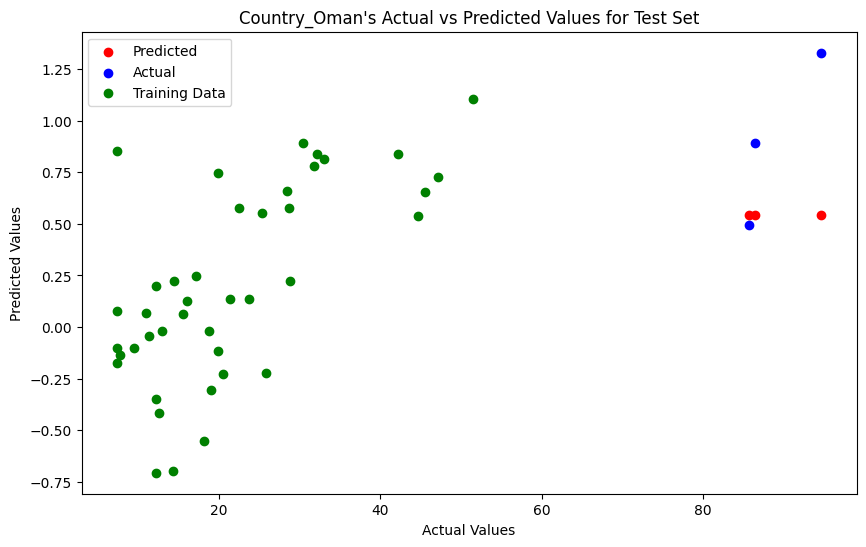

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 0.1553 - mae: 0.4766 - val_loss: 0.0042 - val_mae: 0.0855
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0952 - mae: 0.3550 - val_loss: 0.0680 - val_mae: 0.3577
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1381 - mae: 0.4452 - val_loss: 0.0187 - val_mae: 0.1733
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1289 - mae: 0.4308 - val_loss: 0.0140 - val_mae: 0.1438
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1151 - mae: 0.4143 - val_loss: 0.0476 - val_mae: 0.2964
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1426 - mae: 0.4629 - val_loss: 0.0247 - val_mae: 0.2052
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1432 - mae: 0.4486 - val_loss: 0.0128 - val_mae: 0.1351
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1410 - mae: 0.4419 - val_loss: 0.0369 - val_mae: 0.2578
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1407 - mae:

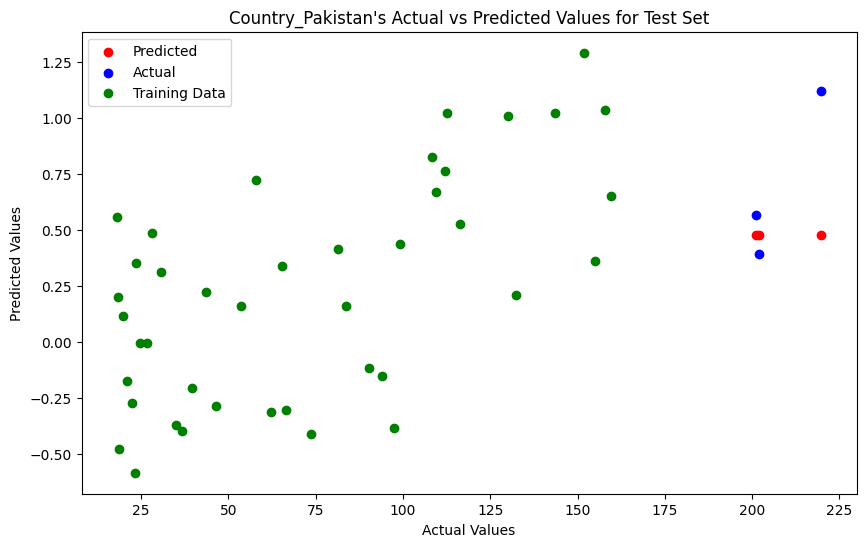

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.1034 - mae: 0.3533 - val_loss: 0.1477 - val_mae: 0.5331
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0436 - mae: 0.2425 - val_loss: 0.1906 - val_mae: 0.6098
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0532 - mae: 0.2585 - val_loss: 0.0766 - val_mae: 0.3824
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0445 - mae: 0.2437 - val_loss: 0.0385 - val_mae: 0.2641
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0544 - mae: 0.2494 - val_loss: 0.1126 - val_mae: 0.4655
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0445 - mae: 0.2366 - val_loss: 0.1238 - val_mae: 0.4882
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0540 - mae: 0.2840 - val_loss: 0.0640 - val_mae: 0.3433
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0419 - mae: 0.2248 - val_loss: 0.1352 - val_mae: 0.5103
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0493 - mae:

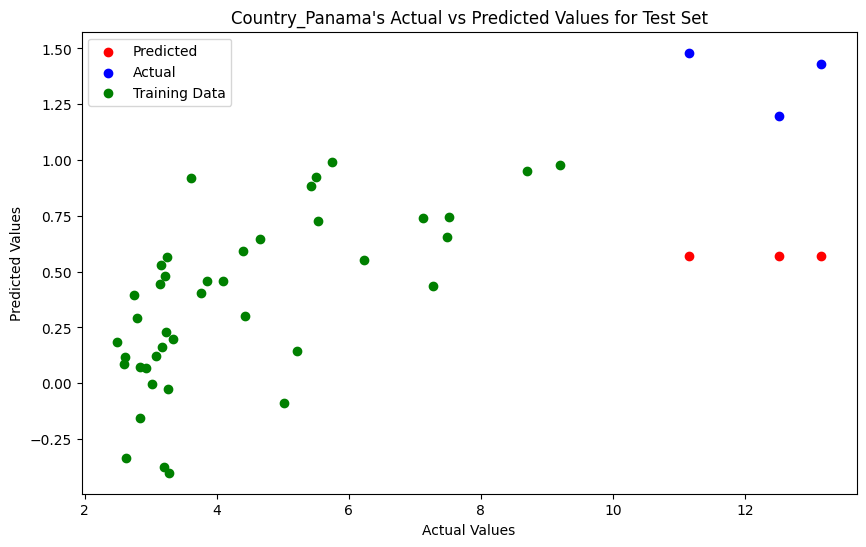

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 0.0423 - mae: 0.2365 - val_loss: 0.0279 - val_mae: 0.1982
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0334 - mae: 0.2278 - val_loss: 0.0185 - val_mae: 0.1498
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0314 - mae: 0.1980 - val_loss: 0.0341 - val_mae: 0.2304
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0216 - mae: 0.1530 - val_loss: 0.0341 - val_mae: 0.2306
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0168 - mae: 0.1476 - val_loss: 0.0471 - val_mae: 0.2802
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0224 - mae: 0.1629 - val_loss: 0.0251 - val_mae: 0.1879
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0350 - mae: 0.2146 - val_loss: 0.0357 - val_mae: 0.2371
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0242 - mae: 0.1767 - val_loss: 0.0215 - val_mae: 0.1675
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0132 - mae:

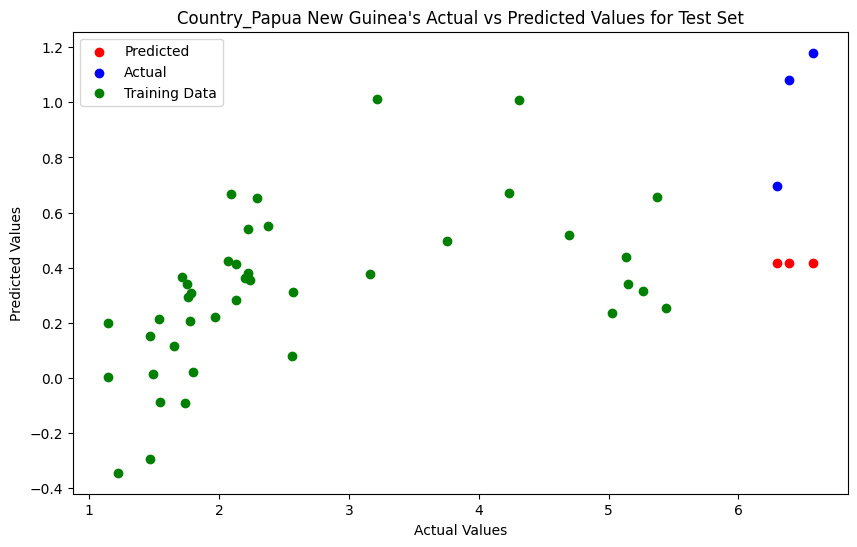

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0787 - mae: 0.3376 - val_loss: 0.3845 - val_mae: 0.8572
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0670 - mae: 0.3131 - val_loss: 0.4213 - val_mae: 0.9006
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0599 - mae: 0.2888 - val_loss: 0.3311 - val_mae: 0.7913
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0432 - mae: 0.2346 - val_loss: 0.3000 - val_mae: 0.7510
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0740 - mae: 0.3302 - val_loss: 0.4126 - val_mae: 0.8903
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0760 - mae: 0.3250 - val_loss: 0.4190 - val_mae: 0.8980
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0831 - mae: 0.3158 - val_loss: 0.4778 - val_mae: 0.9656
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0726 - mae: 0.3158 - val_loss: 0.3167 - val_mae: 0.7735
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0712 - mae:

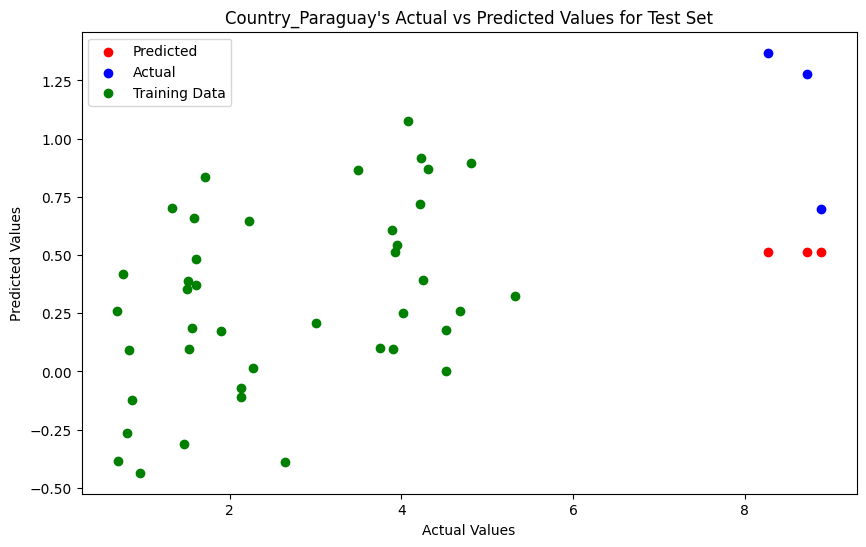

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0815 - mae: 0.3380 - val_loss: 0.2550 - val_mae: 0.6893
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0769 - mae: 0.3068 - val_loss: 0.1606 - val_mae: 0.5351
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0714 - mae: 0.3117 - val_loss: 0.2459 - val_mae: 0.6761
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0607 - mae: 0.2798 - val_loss: 0.1305 - val_mae: 0.4755
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0752 - mae: 0.3141 - val_loss: 0.1643 - val_mae: 0.5420
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0564 - mae: 0.2727 - val_loss: 0.1082 - val_mae: 0.4262
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0728 - mae: 0.3198 - val_loss: 0.0959 - val_mae: 0.3963
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0760 - mae: 0.3068 - val_loss: 0.1375 - val_mae: 0.4901
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0687 - mae:

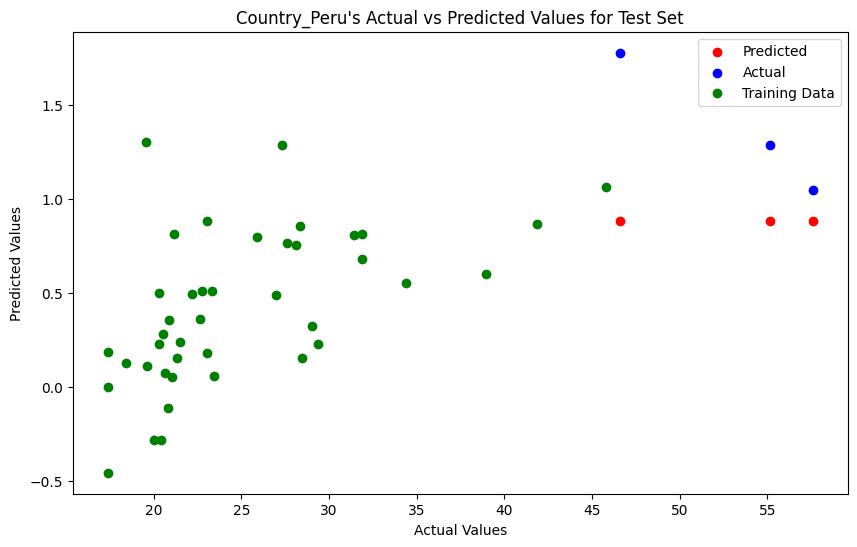

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0436 - mae: 0.2492 - val_loss: 0.0846 - val_mae: 0.3996
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0360 - mae: 0.2188 - val_loss: 0.1202 - val_mae: 0.4805
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0379 - mae: 0.2073 - val_loss: 0.1108 - val_mae: 0.4604
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0248 - mae: 0.1618 - val_loss: 0.0318 - val_mae: 0.2325
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0291 - mae: 0.1850 - val_loss: 0.0445 - val_mae: 0.2820
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0307 - mae: 0.1917 - val_loss: 0.0935 - val_mae: 0.4212
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0295 - mae: 0.1981 - val_loss: 0.0512 - val_mae: 0.3048
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0297 - mae: 0.1881 - val_loss: 0.0745 - val_mae: 0.3735
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0206 - mae:

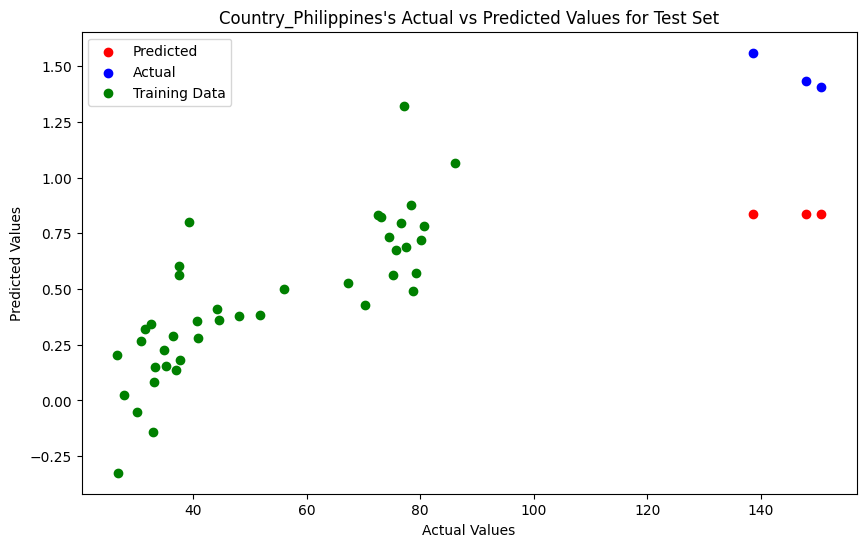

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.1740 - mae: 0.4976 - val_loss: 0.0851 - val_mae: 0.4117
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1248 - mae: 0.4339 - val_loss: 0.3500 - val_mae: 0.8362
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1563 - mae: 0.4352 - val_loss: 0.1406 - val_mae: 0.5296
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1403 - mae: 0.4496 - val_loss: 0.0692 - val_mae: 0.3711
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1058 - mae: 0.3838 - val_loss: 0.1115 - val_mae: 0.4713
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1162 - mae: 0.4049 - val_loss: 0.3512 - val_mae: 0.8377
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1342 - mae: 0.4037 - val_loss: 0.1740 - val_mae: 0.5893
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1004 - mae: 0.3762 - val_loss: 0.4268 - val_mae: 0.9216
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1097 - mae:

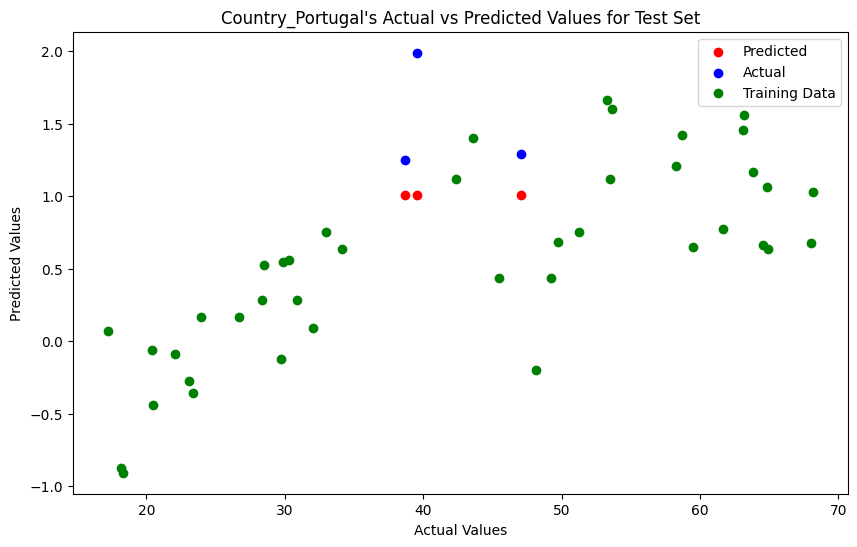

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 0.1206 - mae: 0.4126 - val_loss: 0.0816 - val_mae: 0.3765
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0475 - mae: 0.2320 - val_loss: 0.0120 - val_mae: 0.1295
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0464 - mae: 0.2484 - val_loss: 0.0101 - val_mae: 0.1203
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0400 - mae: 0.2366 - val_loss: 0.0120 - val_mae: 0.1203
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0308 - mae: 0.1987 - val_loss: 0.0070 - val_mae: 0.1172
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0362 - mae: 0.2198 - val_loss: 0.0182 - val_mae: 0.1520
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0536 - mae: 0.2494 - val_loss: 0.0142 - val_mae: 0.1240
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0403 - mae: 0.2309 - val_loss: 0.0134 - val_mae: 0.1174
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0309 - mae:

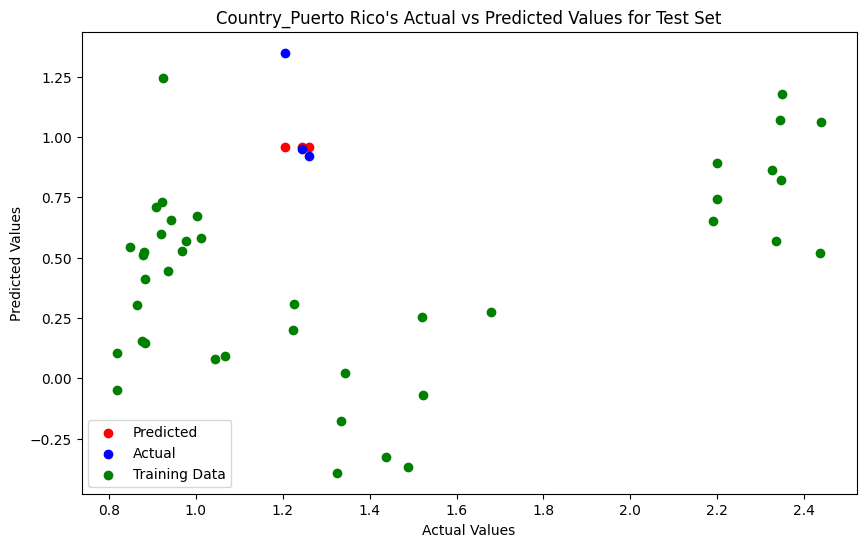

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.1763 - mae: 0.5171 - val_loss: 0.7063 - val_mae: 1.2063
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1288 - mae: 0.4317 - val_loss: 0.2943 - val_mae: 0.7364
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1692 - mae: 0.5036 - val_loss: 0.2136 - val_mae: 0.6172
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1491 - mae: 0.4069 - val_loss: 0.2734 - val_mae: 0.7075
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1373 - mae: 0.4269 - val_loss: 0.0272 - val_mae: 0.2150
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2050 - mae: 0.5115 - val_loss: 0.2082 - val_mae: 0.6084
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1609 - mae: 0.4732 - val_loss: 0.1079 - val_mae: 0.4118
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1226 - mae: 0.3993 - val_loss: 0.6194 - val_mae: 1.1170
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1381 - mae:

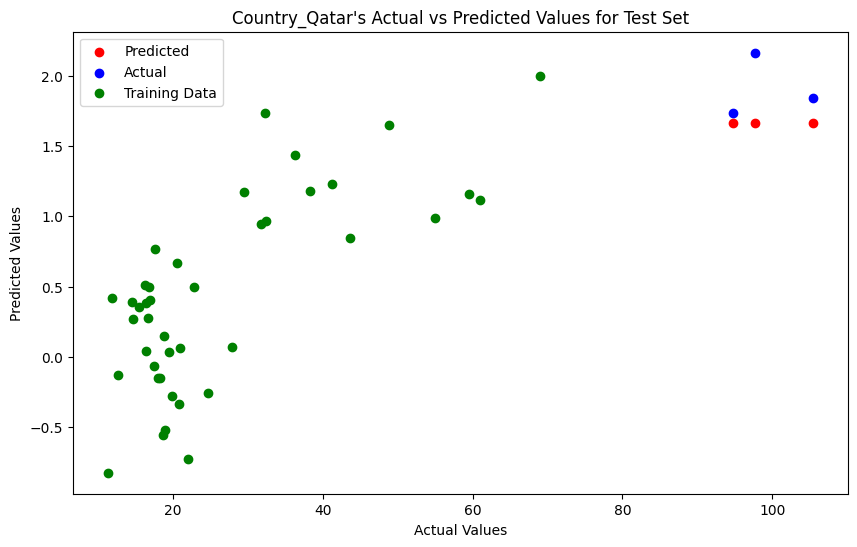

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.4775 - mae: 0.8812 - val_loss: 0.5321 - val_mae: 1.0299
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3143 - mae: 0.6770 - val_loss: 0.8254 - val_mae: 1.3254
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2584 - mae: 0.5896 - val_loss: 0.8074 - val_mae: 1.3074
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2919 - mae: 0.6675 - val_loss: 0.5712 - val_mae: 1.0705
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3572 - mae: 0.7245 - val_loss: 1.0625 - val_mae: 1.5625
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3590 - mae: 0.7033 - val_loss: 0.5976 - val_mae: 1.0974
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2896 - mae: 0.6354 - val_loss: 0.7460 - val_mae: 1.2460
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2981 - mae: 0.6459 - val_loss: 1.0179 - val_mae: 1.5179
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2971 - mae:

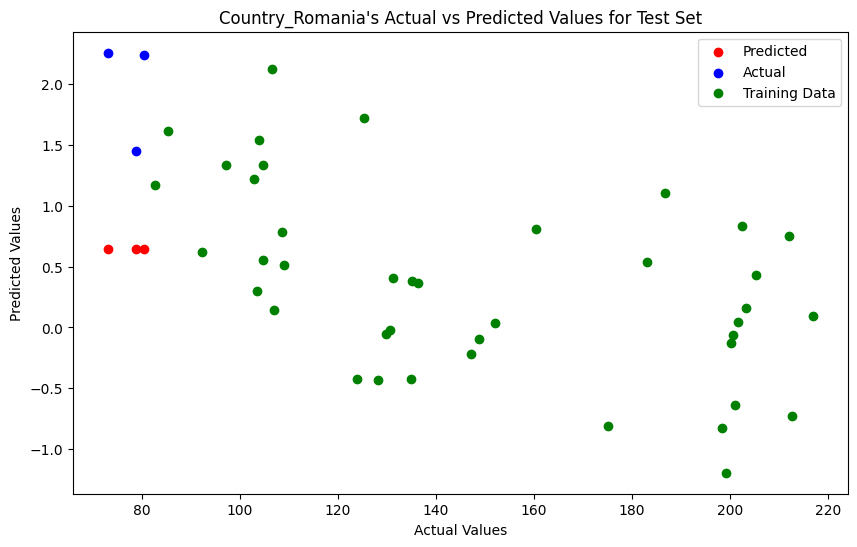

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.4323 - mae: 0.8129 - val_loss: 0.0608 - val_mae: 0.3219
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3015 - mae: 0.6688 - val_loss: 0.0152 - val_mae: 0.1339
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3483 - mae: 0.7387 - val_loss: 0.0342 - val_mae: 0.2189
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2631 - mae: 0.6294 - val_loss: 0.0195 - val_mae: 0.1421
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3171 - mae: 0.6662 - val_loss: 0.1982 - val_mae: 0.6127
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2903 - mae: 0.6202 - val_loss: 0.0419 - val_mae: 0.2607
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4197 - mae: 0.8352 - val_loss: 0.0376 - val_mae: 0.2410
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3411 - mae: 0.7196 - val_loss: 0.1690 - val_mae: 0.5660
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3484 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.0985 - mae: 0.3569 - val_loss: 0.2035 - val_mae: 0.6330
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0736 - mae: 0.3172 - val_loss: 0.1832 - val_mae: 0.6000
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0850 - mae: 0.3180 - val_loss: 0.1537 - val_mae: 0.5487
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0656 - mae: 0.3113 - val_loss: 0.0289 - val_mae: 0.2271
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0756 - mae: 0.3089 - val_loss: 0.0171 - val_mae: 0.1676
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0627 - mae: 0.2829 - val_loss: 0.0226 - val_mae: 0.1974
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0758 - mae: 0.3296 - val_loss: 0.0046 - val_mae: 0.0788
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0785 - mae: 0.3117 - val_loss: 0.0225 - val_mae: 0.1968
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0691 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.1887 - mae: 0.5204 - val_loss: 0.9140 - val_mae: 1.4140
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1969 - mae: 0.5447 - val_loss: 0.7194 - val_mae: 1.2173
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2205 - mae: 0.5386 - val_loss: 0.5895 - val_mae: 1.0760
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2088 - mae: 0.5596 - val_loss: 0.7945 - val_mae: 1.2945
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2305 - mae: 0.6032 - val_loss: 0.7654 - val_mae: 1.2649
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1709 - mae: 0.4798 - val_loss: 0.7541 - val_mae: 1.2533
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2635 - mae: 0.6033 - val_loss: 0.6337 - val_mae: 1.1252
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2722 - mae: 0.6267 - val_loss: 0.7889 - val_mae: 1.2888
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2101 - mae:

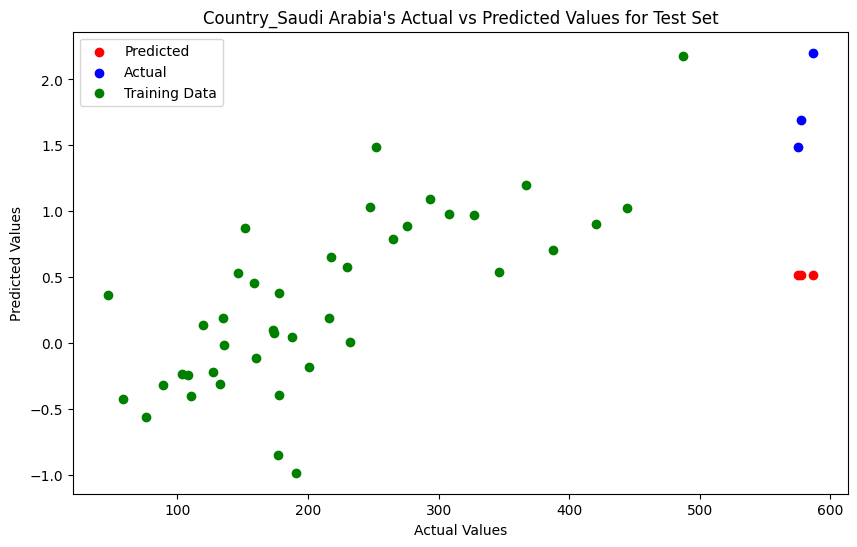

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - loss: 0.1425 - mae: 0.4120 - val_loss: 0.0135 - val_mae: 0.1555
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0429 - mae: 0.2241 - val_loss: 0.0014 - val_mae: 0.0534
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0887 - mae: 0.3681 - val_loss: 0.0015 - val_mae: 0.0534
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0629 - mae: 0.2760 - val_loss: 0.0018 - val_mae: 0.0535
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0586 - mae: 0.2749 - val_loss: 0.0067 - val_mae: 0.1027
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0757 - mae: 0.2925 - val_loss: 0.0029 - val_mae: 0.0544
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0767 - mae: 0.3049 - val_loss: 0.0179 - val_mae: 0.1813
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0546 - mae: 0.2799 - val_loss: 0.0134 - val_mae: 0.1544
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0504 - mae:

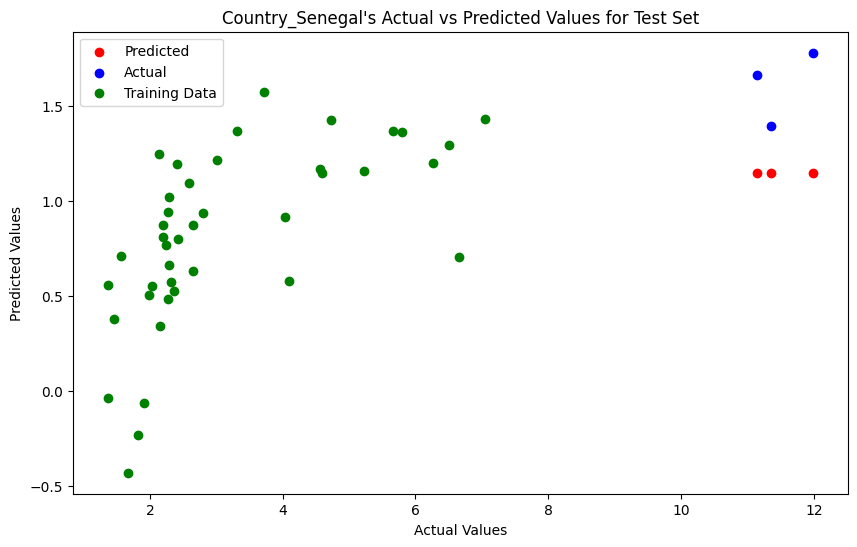

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.1691 - mae: 0.4514 - val_loss: 0.0543 - val_mae: 0.3172
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0623 - mae: 0.2794 - val_loss: 0.0829 - val_mae: 0.3906
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0712 - mae: 0.3166 - val_loss: 0.1881 - val_mae: 0.5962
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0576 - mae: 0.2617 - val_loss: 0.0402 - val_mae: 0.2511
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0420 - mae: 0.2361 - val_loss: 0.0753 - val_mae: 0.3603
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0282 - mae: 0.1898 - val_loss: 0.1514 - val_mae: 0.5301
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0403 - mae: 0.2324 - val_loss: 0.0836 - val_mae: 0.3785
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0330 - mae: 0.2125 - val_loss: 0.0976 - val_mae: 0.4138
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0407 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0678 - mae: 0.2973 - val_loss: 0.0601 - val_mae: 0.3418
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0360 - mae: 0.2330 - val_loss: 0.1745 - val_mae: 0.5907
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0430 - mae: 0.2240 - val_loss: 0.3882 - val_mae: 0.8811
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0758 - mae: 0.3272 - val_loss: 0.1515 - val_mae: 0.5492
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0467 - mae: 0.2519 - val_loss: 0.1239 - val_mae: 0.4952
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0389 - mae: 0.2208 - val_loss: 0.2241 - val_mae: 0.6694
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0412 - mae: 0.2417 - val_loss: 0.3077 - val_mae: 0.7838
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0445 - mae: 0.2325 - val_loss: 0.5337 - val_mae: 1.0330
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0548 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.0629 - mae: 0.2767 - val_loss: 0.0408 - val_mae: 0.2814
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0316 - mae: 0.2127 - val_loss: 0.0180 - val_mae: 0.1843
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0296 - mae: 0.1963 - val_loss: 0.0025 - val_mae: 0.0567
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - mae: 0.1683 - val_loss: 0.0059 - val_mae: 0.0995
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0354 - mae: 0.2200 - val_loss: 0.0155 - val_mae: 0.1712
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0312 - mae: 0.2026 - val_loss: 0.0034 - val_mae: 0.0706
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0285 - mae: 0.1889 - val_loss: 0.0013 - val_mae: 0.0423
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0222 - mae: 0.1629 - val_loss: 0.0396 - val_mae: 0.2784
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0413 - mae:

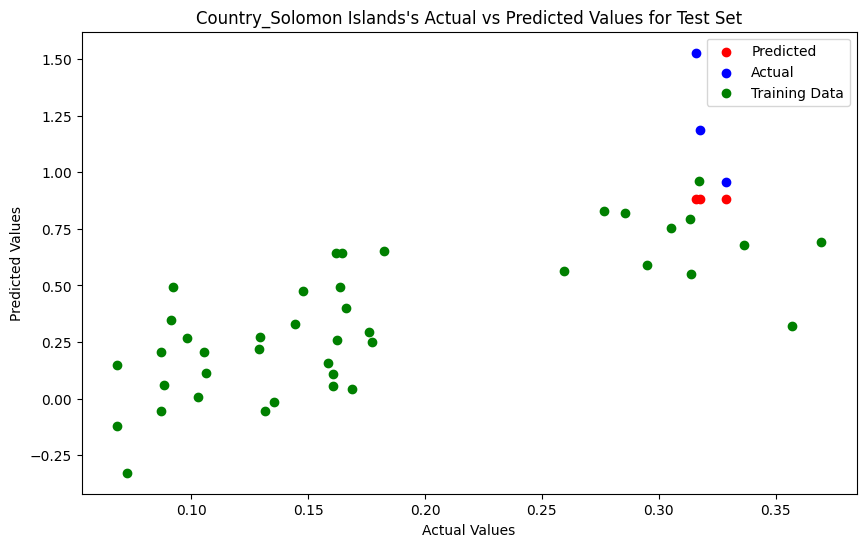

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.1571 - mae: 0.4426 - val_loss: 0.0831 - val_mae: 0.3669
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1314 - mae: 0.4020 - val_loss: 0.6539 - val_mae: 1.1538
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0928 - mae: 0.3531 - val_loss: 0.2675 - val_mae: 0.7113
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0702 - mae: 0.3073 - val_loss: 0.1907 - val_mae: 0.5931
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0829 - mae: 0.3426 - val_loss: 0.4245 - val_mae: 0.9066
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0659 - mae: 0.2820 - val_loss: 0.2182 - val_mae: 0.6357
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0523 - mae: 0.2785 - val_loss: 0.3343 - val_mae: 0.7975
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0452 - mae: 0.2260 - val_loss: 0.2605 - val_mae: 0.6986
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0539 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.0770 - mae: 0.3132 - val_loss: 0.4169 - val_mae: 0.8874
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0721 - mae: 0.3025 - val_loss: 0.1391 - val_mae: 0.4741
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0689 - mae: 0.3026 - val_loss: 0.3150 - val_mae: 0.7594
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0755 - mae: 0.3161 - val_loss: 0.2014 - val_mae: 0.5912
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0776 - mae: 0.3102 - val_loss: 0.2322 - val_mae: 0.6412
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0669 - mae: 0.2983 - val_loss: 0.2798 - val_mae: 0.7115
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0994 - mae: 0.3711 - val_loss: 0.1798 - val_mae: 0.5535
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0754 - mae: 0.3190 - val_loss: 0.2634 - val_mae: 0.6881
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0853 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0701 - mae: 0.3009 - val_loss: 0.2167 - val_mae: 0.6583
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0448 - mae: 0.2497 - val_loss: 0.1279 - val_mae: 0.5058
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0516 - mae: 0.2505 - val_loss: 0.1409 - val_mae: 0.5308
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0425 - mae: 0.2348 - val_loss: 0.0393 - val_mae: 0.2803
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0355 - mae: 0.2116 - val_loss: 0.0663 - val_mae: 0.3641
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0253 - mae: 0.1807 - val_loss: 0.0425 - val_mae: 0.2915
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0339 - mae: 0.1970 - val_loss: 0.0475 - val_mae: 0.3081
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0383 - mae: 0.2355 - val_loss: 0.1675 - val_mae: 0.5787
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0392 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0775 - mae: 0.3207 - val_loss: 0.0988 - val_mae: 0.4231
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0422 - mae: 0.2107 - val_loss: 0.0286 - val_mae: 0.2001
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1023 - mae: 0.3678 - val_loss: 0.0209 - val_mae: 0.1458
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0825 - mae: 0.3140 - val_loss: 0.0991 - val_mae: 0.4212
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0447 - mae: 0.2311 - val_loss: 0.0220 - val_mae: 0.1575
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0447 - mae: 0.2388 - val_loss: 0.0132 - val_mae: 0.1349
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0551 - mae: 0.2702 - val_loss: 0.0342 - val_mae: 0.2224
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0531 - mae: 0.2641 - val_loss: 0.0777 - val_mae: 0.3680
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0493 - mae:

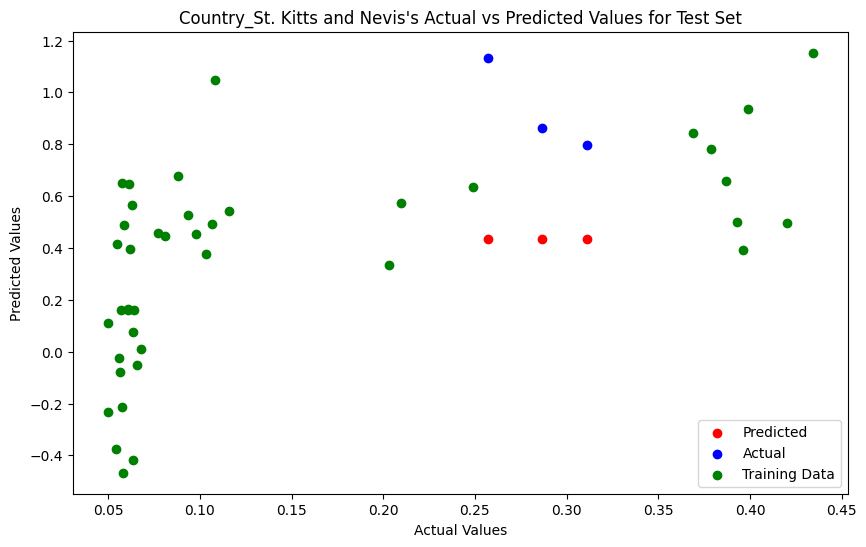

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - loss: 0.0412 - mae: 0.2200 - val_loss: 0.0300 - val_mae: 0.1969
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0374 - mae: 0.2134 - val_loss: 0.0250 - val_mae: 0.1710
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0397 - mae: 0.2291 - val_loss: 0.0112 - val_mae: 0.1490
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0398 - mae: 0.2191 - val_loss: 0.0306 - val_mae: 0.1955
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0224 - mae: 0.1426 - val_loss: 0.0156 - val_mae: 0.1636
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0249 - mae: 0.1689 - val_loss: 0.0319 - val_mae: 0.1846
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0351 - mae: 0.2204 - val_loss: 0.0471 - val_mae: 0.2563
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0355 - mae: 0.2135 - val_loss: 0.0420 - val_mae: 0.2359
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0273 - mae:

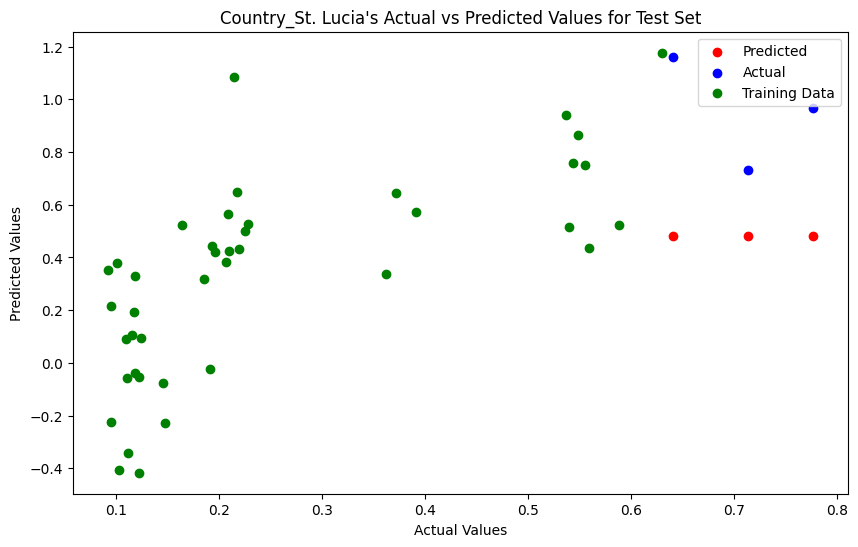

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.0665 - mae: 0.2902 - val_loss: 0.0021 - val_mae: 0.0647
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0307 - mae: 0.1917 - val_loss: 0.0015 - val_mae: 0.0382
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0537 - mae: 0.2854 - val_loss: 8.2409e-04 - val_mae: 0.0399
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0473 - mae: 0.2549 - val_loss: 0.0094 - val_mae: 0.1300
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0269 - mae: 0.1742 - val_loss: 0.0080 - val_mae: 0.1226
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0405 - mae: 0.2509 - val_loss: 0.0026 - val_mae: 0.0577
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0368 - mae: 0.2192 - val_loss: 0.0015 - val_mae: 0.0538
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0518 - mae: 0.2605 - val_loss: 0.0199 - val_mae: 0.1883
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0495 - 

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 0.1274 - mae: 0.4373 - val_loss: 0.3867 - val_mae: 0.8735
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0782 - mae: 0.3106 - val_loss: 0.8096 - val_mae: 1.3096
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1304 - mae: 0.4331 - val_loss: 0.4812 - val_mae: 0.9743
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1322 - mae: 0.4342 - val_loss: 0.6807 - val_mae: 1.1807
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0860 - mae: 0.3246 - val_loss: 0.7810 - val_mae: 1.2810
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1191 - mae: 0.4211 - val_loss: 0.4380 - val_mae: 0.9298
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0996 - mae: 0.3747 - val_loss: 0.6346 - val_mae: 1.1346
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0985 - mae: 0.3439 - val_loss: 0.6610 - val_mae: 1.1610
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1114 - mae:

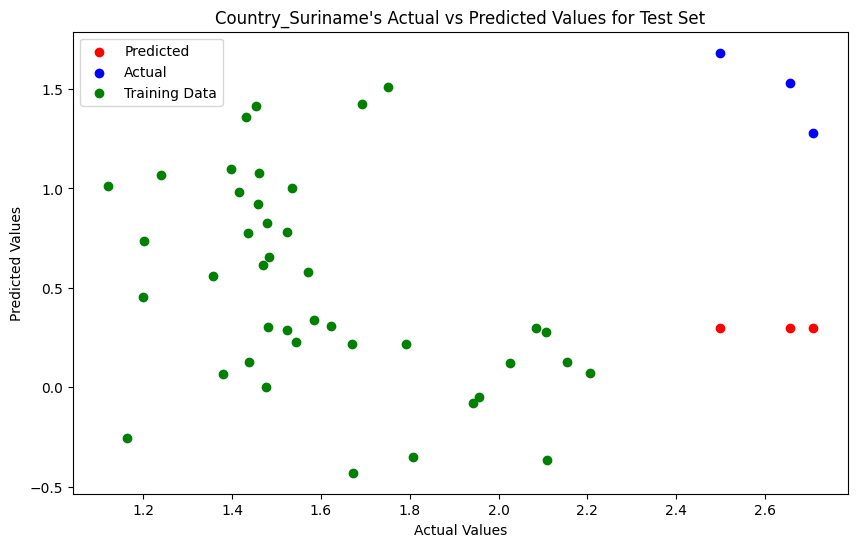

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - loss: 0.4166 - mae: 0.8110 - val_loss: 0.7408 - val_mae: 1.2392
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4346 - mae: 0.8280 - val_loss: 1.2637 - val_mae: 1.7637
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3782 - mae: 0.7627 - val_loss: 1.0326 - val_mae: 1.5326
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3293 - mae: 0.6490 - val_loss: 1.0487 - val_mae: 1.5487
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3339 - mae: 0.6904 - val_loss: 1.2608 - val_mae: 1.7608
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3365 - mae: 0.7432 - val_loss: 1.0885 - val_mae: 1.5885
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3693 - mae: 0.7374 - val_loss: 1.0334 - val_mae: 1.5334
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3500 - mae: 0.7136 - val_loss: 1.0727 - val_mae: 1.5727
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3885 - mae:

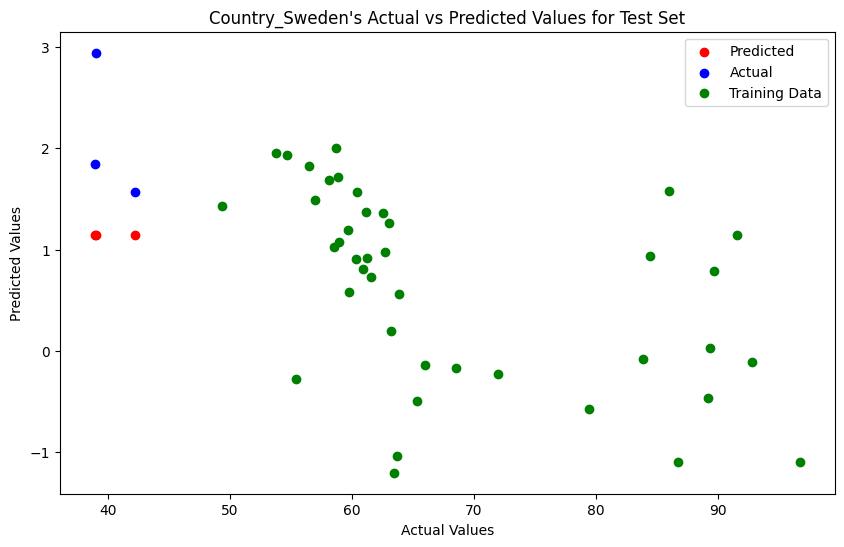

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 0.0840 - mae: 0.3390 - val_loss: 0.0837 - val_mae: 0.4068
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0740 - mae: 0.3245 - val_loss: 0.1379 - val_mae: 0.5232
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0801 - mae: 0.3227 - val_loss: 0.0194 - val_mae: 0.1919
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0739 - mae: 0.3137 - val_loss: 0.0321 - val_mae: 0.2490
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0445 - mae: 0.2439 - val_loss: 0.0016 - val_mae: 0.0551
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0599 - mae: 0.2795 - val_loss: 0.0778 - val_mae: 0.3916
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0529 - mae: 0.2555 - val_loss: 0.0021 - val_mae: 0.0534
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0569 - mae: 0.2643 - val_loss: 0.0029 - val_mae: 0.0614
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0428 - mae:

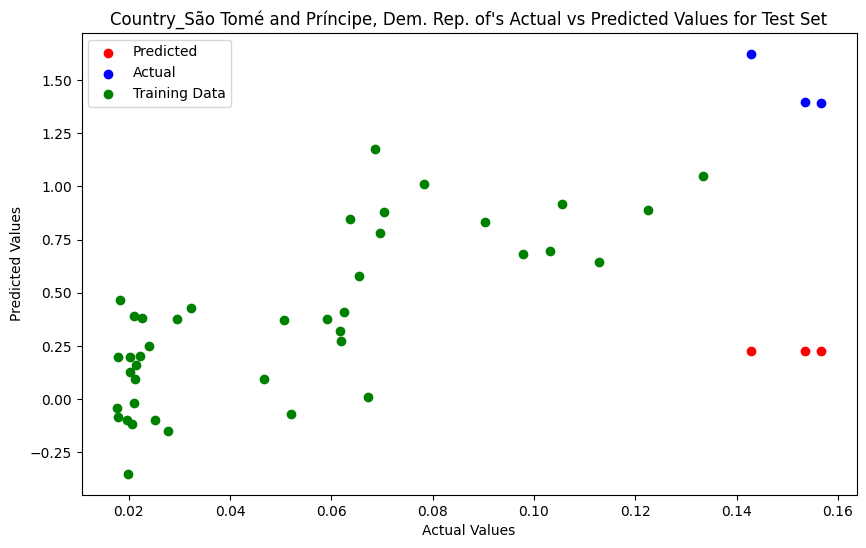

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.1050 - mae: 0.3237 - val_loss: 0.2553 - val_mae: 0.6602
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0464 - mae: 0.2189 - val_loss: 0.1909 - val_mae: 0.5541
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0693 - mae: 0.2778 - val_loss: 0.2467 - val_mae: 0.6470
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0487 - mae: 0.2396 - val_loss: 0.1077 - val_mae: 0.3751
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0568 - mae: 0.2687 - val_loss: 0.2326 - val_mae: 0.6248
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0410 - mae: 0.2333 - val_loss: 0.1661 - val_mae: 0.5072
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0598 - mae: 0.2714 - val_loss: 0.2350 - val_mae: 0.6286
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0691 - mae: 0.2667 - val_loss: 0.2062 - val_mae: 0.5810
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0615 - mae:

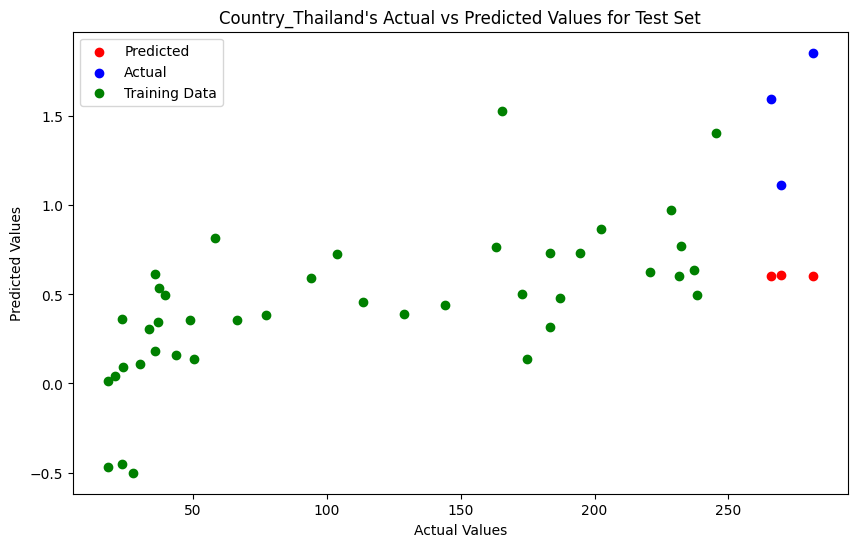

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - loss: 0.0991 - mae: 0.3612 - val_loss: 0.1857 - val_mae: 0.6034
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0500 - mae: 0.2669 - val_loss: 0.0702 - val_mae: 0.3647
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0955 - mae: 0.3863 - val_loss: 0.1178 - val_mae: 0.4773
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0334 - mae: 0.2015 - val_loss: 0.0855 - val_mae: 0.4043
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0258 - mae: 0.1657 - val_loss: 0.0387 - val_mae: 0.2631
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0312 - mae: 0.2091 - val_loss: 0.0968 - val_mae: 0.4301
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0359 - mae: 0.2269 - val_loss: 0.0493 - val_mae: 0.2995
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0246 - mae: 0.1743 - val_loss: 0.0602 - val_mae: 0.3328
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0266 - mae:

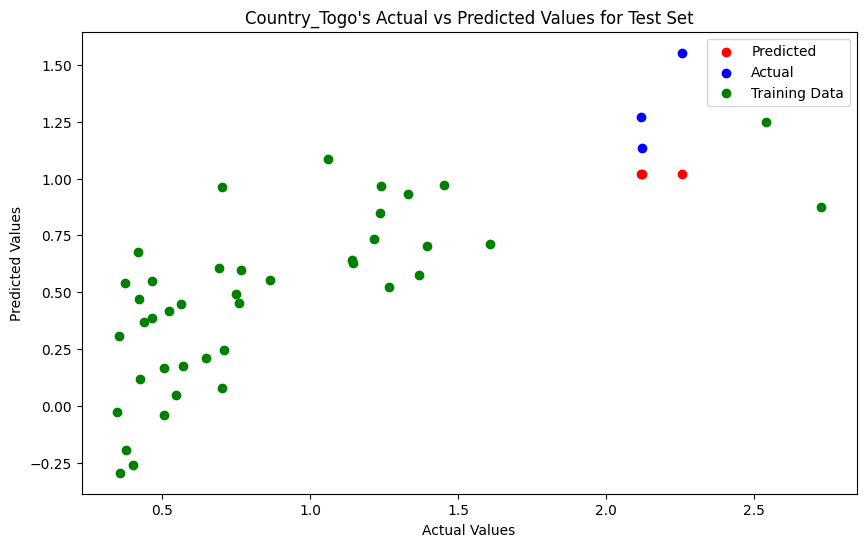

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0273 - mae: 0.1892 - val_loss: 0.0512 - val_mae: 0.3191
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0243 - mae: 0.1694 - val_loss: 0.0445 - val_mae: 0.2974
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0375 - mae: 0.2195 - val_loss: 0.0901 - val_mae: 0.4239
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0332 - mae: 0.2084 - val_loss: 0.0174 - val_mae: 0.1850
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0367 - mae: 0.2269 - val_loss: 0.0650 - val_mae: 0.3599
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0180 - mae: 0.1506 - val_loss: 0.0188 - val_mae: 0.1922
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0320 - mae: 0.2133 - val_loss: 0.0457 - val_mae: 0.3013
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0443 - mae: 0.2495 - val_loss: 0.0667 - val_mae: 0.3647
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0343 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.1977 - mae: 0.5016 - val_loss: 0.1480 - val_mae: 0.5400
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0784 - mae: 0.3044 - val_loss: 0.1217 - val_mae: 0.4889
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1023 - mae: 0.3572 - val_loss: 0.0814 - val_mae: 0.3980
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0827 - mae: 0.3113 - val_loss: 0.0408 - val_mae: 0.2780
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0499 - mae: 0.2300 - val_loss: 0.0971 - val_mae: 0.4357
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0700 - mae: 0.2790 - val_loss: 0.0200 - val_mae: 0.1885
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0657 - mae: 0.2844 - val_loss: 0.1019 - val_mae: 0.4465
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0819 - mae: 0.2831 - val_loss: 0.0552 - val_mae: 0.3255
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0864 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - loss: 0.1718 - mae: 0.4979 - val_loss: 0.2693 - val_mae: 0.6486
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1632 - mae: 0.4854 - val_loss: 0.3973 - val_mae: 0.8318
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1582 - mae: 0.4698 - val_loss: 0.2234 - val_mae: 0.5733
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1932 - mae: 0.5144 - val_loss: 0.3271 - val_mae: 0.7344
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2153 - mae: 0.5507 - val_loss: 0.6817 - val_mae: 1.1745
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2717 - mae: 0.6501 - val_loss: 0.2938 - val_mae: 0.6856
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2071 - mae: 0.5345 - val_loss: 0.3481 - val_mae: 0.7642
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1942 - mae: 0.5412 - val_loss: 0.4067 - val_mae: 0.8445
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2159 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.1131 - mae: 0.3873 - val_loss: 0.0841 - val_mae: 0.3809
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0522 - mae: 0.2292 - val_loss: 0.1173 - val_mae: 0.4643
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0581 - mae: 0.2384 - val_loss: 0.0885 - val_mae: 0.3988
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0748 - mae: 0.3123 - val_loss: 0.2446 - val_mae: 0.6871
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0721 - mae: 0.3213 - val_loss: 0.0935 - val_mae: 0.4118
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0523 - mae: 0.2488 - val_loss: 0.1215 - val_mae: 0.4751
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0586 - mae: 0.2738 - val_loss: 0.2599 - val_mae: 0.7095
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0845 - mae: 0.3332 - val_loss: 0.2346 - val_mae: 0.6732
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0814 - mae:

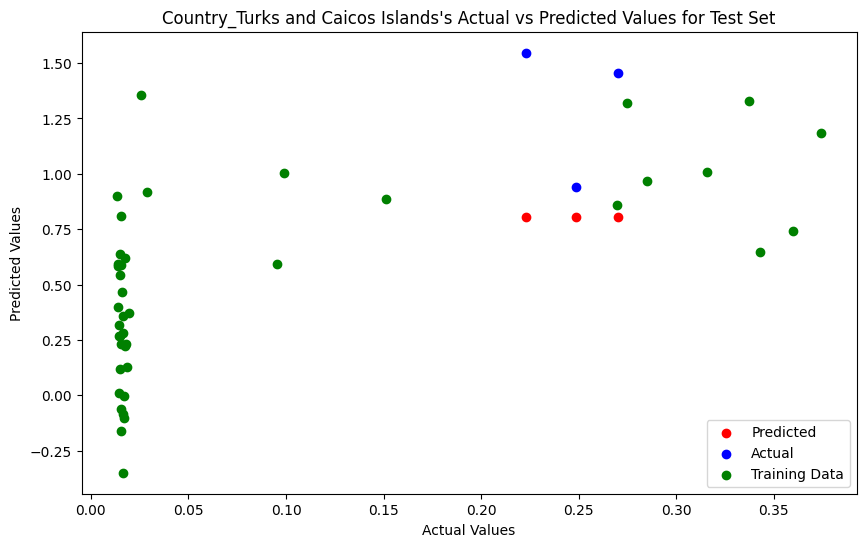

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.1043 - mae: 0.3523 - val_loss: 0.0605 - val_mae: 0.3474
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0532 - mae: 0.2482 - val_loss: 0.0431 - val_mae: 0.2932
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0423 - mae: 0.2197 - val_loss: 0.0400 - val_mae: 0.2824
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0280 - mae: 0.1962 - val_loss: 0.0058 - val_mae: 0.1073
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0218 - mae: 0.1675 - val_loss: 0.0018 - val_mae: 0.0597
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0210 - mae: 0.1693 - val_loss: 0.0027 - val_mae: 0.0733
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0243 - mae: 0.1776 - val_loss: 0.0052 - val_mae: 0.1014
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0238 - mae: 0.1826 - val_loss: 0.0110 - val_mae: 0.1480
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0242 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - loss: 0.2900 - mae: 0.6297 - val_loss: 0.8498 - val_mae: 1.3498
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1724 - mae: 0.4842 - val_loss: 0.3977 - val_mae: 0.8390
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1777 - mae: 0.4914 - val_loss: 0.5957 - val_mae: 1.0810
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1580 - mae: 0.4797 - val_loss: 0.4175 - val_mae: 0.8650
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1681 - mae: 0.4749 - val_loss: 0.7276 - val_mae: 1.2252
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2135 - mae: 0.5615 - val_loss: 0.2960 - val_mae: 0.6982
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2429 - mae: 0.6125 - val_loss: 0.5605 - val_mae: 1.0405
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2269 - mae: 0.5733 - val_loss: 0.4307 - val_mae: 0.8819
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1754 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 0.1775 - mae: 0.5180 - val_loss: 0.4237 - val_mae: 0.7714
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1581 - mae: 0.4756 - val_loss: 0.3667 - val_mae: 0.6741
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1735 - mae: 0.5026 - val_loss: 0.3773 - val_mae: 0.6927
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1378 - mae: 0.4615 - val_loss: 0.3480 - val_mae: 0.6401
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1654 - mae: 0.4893 - val_loss: 0.4162 - val_mae: 0.7590
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1530 - mae: 0.4909 - val_loss: 0.3562 - val_mae: 0.6551
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1470 - mae: 0.4710 - val_loss: 0.3930 - val_mae: 0.7199
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1353 - mae: 0.4543 - val_loss: 0.3448 - val_mae: 0.6342
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1875 - mae:

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.1228 - mae: 0.3994 - val_loss: 0.2961 - val_mae: 0.5753
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0984 - mae: 0.3658 - val_loss: 0.2923 - val_mae: 0.5683
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1080 - mae: 0.3750 - val_loss: 0.3079 - val_mae: 0.5974
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1015 - mae: 0.3893 - val_loss: 0.2569 - val_mae: 0.5150
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0923 - mae: 0.3472 - val_loss: 0.2597 - val_mae: 0.5150
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0995 - mae: 0.3617 - val_loss: 0.3165 - val_mae: 0.6132
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1032 - mae: 0.3680 - val_loss: 0.2857 - val_mae: 0.5556
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0875 - mae: 0.3425 - val_loss: 0.2636 - val_mae: 0.5150
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1061 - mae:

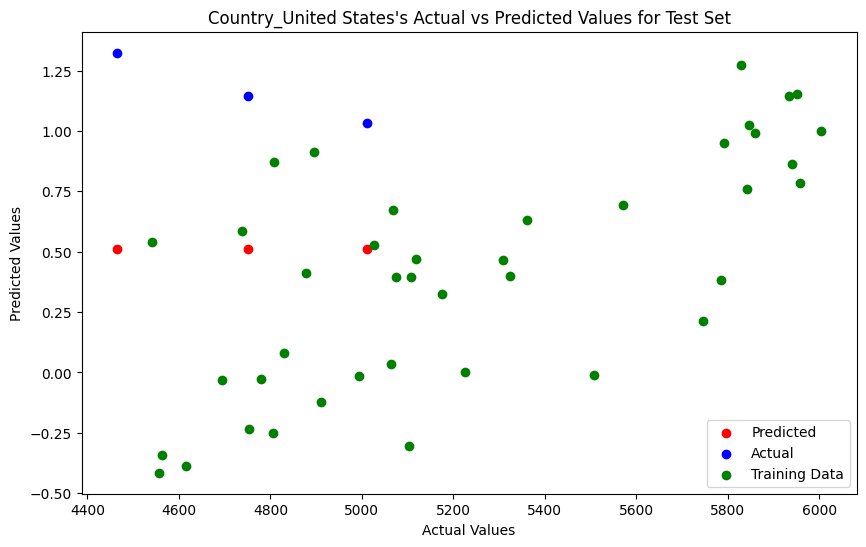

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - loss: 0.0530 - mae: 0.2539 - val_loss: 0.2732 - val_mae: 0.7369
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0734 - mae: 0.2854 - val_loss: 0.3513 - val_mae: 0.8362
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0639 - mae: 0.2813 - val_loss: 0.2702 - val_mae: 0.7329
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0657 - mae: 0.2783 - val_loss: 0.2115 - val_mae: 0.6478
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0867 - mae: 0.3235 - val_loss: 0.3167 - val_mae: 0.7937
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0622 - mae: 0.2618 - val_loss: 0.2593 - val_mae: 0.7178
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0573 - mae: 0.2629 - val_loss: 0.2976 - val_mae: 0.7693
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0711 - mae: 0.2918 - val_loss: 0.2627 - val_mae: 0.7223
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0558 - mae:

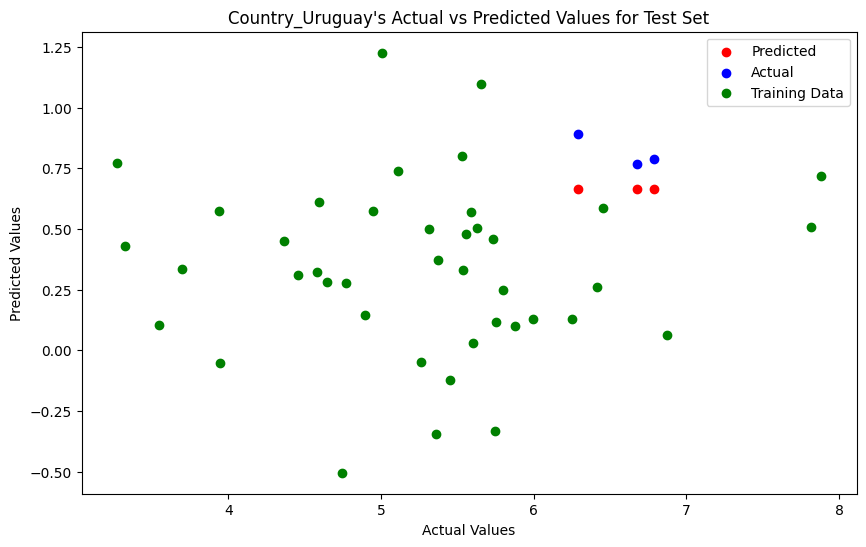

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.1171 - mae: 0.3863 - val_loss: 0.0272 - val_mae: 0.2331
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0653 - mae: 0.2897 - val_loss: 0.0453 - val_mae: 0.3007
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0471 - mae: 0.2549 - val_loss: 0.0399 - val_mae: 0.2820
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0498 - mae: 0.2614 - val_loss: 0.0651 - val_mae: 0.3605
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0477 - mae: 0.2565 - val_loss: 0.0656 - val_mae: 0.3616
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0303 - mae: 0.1931 - val_loss: 0.0506 - val_mae: 0.3172
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0549 - mae: 0.2815 - val_loss: 0.0669 - val_mae: 0.3651
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0536 - mae: 0.2860 - val_loss: 0.1468 - val_mae: 0.5419
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0570 - mae:

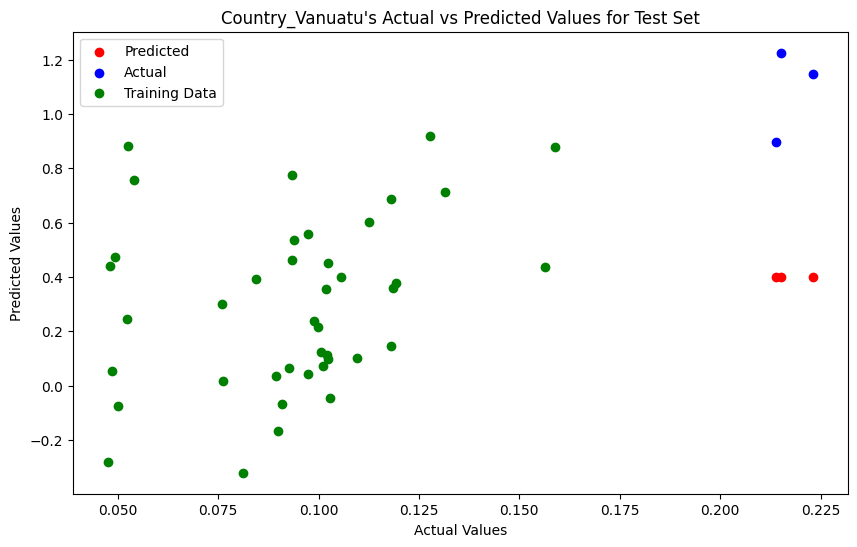

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.0803 - mae: 0.3095 - val_loss: 0.2052 - val_mae: 0.5423
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0691 - mae: 0.2864 - val_loss: 0.1662 - val_mae: 0.4649
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0835 - mae: 0.3187 - val_loss: 0.2160 - val_mae: 0.5620
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0815 - mae: 0.3033 - val_loss: 0.1484 - val_mae: 0.4249
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0799 - mae: 0.3256 - val_loss: 0.1774 - val_mae: 0.4884
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0704 - mae: 0.2903 - val_loss: 0.2135 - val_mae: 0.5574
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0993 - mae: 0.3584 - val_loss: 0.1780 - val_mae: 0.4896
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0914 - mae: 0.3372 - val_loss: 0.1930 - val_mae: 0.5193
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0883 - mae:

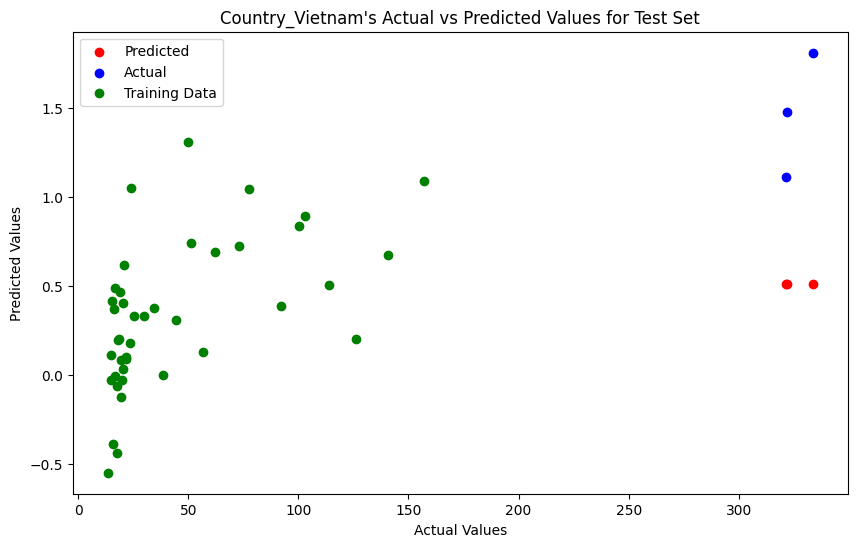

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 0.1567 - mae: 0.4689 - val_loss: 0.0137 - val_mae: 0.1548
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0882 - mae: 0.3092 - val_loss: 0.0353 - val_mae: 0.2593
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1316 - mae: 0.4090 - val_loss: 0.1376 - val_mae: 0.5219
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0918 - mae: 0.3602 - val_loss: 0.0256 - val_mae: 0.2195
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0734 - mae: 0.3172 - val_loss: 0.0022 - val_mae: 0.0544
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0716 - mae: 0.2958 - val_loss: 0.0513 - val_mae: 0.3157
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1129 - mae: 0.3937 - val_loss: 0.0077 - val_mae: 0.1120
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0767 - mae: 0.3025 - val_loss: 0.0092 - val_mae: 0.1247
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0675 - mae:

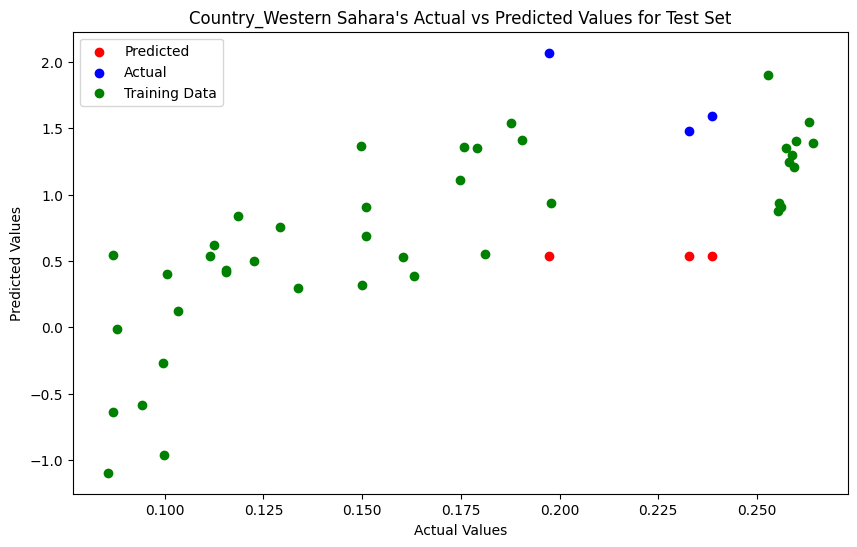

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0774 - mae: 0.3061 - val_loss: 0.4468 - val_mae: 0.9159
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1033 - mae: 0.3679 - val_loss: 0.5201 - val_mae: 1.0008
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0871 - mae: 0.3452 - val_loss: 0.4855 - val_mae: 0.9595
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0595 - mae: 0.2811 - val_loss: 0.4699 - val_mae: 0.9402
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0722 - mae: 0.3041 - val_loss: 0.6909 - val_mae: 1.1886
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0477 - mae: 0.2462 - val_loss: 0.7108 - val_mae: 1.2093
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0693 - mae: 0.3048 - val_loss: 0.6092 - val_mae: 1.1002
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0658 - mae: 0.2935 - val_loss: 0.7322 - val_mae: 1.2315
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0768 - mae:

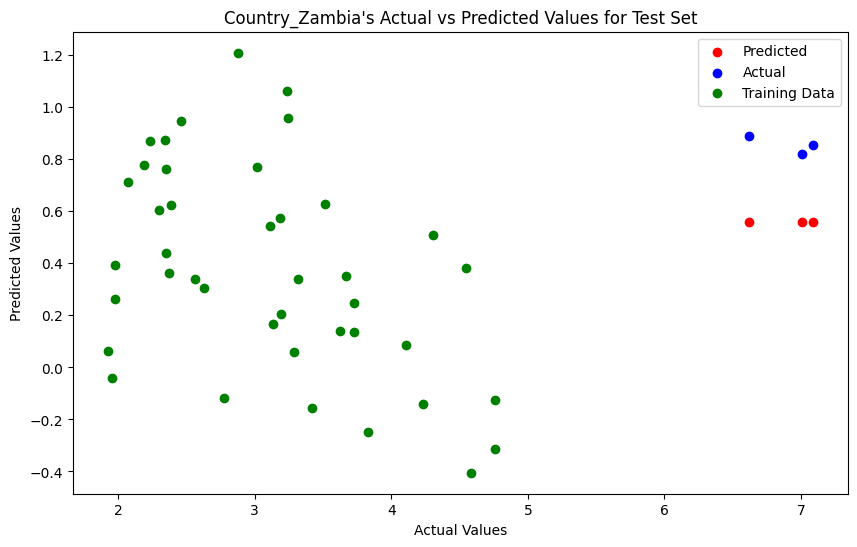

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.1052 - mae: 0.3689 - val_loss: 0.2611 - val_mae: 0.5470
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1367 - mae: 0.4046 - val_loss: 0.1187 - val_mae: 0.4725
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0970 - mae: 0.3788 - val_loss: 0.1974 - val_mae: 0.4725
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0835 - mae: 0.3041 - val_loss: 0.1303 - val_mae: 0.4725
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1090 - mae: 0.3836 - val_loss: 0.1331 - val_mae: 0.4725
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0876 - mae: 0.3420 - val_loss: 0.1779 - val_mae: 0.4725
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1537 - mae: 0.4754 - val_loss: 0.1290 - val_mae: 0.4725
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1126 - mae: 0.3907 - val_loss: 0.1956 - val_mae: 0.4725
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1073 - mae:

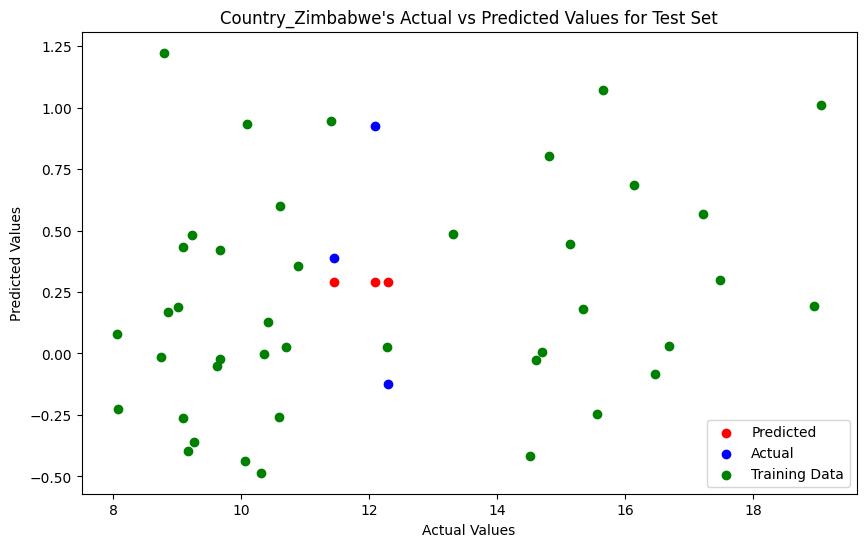

In [10]:
for country in df.columns[3:]:

  if df[country].sum() == 52:

    country_data = df[df[country] == 1][['Year', 'Temperature', 'Co2']]

    X = country_data[['Co2']].values
    y = country_data['Temperature'].values

    split_index = int(len(X) * 0.8)

    X_train, X_val_test = X[:split_index], X[split_index:]
    y_train, y_val_test = y[:split_index], y[split_index:]


    split_index_val = int(len(X_val_test) * 0.5)

    X_val, X_test = X_val_test[:split_index_val], X_val_test[split_index_val:]
    y_val, y_test = y_val_test[:split_index_val], y_val_test[split_index_val:]


    seq_length = 3
    tf.random.set_seed(42)

    train_ds = keras.utils.timeseries_dataset_from_array(
        X_train,
        targets = y_train[seq_length:],
        sequence_length= seq_length,
        batch_size = 5,
        shuffle = True,
        seed = 42
    )

    valid_ds = keras.utils.timeseries_dataset_from_array(
        X_val,
        targets= y_val[seq_length:],
        sequence_length = seq_length,
        batch_size = 32
    )

    model = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)

    test_predictions = deep_model.predict(test_ds)

    plt.figure(figsize=(10, 6))

    plt.scatter(X_test[seq_length:], test_predictions, color='red', label='Predicted')
    plt.scatter(X_test[seq_length:], y_test[seq_length:], color='blue', label='Actual')
    plt.scatter(X_train, y_train, label='Training Data', color='green')

    plt.title(f"{country}'s Actual vs Predicted Values for Test Set")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()
    